In [74]:
import os, datetime

from qubitPack.tool_box import get_db, get_band_edges_characters, get_unique_sites_from_wy, get_good_ir_sites
from qubitPack.tool_box import IOTools

import pandas as pd
pd.set_option('display.max_rows', 500)

from pymatgen import Spin
from pymatgen.io.vasp.inputs import Structure

from monty.serialization import loadfn

from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

plt.style.use(['science', 'notebook', 'grid'])


C2DB = get_db("2dMat_from_cmr_fysik", "2dMaterial_v1", user="readUser", password="qiminyan", port=1234)
SCAN2dMat = get_db("Scan2dMat", "calc_data",  user="Jeng_ro", password="qimin", port=1236)
SCAN2dDefect = get_db("Scan2dDefect", "calc_data",  user="Jeng_ro", password="qimin", port=1236)
C2DB_IR = get_db("C2DB_IR", "calc_data",  user="Jeng_ro", password="qimin", port=1234)

save_dir_path = "/Users/jeng-yuantsai/Research/project/Scan2dDefect/latest_results"

# Host 

In [2]:
class DefectStats:
    @classmethod
    def host_candidate_stats(cls):
        col = SCAN2dMat.collection
        filter = {
            "output.bandgap":{"$gte":1},
#             "c2db_info.gap_hse_nosoc":{"$gte":1.5},
            "task_label": "SCAN_nscf line"
        }
        show = {
            "formula":1,
            "class":1,
            "ehull":1,
            "spacegroup":1,
            "gap_hse_nosoc":1
        }

        hosts = []
        host_candidates = list(col.find(filter))
        for e in host_candidates[:]:
            print(e["task_id"])
            print(e["task_id"], e["c2db_info"]["uid"])
            bs = SCAN2dMat.get_band_structure(e["task_id"])
            data = {}
            # add band edges info
            if bs.get_band_gap()["energy"] != 0:
                data = get_band_edges_characters(bs)
                data.update({"tk_id": e["task_id"]})


            st = Structure.from_dict(e["input"]["structure"])
            species, site_syms, wyckoffs, pg, site_idx, spg, spg_number = get_unique_sites_from_wy(st, symprec=1e-1).values()
            good_ir = get_good_ir_sites(st, symprec=1e-1)

            print(e["c2db_info"]["uid"])
            d = {
                "species": tuple(species),
                "reduced_species": tuple(good_ir["species"]),
                "site_sym": tuple(site_syms),
                "reduced_site_sym": tuple(good_ir["site_syms"]),
                "wyckoffs": tuple(wyckoffs),
                "reduced_wy": tuple(good_ir["wys"]),
                "site_idx": tuple(site_idx),
                "reduced_site_idx": tuple(good_ir["site_idx"]),
                "pmg_point_gp": pg,
                "prototype": e["c2db_info"]["prototype"],
                "formula": e["c2db_info"]["formula"],
                "spacegroup": e["c2db_info"]["spacegroup"],
                "gap_scan": e["output"]["bandgap"],
                "gap_hse": e["c2db_info"]["gap_hse"],
                "gap_hse_nosoc": e["c2db_info"]["gap_hse_nosoc"],
                "soc_intensity": e["c2db_info"]["gap_hse_nosoc"] - e["c2db_info"]["gap_hse"],
                "ehull": e["c2db_info"]["ehull"],
                "uid":e["c2db_info"]["uid"],
            }
            d.update(data)
            hosts.append(d)
        # print(bad_pg)
        host_df = pd.DataFrame(hosts)
        return host_df

host_df = DefectStats.host_candidate_stats()

4
4 BN-BN-NM
{'cbm': {'up': {'max_element_idx': 0, 'max_element': 'B', 'max_proj': 0.5265, 'proj_on_element': array([0.5265, 0.    ])}, 'down': {'max_element_idx': 0, 'max_element': 'B', 'max_proj': 0.5265, 'proj_on_element': array([0.5265, 0.    ])}, 'is_up_dn_band_idx_equal': True}, 'vbm': {'up': {'max_element_idx': 1, 'max_element': 'N', 'max_proj': 0.611, 'proj_on_element': array([0.   , 0.611])}, 'down': {'max_element_idx': 1, 'max_element': 'N', 'max_proj': 0.611, 'proj_on_element': array([0.   , 0.611])}, 'is_up_dn_band_idx_equal': True}}
['B', 'N'] ['-6m2', '-6m2'] ['b', 'd'] -6m2
['B', 'N'] ['-6m2', '-6m2'] ['b', 'd'] -6m2
['B', 'N'] ['-6m2', '-6m2'] ['b', 'd'] -6m2 [0, 1]
BN-BN-NM
29
29 PdS2-CdI2-NM
{'cbm': {'up': {'max_element_idx': 0, 'max_element': 'Pd', 'max_proj': 0.38709999999999994, 'proj_on_element': array([0.3871, 0.1465, 0.1465])}, 'down': {'max_element_idx': 0, 'max_element': 'Pd', 'max_proj': 0.38699999999999996, 'proj_on_element': array([0.387 , 0.1465, 0.1465])}

## Uniform site symmetries

In [356]:
uni = host_df["reduced_site_sym"].isin([("-6m2", "-6m2"), ("3m", "3m"), ("4mm", "4mm")])

In [362]:
uniform_host_df = host_df.loc[uni, :]

In [367]:
uniform_host_df.groupby(["reduced_site_sym", "prototype"]).uid.agg(["count", "unique"])

count  \
reduced_site_sym prototype          
(-6m2, -6m2)     BN             4   
(3m, 3m)         CH            15   
                 GaS           11   
                 GaSe          10   
                 GeSe          16   
(4mm, 4mm)       PbS            1   

                                                                       unique  
reduced_site_sym prototype                                                     
(-6m2, -6m2)     BN              [BN-BN-NM, AlN-BN-NM, GaN-BN-NM, AlAs-BN-NM]  
(3m, 3m)         CH         [Cu2I2-CH-NM, Au2I2-CH-NM, Cd2Se2-CH-NM, Zn2S2...  
                 GaS        [Al2S2-GaS-NM, Ga2Te2-GaS-NM, Al2Se2-GaS-NM, A...  
                 GaSe       [Ga2Te2-GaSe-NM, Al2Se2-GaSe-NM, Ga2Se2-GaSe-N...  
                 GeSe       [GaP-GeSe-NM, GeS-GeSe-NM, GaAs-GeSe-NM, PbO-G...  
(4mm, 4mm)       PbS                                          [Pb2Se2-PbS-NM]

## Non-uniform site symmetries

In [364]:
nonuni = ~host_df["reduced_site_sym"].isin([("-6m2", "-6m2"), ("3m", "3m"), ("4mm", "4mm")])

In [365]:
nonuniform_host_df = host_df.loc[nonuni, :]

In [370]:
nonuniform_host_df.groupby(["reduced_site_sym", "prototype"]).uid.agg(["count", "unique"])

count  \
reduced_site_sym prototype          
()               AuSe           7   
                 CH             1   
                 ISb            1   
                 PbS            1   
                 PdS2          12   
                 SnS            8   
                 TiS3           4   
                 VTe3           1   
                 WTe2          13   
(-3m, 3m)        CdI2          48   
(-42m,)          GeS2          48   
(-42m, 4mm)      FeSe          22   
(-6,)            AgBr3          3   
                 TiCl3         11   
(-6m2,)          AgBr3          4   
(-6m2, 3m)       MoS2          39   
(3,)             BiI3          28   
(3m, -6m2)       MoS2           2   

                                                                       unique  
reduced_site_sym prototype                                                     
()               AuSe       [Cu2S2-AuSe-NM, Au2S2-AuSe-NM, Ag2Te2-AuSe-NM,...  
                 CH                                            [Tl2Cl2-CH-NM]  
                 ISb                                          [Tl2Br2-ISb-NM]  
                 PbS                                           [Pb2S2-PbS-NM]  
                 PdS2       [Zn2S4-PdS2-NM, Pd2Se4-PdS2-NM, Pt2Te4-PdS2-NM...  
                 SnS        [Ge2S2-SnS-NM, Sn2S2-SnS-NM, S2Si2-SnS-NM, Sn2...  
                 TiS3       [Ti2O6-TiS3-NM, Hf2S6-TiS3-NM, Zr2O6-TiS3-NM, ...  
                 VTe3                                        [Ru2Se6-VTe3-NM]  
                 WTe2       [Ru2S4-WTe2-NM, Ru2Te4-WTe2-NM, Hf2Br4-WTe2-NM...  
(-3m, 3m)        CdI2       [PdS2-CdI2-NM, MgCl2-CdI2-NM, TiO2-CdI2-NM, Sn...  
(-42m,)          GeS2       [SnF2-GeS2-NM, ZrO2-GeS2-NM, GeO2-GeS2-NM, ZrS...  
(-42m, 4mm)      FeSe       [Cu2Cl2-FeSe-NM, Rb2I2-FeSe-NM, Cs2Cl2-FeSe-NM...  
(-6,)            AgBr3      [Bi2Br6-AgBr3-NM, Tl2Cl6-AgBr3-NM, In2Cl6-AgBr...  
                 TiCl3      [Al2Cl6-TiCl3-NM, Bi2I6-TiCl3-NM, Tl2Br6-TiCl3...  
(-6m2,)          AgBr3      [Sc2Cl6-AgBr3-NM, Bi2Cl6-AgBr3-NM, Y2Br6-AgBr3...  
(-6m2, 3m)       MoS2       [MgCl2-MoS2-NM, ZnCl2-MoS2-NM, MoO2-MoS2-NM, G...  
(3,)             BiI3       [Rh2Cl6-BiI3-NM, Ir2Cl6-BiI3-NM, Bi2Cl6-BiI3-N...  
(3m, -6m2)       MoS2                           [MoTe2-MoS2-NM, WTe2-MoS2-NM]

# Defect

In [41]:
data = []
col = SCAN2dDefect.collection
for e in col.find({"task_label": "SCAN_nscf uniform"}):
#     print(e["host_info"]["c2db_info"]["uid"], e["task_id"])
    try:
        is_vbm_cbm_same = host_df.loc[host_df["uid"] == e["host_info"]["c2db_info"]["uid"], "is_vbm_cbm_from_same_element"].iloc[0]
        hse_gap_nosoc = host_df.loc[host_df["uid"] == e["host_info"]["c2db_info"]["uid"], "gap_hse_nosoc"].iloc[0]
    except:
        is_vbm_cbm_same = None
        hse_gap_nosoc = None
        
    is_nelect_even = None
    if e["input"]["incar"]["NELECT"] % 2 == 0:
        is_nelect_even = True
    else:
        is_nelect_even = False
        
    info = {
        "task_id": e["task_id"],
        "is_vbm_cbm_same": is_vbm_cbm_same, 
        "c2db_uid": e["host_info"]["c2db_info"]["uid"],
        "prototype": e["host_info"]["c2db_info"]["prototype"],
        "gap_scan": e["host_info"]["scan_bs"]["bandgap"],
        "hse_gap_nosoc":hse_gap_nosoc,
        "defect_name": e["defect_name"],
        "defect_type": e["defect_entry"]["defect_type"],
        "charge": e["charge_state"],
        "mag": e["calcs_reversed"][0]["output"]["outcar"]["total_magnetization"],
        "reduced_site_sym": tuple(e["host_info"]["sym_data"]["good_ir_info"]["site_sym"]),
        "reduced_site_specie": tuple(e["host_info"]["sym_data"]["good_ir_info"]["species"]),
        "chemsys": e["chemsys"],
        "is_nelect_even": is_nelect_even
    }
    data.append(info)
df = pd.DataFrame(data)
display(df)

task_id  is_vbm_cbm_same        c2db_uid prototype  gap_scan  \
0           7             True    Al2S2-GaS-NM       GaS    2.0676   
1          10            False        BN-BN-NM        BN    4.8382   
2          12            False        BN-BN-NM        BN    4.8382   
3          17            False     GaP-GeSe-NM      GeSe    1.7872   
4          21            False     GaP-GeSe-NM      GeSe    1.7872   
...       ...              ...             ...       ...       ...   
1080     4445            False   Ir2I6-BiI3-NM      BiI3    1.5943   
1081     4454            False  Ga2Br6-BiI3-NM      BiI3    2.8849   
1082     4456            False   Cs2F2-FeSe-NM      FeSe    4.6339   
1083     4458             True    K2I2-FeSe-NM      FeSe    3.9743   
1084     4461            False  Sc2Br6-BiI3-NM      BiI3    3.1196   

      hse_gap_nosoc defect_name defect_type  charge       mag  \
0          2.882262     vac_2_S     vacancy       0  0.000000   
1          5.675463     vac_1_B     vacancy       0  3.000000   
2          5.675463     vac_2_N     vacancy       0  1.000000   
3          2.372396     vac_2_P     vacancy       0  1.000000   
4          2.372396    vac_1_Ga     vacancy       0  1.000000   
...             ...         ...         ...     ...       ...   
1080       2.600032    vac_1_Ir     vacancy       1  3.999995   
1081       3.740071    vac_1_Ga     vacancy       1  4.000000   
1082       6.140072     vac_2_F     vacancy       1 -0.000000   
1083       5.039913     vac_2_I     vacancy       1 -0.000000   
1084       5.010688    vac_1_Sc     vacancy       1  4.000000   

     reduced_site_sym reduced_site_specie chemsys  is_nelect_even  
0            (3m, 3m)             (Al, S)    Al-S            True  
1        (-6m2, -6m2)              (B, N)     B-N           False  
2        (-6m2, -6m2)              (B, N)     B-N           False  
3            (3m, 3m)             (Ga, P)    Ga-P           False  
4            (3m, 3m)             (Ga, P)    Ga-P           False  
...               ...                 ...     ...             ...  
1080             (3,)               (Ir,)    I-Ir            True  
1081             (3,)               (Ga,)   Br-Ga            True  
1082      (-42m, 4mm)             (Cs, F)    Cs-F            True  
1083      (-42m, 4mm)              (K, I)     I-K            True  
1084             (3,)               (Sc,)   Br-Sc            True  

[1085 rows x 14 columns]

In [53]:
triplet_df = df.loc[(df["mag"].round(0) == 2) & (df["charge"] == 0), :]
display(triplet_df.count())
grouping = ["prototype", "reduced_site_sym", 
            "is_vbm_cbm_same", "reduced_site_specie",
            "chemsys", "defect_type", "charge", "defect_name"]
output_df = triplet_df.groupby(grouping).task_id.agg(count="count", taskid="unique")
display(output_df)
IOTools(cwd=save_dir_path, pandas_df=output_df).to_excel("charged_defect", index=True)

task_id                178
is_vbm_cbm_same        178
c2db_uid               178
prototype              178
gap_scan               178
hse_gap_nosoc          178
defect_name            178
defect_type            178
charge                 178
mag                    178
reduced_site_sym       178
reduced_site_specie    178
chemsys                178
is_nelect_even         178
dtype: int64

count  \
prototype reduced_site_sym is_vbm_cbm_same reduced_site_specie chemsys defect_type charge defect_name            
AgBr3     (-6,)            False           (Bi,)               Bi-Br   antisite    0      as_1_Br_on_Bi      1   
                                           (In,)               Cl-In   antisite    0      as_1_Cl_on_In      1   
                                           (Tl,)               Cl-Tl   antisite    0      as_1_Cl_on_Tl      1   
          (-6m2,)          False           (Bi,)               Bi-Cl   antisite    0      as_1_Cl_on_Bi      1   
                                           (Sc,)               Cl-Sc   antisite    0      as_1_Cl_on_Sc      1   
                                           (Y,)                Br-Y    antisite    0      as_1_Br_on_Y       1   
                                                               Cl-Y    antisite    0      as_1_Cl_on_Y       1   
BN        (-6m2, -6m2)     False           (Ga, N)             Ga-N    antisite    0      as_1_N_on_Ga       1   
BiI3      (3,)             False           (Al,)               Al-Br   antisite    0      as_1_Br_on_Al      1   
                                                               Al-I    antisite    0      as_1_I_on_Al       1   
                                           (As,)               As-Br   antisite    0      as_1_Br_on_As      1   
                                           (Bi,)               Bi-Br   antisite    0      as_1_Br_on_Bi      1   
                                                               Bi-I    antisite    0      as_1_I_on_Bi       1   
                                           (Ga,)               Br-Ga   antisite    0      as_1_Br_on_Ga      1   
                                                               Cl-Ga   antisite    0      as_1_Cl_on_Ga      1   
                                                               Ga-I    antisite    0      as_1_I_on_Ga       1   
                                           (In,)               Br-In   antisite    0      as_1_Br_on_In      1   
                                                               Cl-In   antisite    0      as_1_Cl_on_In      1   
                                                               I-In    antisite    0      as_1_I_on_In       1   
                                           (Ir,)               I-Ir    antisite    0      as_1_I_on_Ir       1   
                                           (Sb,)               I-Sb    antisite    0      as_1_I_on_Sb       1   
                                           (Sc,)               Br-Sc   antisite    0      as_1_Br_on_Sc      1   
                                                               Cl-Sc   antisite    0      as_1_Cl_on_Sc      1   
                                                               I-Sc    antisite    0      as_1_I_on_Sc       1   
                                           (Tl,)               Br-Tl   antisite    0      as_1_Br_on_Tl      1   
                                                               Cl-Tl   antisite    0      as_1_Cl_on_Tl      1   
                                           (Y,)                Br-Y    antisite    0      as_1_Br_on_Y       1   
                                                               I-Y     antisite    0      as_1_I_on_Y        1   
                           True            (Al,)               Al-Cl   antisite    0      as_1_Cl_on_Al      1   
                                           (Ir,)               Br-Ir   antisite    0      as_1_Br_on_Ir      1   
                                           (Rh,)               Br-Rh   antisite    0      as_1_Br_on_Rh      1   
                                                               Cl-Rh   antisite    0      as_1_Cl_on_Rh      1   
                                                               I-Rh    antisite    0      as_1_I_on_Rh       1   
CH        (3m, 3m)         False           (C, F)              C-F     vacancy     0      vac_1_C            1   
 

In [59]:
display(output_df.iloc[:,1].tolist())

[array([2919]),
 array([3428]),
 array([3425]),
 array([3491]),
 array([3503]),
 array([3403]),
 array([2975]),
 array([523]),
 array([2930]),
 array([3353]),
 array([3350]),
 array([3310]),
 array([2933]),
 array([2971]),
 array([2949]),
 array([3359]),
 array([3429]),
 array([3389]),
 array([3433]),
 array([2936]),
 array([3308]),
 array([3407]),
 array([3001]),
 array([3369]),
 array([3328]),
 array([3314]),
 array([3354]),
 array([3331]),
 array([3385]),
 array([3374]),
 array([3446]),
 array([3295]),
 array([3388]),
 array([2113]),
 array([1320]),
 array([1337]),
 array([1308]),
 array([1347]),
 array([1329]),
 array([1366]),
 array([1354]),
 array([1348]),
 array([1280]),
 array([1306]),
 array([3789]),
 array([3702]),
 array([3758]),
 array([3745]),
 array([3703]),
 array([3741]),
 array([3532]),
 array([3768]),
 array([3799]),
 array([3693]),
 array([3749]),
 array([3658]),
 array([3716]),
 array([3730]),
 array([3537]),
 array([3760]),
 array([3677]),
 array([3775]),
 array([3

In [145]:
dd = df.loc[df["mag"].round(0) == 2, :]
dd.sort_values(["hse_gap_nosoc", "c2db_uid", "defect_name"], inplace=True)
display(dd)

                                          
IOTools(cwd=defect_path, pandas_df=dd.loc[dd["is_vbm_cbm_same"].isin([1]), :]).to_excel("defect_same_vbm_cbm")



/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


task_id is_vbm_cbm_same       c2db_uid prototype  gap_scan  \
786     3292            True   WTe2-MoS2-NM      MoS2    1.1615   
788     3298            True  MoTe2-MoS2-NM      MoS2    1.2107   
785     3282            True  MoTe2-MoS2-NM      MoS2    1.2107   
398     1763            True    Ge2H2-CH-NM        CH    1.3235   
281     1280            True    Ge2H2-CH-NM        CH    1.3235   
..       ...             ...            ...       ...       ...   
913     3781           False  SrCl2-CdI2-NM      CdI2    5.1806   
851     3537           False  MgCl2-CdI2-NM      CdI2    5.9952   
893     3703           False  CaCl2-CdI2-NM      CdI2    5.7187   
296     1347            None    Tl2I2-CH-NM        CH    3.0241   
292     1329            None    Tl2I2-CH-NM        CH    3.0241   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
786       1.486893   as_1_Te_on_W    antisite       0  2.0  
788       1.516223  as_1_Mo_on_Te    antisite       0  2.0  
785       1.516223  as_1_Te_on_Mo    antisite       0  2.0  
398       1.586213   as_1_H_on_Ge    antisite      -1  2.0  
281       1.586213       vac_1_Ge     vacancy       0  2.0  
..             ...            ...         ...     ...  ...  
913       7.053662       vac_1_Sr     vacancy       0  2.0  
851       7.338506       vac_1_Mg     vacancy       0  2.0  
893       7.446433       vac_1_Ca     vacancy       0  2.0  
296            NaN   as_1_I_on_Tl    antisite       0  2.0  
292            NaN   as_1_Tl_on_I    antisite       0  2.0  

[285 rows x 10 columns]

In [146]:
diff_vbm_cbm = dd.loc[dd["is_vbm_cbm_same"].isin([0, None]), :]
display(diff_vbm_cbm.loc[diff_vbm_cbm["defect_name"].str.contains("vac"), :].count())
display(diff_vbm_cbm.loc[diff_vbm_cbm["defect_name"].str.contains("as"), :].count())


# IOTools(cwd=defect_path, pandas_df=diff_vbm_cbm).to_excel("defect_diff_vbm_cbm")

task_id            104
is_vbm_cbm_same    104
c2db_uid           104
prototype          104
gap_scan           104
hse_gap_nosoc      104
defect_name        104
defect_type        104
charge             104
mag                104
dtype: int64

task_id            87
is_vbm_cbm_same    85
c2db_uid           87
prototype          87
gap_scan           87
hse_gap_nosoc      85
defect_name        87
defect_type        87
charge             87
mag                87
dtype: int64

In [147]:
same_vbm_cbm = dd.loc[dd["is_vbm_cbm_same"].isin([1]), :]
display(same_vbm_cbm.loc[same_vbm_cbm["defect_name"].str.contains("vac"), :].count())
display(same_vbm_cbm.loc[same_vbm_cbm["defect_name"].str.contains("as"), :].count())

# IOTools(cwd=defect_path, pandas_df=diff_vbm_cbm).to_excel("defect_same_vbm_cbm")

task_id            33
is_vbm_cbm_same    33
c2db_uid           33
prototype          33
gap_scan           33
hse_gap_nosoc      33
defect_name        33
defect_type        33
charge             33
mag                33
dtype: int64

task_id            61
is_vbm_cbm_same    61
c2db_uid           61
prototype          61
gap_scan           61
hse_gap_nosoc      61
defect_name        61
defect_type        61
charge             61
mag                61
dtype: int64

### *The above two results show that antisites tend to have triplet states in uniform band components.

# Host catagories

## uniform host band components

In [148]:
same_vbm_cbm = dd.loc[(dd["is_vbm_cbm_same"].isin([1])), :]
fig = plt.figure(dpi=300, figsize=(20, 20))

for plt_idx, prototype in enumerate(same_vbm_cbm["prototype"].unique().tolist()):
    print(plt_idx, prototype)
    ax = fig.add_subplot(4, 3, plt_idx+1)
    freq = same_vbm_cbm.loc[same_vbm_cbm["prototype"] == prototype, "defect_type"]
    display(same_vbm_cbm.loc[same_vbm_cbm["prototype"] == prototype, :])
    
    ax.hist(freq, bins=5 ,stacked=True)
    ax.set_title(prototype)
    ax.set_ylabel("count")
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))





0 MoS2


task_id is_vbm_cbm_same       c2db_uid prototype  gap_scan  \
786     3292            True   WTe2-MoS2-NM      MoS2    1.1615   
788     3298            True  MoTe2-MoS2-NM      MoS2    1.2107   
785     3282            True  MoTe2-MoS2-NM      MoS2    1.2107   
768     3222            True  MoSe2-MoS2-NM      MoS2    1.5619   
771     3237            True   WSe2-MoS2-NM      MoS2    1.6296   
773     3239            True   WSe2-MoS2-NM      MoS2    1.6296   
709     2974            True   MoS2-MoS2-NM      MoS2    1.7282   
782     3278            True    WS2-MoS2-NM      MoS2    1.8888   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
786       1.486893   as_1_Te_on_W    antisite       0  2.0  
788       1.516223  as_1_Mo_on_Te    antisite       0  2.0  
785       1.516223  as_1_Te_on_Mo    antisite       0  2.0  
768       1.916092  as_1_Se_on_Mo    antisite       0  2.0  
771       2.040652   as_1_Se_on_W    antisite       0  2.0  
773       2.040652   as_1_W_on_Se    antisite       0  2.0  
709       2.168438   as_1_Mo_on_S    antisite       0  2.0  
782       2.333135    as_1_W_on_S    antisite       0  2.0

1 CH


task_id is_vbm_cbm_same      c2db_uid prototype  gap_scan  hse_gap_nosoc  \
398     1763            True   Ge2H2-CH-NM        CH    1.3235       1.586213   
281     1280            True   Ge2H2-CH-NM        CH    1.3235       1.586213   
306     1406            True   Ge2H2-CH-NM        CH    1.3235       1.586213   
336     1519            True   H2Si2-CH-NM        CH    2.1991       2.877284   
333     1507            True   H2Si2-CH-NM        CH    2.1991       2.877284   
286     1306            True   H2Si2-CH-NM        CH    2.1991       2.877284   
304     1396            True   H2Si2-CH-NM        CH    2.1991       2.877284   
390     1712            True  Ag2Br2-CH-NM        CH    1.5178       3.064473   

      defect_name defect_type  charge  mag  
398  as_1_H_on_Ge    antisite      -1  2.0  
281      vac_1_Ge     vacancy       0  2.0  
306       vac_2_H     vacancy       1  2.0  
336  as_1_H_on_Si    antisite      -1  2.0  
333  as_1_Si_on_H    antisite      -1  2.0  
286      vac_1_Si     vacancy       0  2.0  
304       vac_2_H     vacancy       1  2.0  
390      vac_1_Ag     vacancy       1  2.0

2 GaS


task_id is_vbm_cbm_same       c2db_uid prototype  gap_scan  \
212      869            True  In2Te2-GaS-NM       GaS    1.5321   
213      881            True  In2Te2-GaS-NM       GaS    1.5321   
139      586            True  In2Te2-GaS-NM       GaS    1.5321   
251     1025            True  In2Se2-GaS-NM       GaS    1.5829   
252     1029            True  In2Se2-GaS-NM       GaS    1.5829   
174      709            True  In2Se2-GaS-NM       GaS    1.5829   
208      855            True   In2S2-GaS-NM       GaS    1.8059   
207      852            True   In2S2-GaS-NM       GaS    1.8059   
158      644            True   In2S2-GaS-NM       GaS    1.8059   
255     1033            True  Al2Te2-GaS-NM       GaS    1.7911   
256     1034            True  Al2Te2-GaS-NM       GaS    1.7911   
179      728            True  Al2Te2-GaS-NM       GaS    1.7911   
492     2130            True   Ga2O2-GaS-NM       GaS    1.6302   
493     2131            True   Ga2O2-GaS-NM       GaS    1.6302   
494     2132            True   Ga2O2-GaS-NM       GaS    1.6302   
204      813            True   Ga2O2-GaS-NM       GaS    1.6302   
217      894            True  Al2Se2-GaS-NM       GaS    1.9798   
215      891            True  Al2Se2-GaS-NM       GaS    1.9798   
143      602            True  Al2Se2-GaS-NM       GaS    1.9798   
231      970            True   Al2S2-GaS-NM       GaS    2.0676   
227      955            True   Al2S2-GaS-NM       GaS    2.0676   
195      781            True   Al2S2-GaS-NM       GaS    2.0676   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
212       1.946865  as_1_In_on_Te    antisite       1  2.0  
213       1.946865  as_1_Te_on_In    antisite      -1  2.0  
139       1.946865       vac_1_In     vacancy       1  2.0  
251       2.080722  as_1_In_on_Se    antisite       1  2.0  
252       2.080722  as_1_Se_on_In    antisite      -1  2.0  
174       2.080722       vac_1_In     vacancy       1  2.0  
208       2.433877   as_1_In_on_S    antisite       1  2.0  
207       2.433877   as_1_S_on_In    antisite      -1  2.0  
158       2.433877       vac_1_In     vacancy       1  2.0  
255       2.456662  as_1_Al_on_Te    antisite       1  2.0  
256       2.456662  as_1_Te_on_Al    antisite      -1  2.0  
179       2.456662       vac_1_Al     vacancy       1  2.0  
492       2.475373   as_1_Ga_on_O    antisite      -1  2.0  
493       2.475373   as_1_Ga_on_O    antisite       1  2.0  
494       2.475373   as_1_O_on_Ga    antisite      -1  2.0  
204       2.475373       vac_1_Ga     vacancy       1  2.0  
217       2.734816  as_1_Al_on_Se    antisite       1  2.0  
215       2.734816  as_1_Se_on_Al    antisite      -1  2.0  
143       2.734816       vac_1_Al     vacancy       1  2.0  
231       2.882262   as_1_Al_on_S    antisite       1  2.0  
227       2.882262   as_1_S_on_Al    antisite      -1  2.0  
195       2.882262       vac_1_Al     vacancy       1  2.0

3 GaSe


task_id is_vbm_cbm_same        c2db_uid prototype  gap_scan  \
230      968            True  In2Se2-GaSe-NM      GaSe    1.4650   
320     1456            True  In2Se2-GaSe-NM      GaSe    1.4650   
234      973            True  In2Se2-GaSe-NM      GaSe    1.4650   
318     1452            True  In2Se2-GaSe-NM      GaSe    1.4650   
154      629            True  In2Se2-GaSe-NM      GaSe    1.4650   
313     1438            True  In2Se2-GaSe-NM      GaSe    1.4650   
404     1781            True   Pd2F2-GaSe-NM      GaSe    1.1799   
499     2151            True   Pd2F2-GaSe-NM      GaSe    1.1799   
412     1811            True   Pd2F2-GaSe-NM      GaSe    1.1799   
263     1060            True   In2S2-GaSe-NM      GaSe    1.6774   
360     1601            True   In2S2-GaSe-NM      GaSe    1.6774   
262     1059            True   In2S2-GaSe-NM      GaSe    1.6774   
362     1609            True   In2S2-GaSe-NM      GaSe    1.6774   
200      794            True   In2S2-GaSe-NM      GaSe    1.6774   
314     1440            True   In2S2-GaSe-NM      GaSe    1.6774   
226      951            True  Pt2Cl2-GaSe-NM      GaSe    1.7947   
384     1681            True  Pt2Cl2-GaSe-NM      GaSe    1.7947   
233      972            True  Al2Te2-GaSe-NM      GaSe    2.0835   
369     1634            True  Al2Te2-GaSe-NM      GaSe    2.0835   
239      984            True  Al2Te2-GaSe-NM      GaSe    2.0835   
376     1663            True  Al2Te2-GaSe-NM      GaSe    2.0835   
145      604            True  Al2Te2-GaSe-NM      GaSe    2.0835   
307     1411            True  Al2Te2-GaSe-NM      GaSe    2.0835   
270     1085            True  Al2Se2-GaSe-NM      GaSe    2.1127   
345     1553            True  Al2Se2-GaSe-NM      GaSe    2.1127   
273     1090            True  Al2Se2-GaSe-NM      GaSe    2.1127   
353     1576            True  Al2Se2-GaSe-NM      GaSe    2.1127   
187      758            True  Al2Se2-GaSe-NM      GaSe    2.1127   
321     1460            True  Al2Se2-GaSe-NM      GaSe    2.1127   
267     1081            True   Al2S2-GaSe-NM      GaSe    2.1158   
340     1533            True   Al2S2-GaSe-NM      GaSe    2.1158   
268     1083            True   Al2S2-GaSe-NM      GaSe    2.1158   
344     1547            True   Al2S2-GaSe-NM      GaSe    2.1158   
201      800            True   Al2S2-GaSe-NM      GaSe    2.1158   
328     1493            True   Al2S2-GaSe-NM      GaSe    2.1158   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
230       1.980912  as_1_In_on_Se    antisite       1  2.0  
320       1.980912  as_1_In_on_Se    antisite       1  2.0  
234       1.980912  as_1_Se_on_In    antisite      -1  2.0  
318       1.980912  as_1_Se_on_In    antisite      -1  2.0  
154       1.980912       vac_1_In     vacancy       1  2.0  
313       1.980912       vac_1_In     vacancy       1  2.0  
404       2.236802   as_1_F_on_Pd    antisite      -1  2.0  
499       2.236802   as_1_F_on_Pd    antisite      -1  2.0  
412       2.236802        vac_2_F     vacancy      -1  2.0  
263       2.355388   as_1_In_on_S    antisite       1  2.0  
360       2.355388   as_1_In_on_S    antisite       1  2.0  
262       2.355388   as_1_S_on_In    antisite      -1  2.0  
362       2.355388   as_1_S_on_In    antisite      -1  2.0  
200       2.355388       vac_1_In     vacancy       1  2.0  
314       2.355388       vac_1_In     vacancy       1  2.0  
226       2.448709  as_1_Cl_on_Pt    antisite      -1  2.0  
384       2.448709  as_1_Cl_on_Pt    antisite      -1  2.0  
233       2.718881  as_1_Al_on_Te    antisite       1  2.0  
369       2.718881  as_1_Al_on_Te    antisite       1  2.0  
239       2.718881  as_1_Te_on_Al    antisite      -1  2.0  
376       2.718881  as_1_Te_on_Al    antisite      -1  2.0  
145       2.718881       vac_1_Al     vacancy       1  2.0  
307       2.718881       vac_1_Al     vacancy       1  2.0  
270       2.874285  as_1_Al_on_Se    antisite       1  2.0  
345       2.874285  as_1_Al_on_

4 BN


task_id is_vbm_cbm_same    c2db_uid prototype  gap_scan  hse_gap_nosoc  \
163      666            True  AlAs-BN-NM        BN    1.5944       2.029926   
165      670            True  AlAs-BN-NM        BN    1.5944       2.029926   
169      701            True   AlN-BN-NM        BN    2.9891       4.048311   

    defect_name defect_type  charge  mag  
163    vac_1_Al     vacancy      -1  2.0  
165    vac_2_As     vacancy      -1  2.0  
169    vac_1_Al     vacancy      -1  2.0

5 GeSe


task_id is_vbm_cbm_same     c2db_uid prototype  gap_scan  hse_gap_nosoc  \
501     2153            True  SnO-GeSe-NM      GeSe    1.5976       2.223333   
503     2159            True  SnO-GeSe-NM      GeSe    1.5976       2.223333   

      defect_name defect_type  charge  mag  
501  as_1_Sn_on_O    antisite       0  2.0  
503      vac_1_Sn     vacancy       0  2.0

6 CdI2


task_id is_vbm_cbm_same       c2db_uid prototype  gap_scan  \
858     3567            True   OsI2-CdI2-NM      CdI2    1.3734   
894     3709            True   RuI2-CdI2-NM      CdI2    1.2275   
900     3738            True  OsBr2-CdI2-NM      CdI2    1.3077   
856     3561            True  RuBr2-CdI2-NM      CdI2    1.1969   
897     3722            True  OsCl2-CdI2-NM      CdI2    1.4542   
890     3694            True  RuCl2-CdI2-NM      CdI2    1.3306   
704     2962            True   PdO2-CdI2-NM      CdI2    1.6340   
763     3199            True   PtO2-CdI2-NM      CdI2    1.7653   

     hse_gap_nosoc   defect_name defect_type  charge  mag  
858       2.320804      vac_1_Os     vacancy       0  2.0  
894       2.345410      vac_1_Ru     vacancy       0  2.0  
900       2.499748      vac_1_Os     vacancy       0  2.0  
856       2.560621      vac_1_Ru     vacancy       0  2.0  
897       2.770823      vac_1_Os     vacancy       0  2.0  
890       2.834412      vac_1_Ru     vacancy       0  2.0  
704       2.879867  as_1_O_on_Pd    antisite       0  2.0  
763       3.179552  as_1_O_on_Pt    antisite       0  2.0

7 BiI3


task_id is_vbm_cbm_same        c2db_uid prototype  gap_scan  \
810     3388            True   Rh2I6-BiI3-NM      BiI3    1.4098   
829     3446            True  Rh2Br6-BiI3-NM      BiI3    1.6384   
803     3374            True  Ir2Br6-BiI3-NM      BiI3    1.9345   
787     3295            True  Rh2Cl6-BiI3-NM      BiI3    1.8836   
807     3385            True  Al2Cl6-BiI3-NM      BiI3    2.6519   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
810       2.346353   as_1_I_on_Rh    antisite       0  2.0  
829       2.781377  as_1_Br_on_Rh    antisite       0  2.0  
803       3.027719  as_1_Br_on_Ir    antisite       0  2.0  
787       3.215056  as_1_Cl_on_Rh    antisite       0  2.0  
807       6.983471  as_1_Cl_on_Al    antisite       0  2.0

8 FeSe


task_id is_vbm_cbm_same        c2db_uid prototype  gap_scan  \
736     3091            True   Ag2I2-FeSe-NM      FeSe    1.8500   
752     3153            True  Ga2Cl2-FeSe-NM      FeSe    2.2388   
744     3121            True    K2I2-FeSe-NM      FeSe    3.9743   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
736       3.202017   as_1_I_on_Ag    antisite       0  2.0  
752       3.225561  as_1_Cl_on_Ga    antisite       0  2.0  
744       5.039913    as_1_I_on_K    antisite       0  2.0

In [149]:
display(same_vbm_cbm.loc[same_vbm_cbm["prototype"] == "MoS2", :])

task_id is_vbm_cbm_same       c2db_uid prototype  gap_scan  \
786     3292            True   WTe2-MoS2-NM      MoS2    1.1615   
788     3298            True  MoTe2-MoS2-NM      MoS2    1.2107   
785     3282            True  MoTe2-MoS2-NM      MoS2    1.2107   
768     3222            True  MoSe2-MoS2-NM      MoS2    1.5619   
771     3237            True   WSe2-MoS2-NM      MoS2    1.6296   
773     3239            True   WSe2-MoS2-NM      MoS2    1.6296   
709     2974            True   MoS2-MoS2-NM      MoS2    1.7282   
782     3278            True    WS2-MoS2-NM      MoS2    1.8888   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
786       1.486893   as_1_Te_on_W    antisite       0  2.0  
788       1.516223  as_1_Mo_on_Te    antisite       0  2.0  
785       1.516223  as_1_Te_on_Mo    antisite       0  2.0  
768       1.916092  as_1_Se_on_Mo    antisite       0  2.0  
771       2.040652   as_1_Se_on_W    antisite       0  2.0  
773       2.040652   as_1_W_on_Se    antisite       0  2.0  
709       2.168438   as_1_Mo_on_S    antisite       0  2.0  
782       2.333135    as_1_W_on_S    antisite       0  2.0

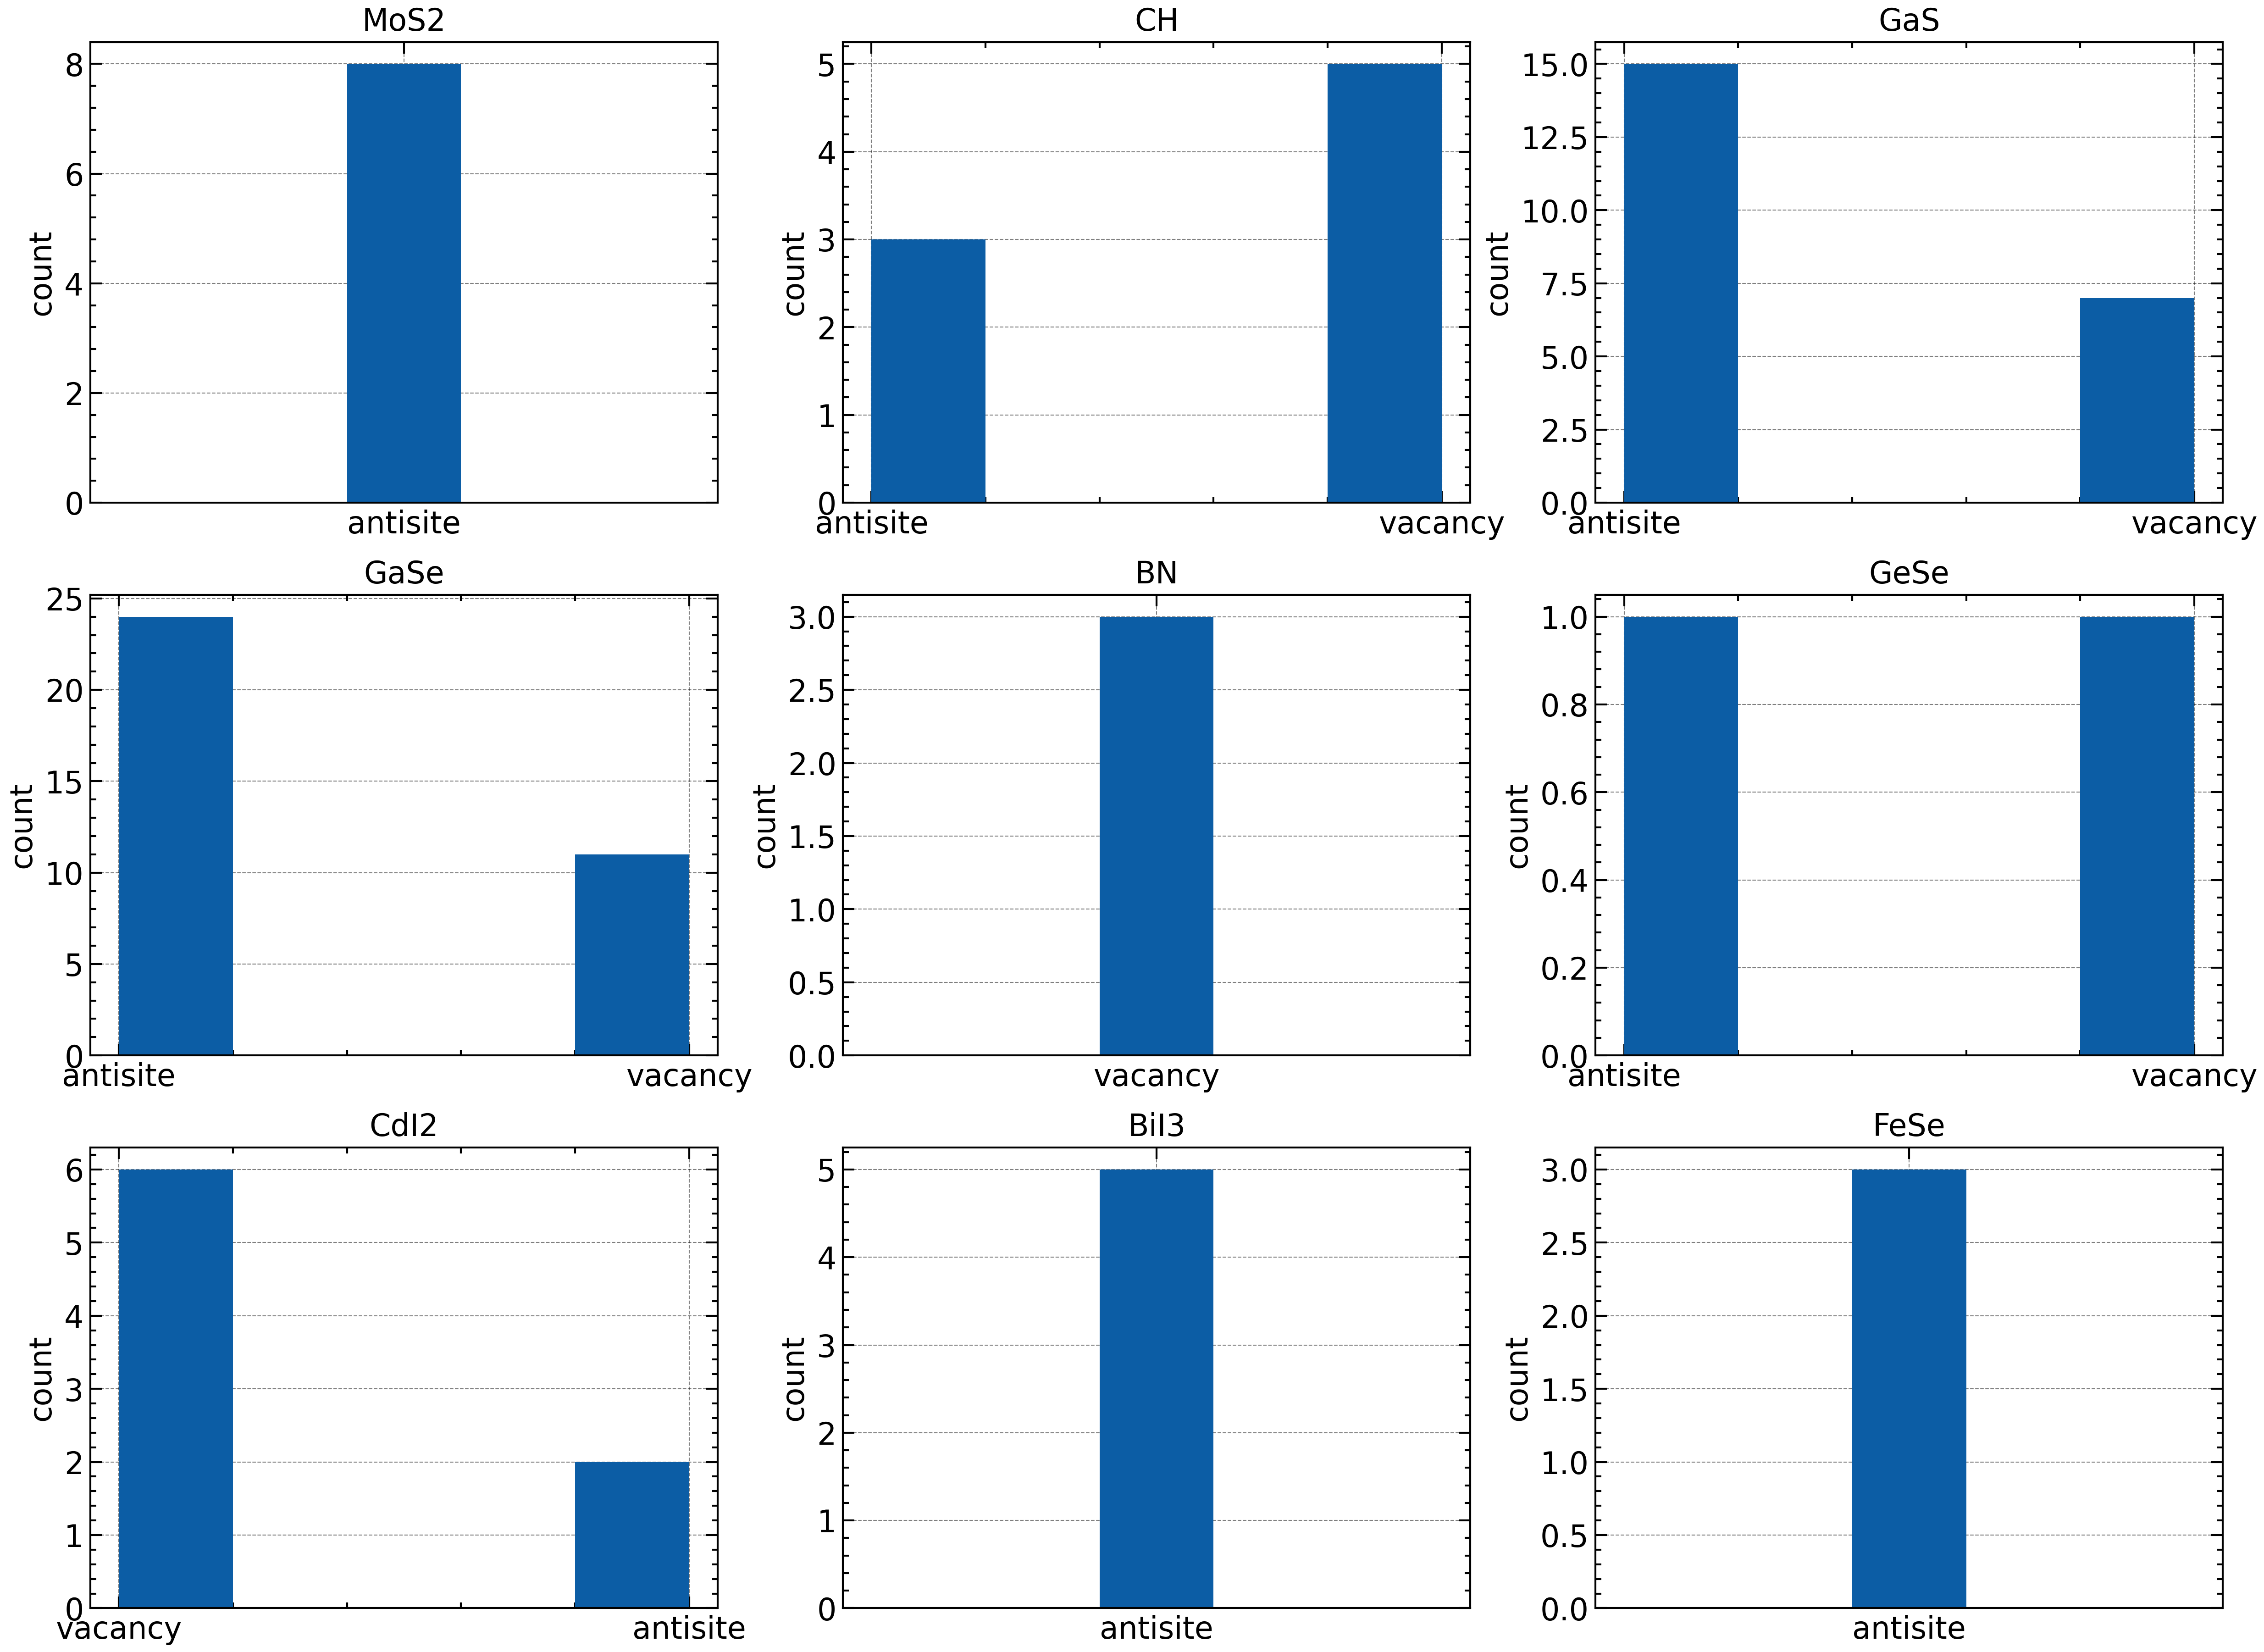

In [138]:
display(fig)

## heter host band components

In [150]:
diff_vbm_cbm = dd.loc[dd["is_vbm_cbm_same"].isin([0, None]), :]
fig = plt.figure(dpi=300, figsize=(20, 20))

for plt_idx, prototype in enumerate(diff_vbm_cbm["prototype"].unique().tolist()):
    print(plt_idx, prototype)
    ax = fig.add_subplot(4, 3, plt_idx+1)
    freq = diff_vbm_cbm.loc[diff_vbm_cbm["prototype"] == prototype, "defect_type"]
    display(diff_vbm_cbm.loc[diff_vbm_cbm["prototype"] == prototype, :])
    
    ax.hist(freq, bins=5, stacked=True)
    ax.set_title(prototype)
    ax.set_ylabel("count")
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))




0 GeSe


task_id is_vbm_cbm_same      c2db_uid prototype  gap_scan  hse_gap_nosoc  \
153      624           False  GaAs-GeSe-NM      GeSe    1.2461       1.724846   
156      639           False  GaAs-GeSe-NM      GeSe    1.2461       1.724846   
168      693           False   InP-GeSe-NM      GeSe    1.1360       1.784716   
175      710           False   InP-GeSe-NM      GeSe    1.1360       1.784716   
173      706           False  AlSb-GeSe-NM      GeSe    1.5499       2.004251   
171      703           False  AlSb-GeSe-NM      GeSe    1.5499       2.004251   
27       127           False  PbTe-GeSe-NM      GeSe    1.5979       2.222880   
55       246           False  GeTe-GeSe-NM      GeSe    1.8052       2.325294   
83       349           False  GeTe-GeSe-NM      GeSe    1.8052       2.325294   
192      771           False   GaP-GeSe-NM      GeSe    1.7872       2.372396   
189      762           False   GaP-GeSe-NM      GeSe    1.7872       2.372396   
122      505           False  SnTe-GeSe-NM      GeSe    1.8390       2.437283   
18       104           False  SnTe-GeSe-NM      GeSe    1.8390       2.437283   
60       280           False  PbSe-GeSe-NM      GeSe    2.0146       2.563349   
78       338           False  PbSe-GeSe-NM      GeSe    2.0146       2.563349   
126      512           False   PbS-GeSe-NM      GeSe    2.1654       2.825584   
33       147           False   PbS-GeSe-NM      GeSe    2.1654       2.825584   
28       131           False  SnSe-GeSe-NM      GeSe    2.2619       2.863765   
62       285           False  GeSe-GeSe-NM      GeSe    2.2797       2.978787   
74       330           False  GeSe-GeSe-NM      GeSe    2.2797       2.978787   
76       334           False   SnS-GeSe-NM      GeSe    2.3511       2.998714   
72       325           False   GeS-GeSe-NM      GeSe    2.4595       3.257409   

       defect_name defect_type  charge  mag  
153       vac_1_Ga     vacancy      -1  2.0  
156       vac_2_As     vacancy      -1  2.0  
168       vac_1_In     vacancy      -1  2.0  
175        vac_2_P     vacancy      -1  2.0  
173       vac_1_Al     vacancy      -1  2.0  
171       vac_2_Sb     vacancy      -1  2.0  
27        vac_2_Pb     vacancy       0  2.0  
55   as_1_Te_on_Ge    antisite       0  2.0  
83        vac_1_Ge     vacancy       0  2.0  
192       vac_1_Ga     vacancy      -1  2.0  
189        vac_2_P     vacancy      -1  2.0  
122  as_1_Te_on_Sn    antisite       0  2.0  
18        vac_1_Sn     vacancy       0  2.0  
60   as_1_Pb_on_Se    antisite       0  2.0  
78        vac_1_Pb     vacancy       0  2.0  
126   as_1_Pb_on_S    antisite       0  2.0  
33        vac_1_Pb     vacancy       0  2.0  
28        vac_1_Sn     vacancy       0  2.0  
62   as_1_Se_on_Ge    antisite       0  2.0  
74        vac_1_Ge     vacancy       0  2.0  
76        vac_1_Sn     vacancy       0  2.0  
72        vac_1_Ge     vacancy       0  2.0

1 CH


task_id is_vbm_cbm_same      c2db_uid prototype  gap_scan  hse_gap_nosoc  \
294     1337           False  Pb2Te2-CH-NM        CH    1.5508       1.801611   
287     1308           False  Pb2Te2-CH-NM        CH    1.5508       1.801611   
291     1320           False   Cd2S2-CH-NM        CH    1.6113       2.704395   
297     1348           False  Zn2Se2-CH-NM        CH    1.7897       2.763799   
303     1366           False   Zn2S2-CH-NM        CH    2.6130       3.787432   
300     1354           False   Zn2S2-CH-NM        CH    2.6130       3.787432   
486     2113           False    C2F2-CH-NM        CH    3.1199       4.922175   
479     2092           False    C2F2-CH-NM        CH    3.1199       4.922175   
296     1347            None   Tl2I2-CH-NM        CH    3.0241            NaN   
292     1329            None   Tl2I2-CH-NM        CH    3.0241            NaN   

       defect_name defect_type  charge  mag  
294  as_1_Pb_on_Te    antisite       0  2.0  
287       vac_1_Te     vacancy       0  2.0  
291       vac_1_Cd     vacancy       0  2.0  
297  as_1_Zn_on_Se    antisite       0  2.0  
303   as_1_Zn_on_S    antisite       0  2.0  
300       vac_1_Zn     vacancy       0  2.0  
486        vac_1_C     vacancy       0  2.0  
479        vac_2_F     vacancy       1  2.0  
296   as_1_I_on_Tl    antisite       0  2.0  
292   as_1_Tl_on_I    antisite       0  2.0

2 GaS


task_id is_vbm_cbm_same       c2db_uid prototype  gap_scan  \
490     2125           False   Al2O2-GaS-NM       GaS    1.2084   
277     1095           False  Ga2Te2-GaS-NM       GaS    1.5510   
258     1037           False  Ga2Te2-GaS-NM       GaS    1.5510   
183      741           False  Ga2Te2-GaS-NM       GaS    1.5510   
219      913           False  Ga2Se2-GaS-NM       GaS    2.0183   
218      902           False  Ga2Se2-GaS-NM       GaS    2.0183   
141      591           False  Ga2Se2-GaS-NM       GaS    2.0183   
235      978           False   Ga2S2-GaS-NM       GaS    2.4565   
223      940           False   Ga2S2-GaS-NM       GaS    2.4565   
161      654           False   Ga2S2-GaS-NM       GaS    2.4565   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
490       1.850685   as_1_Al_on_O    antisite      -1  2.0  
277       2.005683  as_1_Ga_on_Te    antisite       1  2.0  
258       2.005683  as_1_Te_on_Ga    antisite      -1  2.0  
183       2.005683       vac_1_Ga     vacancy       1  2.0  
219       2.527861  as_1_Ga_on_Se    antisite       1  2.0  
218       2.527861  as_1_Se_on_Ga    antisite      -1  2.0  
141       2.527861       vac_1_Ga     vacancy       1  2.0  
235       3.199461   as_1_Ga_on_S    antisite       1  2.0  
223       3.199461   as_1_S_on_Ga    antisite      -1  2.0  
161       3.199461       vac_1_Ga     vacancy       1  2.0

3 TiCl3


task_id is_vbm_cbm_same         c2db_uid prototype  gap_scan  \
817     3418           False   Al2I6-TiCl3-NM     TiCl3    1.2663   
816     3415           False  Tl2Br6-TiCl3-NM     TiCl3    1.3172   
819     3423           False  Ga2Br6-TiCl3-NM     TiCl3    1.6747   
824     3431           False  In2Br6-TiCl3-NM     TiCl3    2.2046   
808     3386           False   Bi2I6-TiCl3-NM     TiCl3    2.4479   
698     2934           False  Al2Br6-TiCl3-NM     TiCl3    2.9134   
986     4069           False  Al2Br6-TiCl3-NM     TiCl3    2.9134   
821     3426           False  Ga2Cl6-TiCl3-NM     TiCl3    2.7545   
818     3420           False    Y2I6-TiCl3-NM     TiCl3    2.2757   
812     3392           False  Al2Cl6-TiCl3-NM     TiCl3    4.1046   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
817       1.939598   as_1_I_on_Al    antisite       0  2.0  
816       2.041306  as_1_Br_on_Tl    antisite       0  2.0  
819       2.479430  as_1_Br_on_Ga    antisite       0  2.0  
824       3.144006  as_1_Br_on_In    antisite       0  2.0  
808       3.221688   as_1_I_on_Bi    antisite       0  2.0  
698       3.721265  as_1_Br_on_Al    antisite       0  2.0  
986       3.721265       vac_1_Al     vacancy      -1  2.0  
821       3.820890  as_1_Cl_on_Ga    antisite       0  2.0  
818       3.835716    as_1_I_on_Y    antisite       0  2.0  
812       5.276350  as_1_Cl_on_Al    antisite       0  2.0

4 GaSe


task_id is_vbm_cbm_same        c2db_uid prototype  gap_scan  \
246     1006           False  Ga2Te2-GaSe-NM      GaSe    1.4893   
386     1692           False  Ga2Te2-GaSe-NM      GaSe    1.4893   
247     1007           False  Ga2Te2-GaSe-NM      GaSe    1.4893   
388     1700           False  Ga2Te2-GaSe-NM      GaSe    1.4893   
197      784           False  Ga2Te2-GaSe-NM      GaSe    1.4893   
324     1472           False  Ga2Te2-GaSe-NM      GaSe    1.4893   
242      996           False  Ga2Se2-GaSe-NM      GaSe    1.8335   
374     1660           False  Ga2Se2-GaSe-NM      GaSe    1.8335   
243      999           False  Ga2Se2-GaSe-NM      GaSe    1.8335   
381     1676           False  Ga2Se2-GaSe-NM      GaSe    1.8335   
146      607           False  Ga2Se2-GaSe-NM      GaSe    1.8335   
308     1416           False  Ga2Se2-GaSe-NM      GaSe    1.8335   
272     1089           False   Ga2S2-GaSe-NM      GaSe    2.4147   
339     1530           False   Ga2S2-GaSe-NM      GaSe    2.4147   
271     1086           False   Ga2S2-GaSe-NM      GaSe    2.4147   
358     1592           False   Ga2S2-GaSe-NM      GaSe    2.4147   
392     1719           False   Ga2S2-GaSe-NM      GaSe    2.4147   
414     1826           False   Ga2S2-GaSe-NM      GaSe    2.4147   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
246       1.956031  as_1_Ga_on_Te    antisite       1  2.0  
386       1.956031  as_1_Ga_on_Te    antisite       1  2.0  
247       1.956031  as_1_Te_on_Ga    antisite      -1  2.0  
388       1.956031  as_1_Te_on_Ga    antisite      -1  2.0  
197       1.956031       vac_1_Ga     vacancy       1  2.0  
324       1.956031       vac_1_Ga     vacancy       1  2.0  
242       2.386467  as_1_Ga_on_Se    antisite       1  2.0  
374       2.386467  as_1_Ga_on_Se    antisite       1  2.0  
243       2.386467  as_1_Se_on_Ga    antisite      -1  2.0  
381       2.386467  as_1_Se_on_Ga    antisite      -1  2.0  
146       2.386467       vac_1_Ga     vacancy       1  2.0  
308       2.386467       vac_1_Ga     vacancy       1  2.0  
272       3.046107   as_1_Ga_on_S    antisite       1  2.0  
339       3.046107   as_1_Ga_on_S    antisite       1  2.0  
271       3.046107   as_1_S_on_Ga    antisite      -1  2.0  
358       3.046107   as_1_S_on_Ga    antisite      -1  2.0  
392       3.046107       vac_1_Ga     vacancy       1  2.0  
414       3.046107       vac_1_Ga     vacancy       1  2.0

5 MoS2


task_id is_vbm_cbm_same       c2db_uid prototype  gap_scan  \
878     3648           False   ZnI2-MoS2-NM      MoS2    1.1539   
784     3280           False  PbSe2-MoS2-NM      MoS2    1.6878   
804     3377           False  PbSe2-MoS2-NM      MoS2    1.6878   
875     3645           False  HgBr2-MoS2-NM      MoS2    1.6542   
867     3594           False   CdI2-MoS2-NM      MoS2    1.6964   
877     3647           False   SnI2-MoS2-NM      MoS2    1.9701   
776     3255           False   PbS2-MoS2-NM      MoS2    2.0488   
831     3449           False   PbS2-MoS2-NM      MoS2    2.0488   
838     3486           False  HgCl2-MoS2-NM      MoS2    2.0190   
832     3468           False   PbI2-MoS2-NM      MoS2    2.3774   
862     3575           False  SnBr2-MoS2-NM      MoS2    2.4077   
835     3472           False  Br2Ge-MoS2-NM      MoS2    2.5366   
876     3646           False  CdBr2-MoS2-NM      MoS2    2.4633   
861     3572           False  SnCl2-MoS2-NM      MoS2    2.6503   
879     3651           False  ZnBr2-MoS2-NM      MoS2    2.5942   
869     3619           False   MgI2-MoS2-NM      MoS2    2.9134   
865     3590           False  PbCl2-MoS2-NM      MoS2    3.2687   
868     3618           False   CaI2-MoS2-NM      MoS2    3.0737   
809     3387           False   BaI2-MoS2-NM      MoS2    3.0979   
848     3527           False   SrI2-MoS2-NM      MoS2    3.3722   
885     3675           False  ZnCl2-MoS2-NM      MoS2    3.4767   
880     3655           False  MgBr2-MoS2-NM      MoS2    3.7410   
836     3473           False  BaBr2-MoS2-NM      MoS2    3.9672   
840     3494           False  SrBr2-MoS2-NM      MoS2    3.8197   
834     3470           False  CaBr2-MoS2-NM      MoS2    4.0598   
870     3620           False  BaCl2-MoS2-NM      MoS2    4.5240   
888     3691           False  MgCl2-MoS2-NM      MoS2    4.7609   
837     3478           False  SrCl2-MoS2-NM      MoS2    4.2993   
833     3469           False  CaCl2-MoS2-NM      MoS2    4.6735   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
878       2.067731       vac_1_Zn     vacancy       0  2.0  
784       2.658036  as_1_Se_on_Pb    antisite       0  2.0  
804       2.658036       vac_1_Pb     vacancy       0  2.0  
875       2.671914       vac_1_Hg     vacancy       0  2.0  
867       2.706832       vac_1_Cd     vacancy       0  2.0  
877       2.739276       vac_1_Sn     vacancy       0  2.0  
776       3.103852   as_1_S_on_Pb    antisite       0  2.0  
831       3.103852       vac_1_Pb     vacancy       0  2.0  
838       3.255830       vac_1_Hg     vacancy       0  2.0  
832       3.291795       vac_1_Pb     vacancy       0  2.0  
862       3.326040       vac_1_Sn     vacancy       0  2.0  
835       3.447190       vac_1_Ge     vacancy       0  2.0  
876       3.563749       vac_1_Cd     vacancy       0  2.0  
861       3.591706       vac_1_Sn     vacancy       0  2.0  
879       3.646811       vac_1_Zn     vacancy       0  2.0  
869       3.871178       vac_1_Mg     vacancy       0  2.0  
865       4.370487       vac_1_Pb     vacancy       0  2.0  
868       4.447182       vac_1_Ca     vacancy       0  2.0  
809       4.491135       vac_1_Ba     vacancy       0  2.0  
848       4.682596       vac_1_Sr     vacancy       0  2.0  
885       4.767981       vac_1_Zn     vacancy       0  2.0  
880       4.856562       vac_1_Mg     vacancy       0  2.0  
836       5.384230       vac_1_Ba     vacancy       0  2.0  
840       5.447759       vac_1_Sr     vacancy       0  2.0  
834       5.614289       vac_1_Ca     vacancy       0  2.0  
870       6.105137       vac_1_Ba     vacancy       0  2.0  
888       6.108373       vac_1_Mg     vacancy       0  2.0  
837       6.207640       vac_1_Sr     vacancy       0  2.0  
833       6.386840       vac_1_Ca     vacancy       0  2.0

6 BiI3


task_id is_vbm_cbm_same        c2db_uid prototype  gap_scan  \
800     3359           False   Ga2I6-BiI3-NM      BiI3    1.4913   
699     2936           False   Ir2I6-BiI3-NM      BiI3    1.5943   
825     3433           False   In2I6-BiI3-NM      BiI3    1.9024   
793     3328           False  Tl2Br6-BiI3-NM      BiI3    1.8941   
789     3308           False   I6Sb2-BiI3-NM      BiI3    2.2199   
697     2933           False   Bi2I6-BiI3-NM      BiI3    2.5352   
798     3353           False   Al2I6-BiI3-NM      BiI3    2.5723   
797     3350           False  As2Br6-BiI3-NM      BiI3    1.9321   
792     3314           False  Tl2Cl6-BiI3-NM      BiI3    2.5819   
707     2971           False  Ga2Br6-BiI3-NM      BiI3    2.8849   
790     3310           False  Bi2Br6-BiI3-NM      BiI3    2.9322   
802     3369           False   Sc2I6-BiI3-NM      BiI3    2.1417   
823     3429           False  In2Br6-BiI3-NM      BiI3    3.0518   
795     3331           False    Y2I6-BiI3-NM      BiI3    2.7454   
814     3407           False  Sc2Br6-BiI3-NM      BiI3    3.1196   
811     3389           False  In2Cl6-BiI3-NM      BiI3    3.9834   
701     2949           False  Ga2Cl6-BiI3-NM      BiI3    4.1869   
696     2930           False  Al2Br6-BiI3-NM      BiI3    4.3053   
799     3354           False   Y2Br6-BiI3-NM      BiI3    3.9175   
719     3001           False  Sc2Cl6-BiI3-NM      BiI3    4.0001   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
800       2.149071   as_1_I_on_Ga    antisite       0  2.0  
699       2.600032   as_1_I_on_Ir    antisite       0  2.0  
825       2.682527   as_1_I_on_In    antisite       0  2.0  
793       2.699830  as_1_Br_on_Tl    antisite       0  2.0  
789       2.850669   as_1_I_on_Sb    antisite       0  2.0  
697       3.275310   as_1_I_on_Bi    antisite       0  2.0  
798       3.296733   as_1_I_on_Al    antisite       0  2.0  
797       3.375340  as_1_Br_on_As    antisite       0  2.0  
792       3.564838  as_1_Cl_on_Tl    antisite       0  2.0  
707       3.740071  as_1_Br_on_Ga    antisite       0  2.0  
790       3.771891  as_1_Br_on_Bi    antisite       0  2.0  
802       3.843326   as_1_I_on_Sc    antisite       0  2.0  
823       3.958691  as_1_Br_on_In    antisite       0  2.0  
795       4.288081    as_1_I_on_Y    antisite       0  2.0  
814       5.010688  as_1_Br_on_Sc    antisite       0  2.0  
811       5.123492  as_1_Cl_on_In    antisite       0  2.0  
701       5.197110  as_1_Cl_on_Ga    antisite       0  2.0  
696       5.232446  as_1_Br_on_Al    antisite       0  2.0  
799       5.630214   as_1_Br_on_Y    antisite       0  2.0  
719       6.002782  as_1_Cl_on_Sc    antisite       0  2.0

7 CdI2


task_id is_vbm_cbm_same       c2db_uid prototype  gap_scan  \
703     2961           False   SnS2-CdI2-NM      CdI2    1.6908   
859     3569           False   SnI2-CdI2-NM      CdI2    1.7921   
904     3749           False   GeI2-CdI2-NM      CdI2    1.9965   
854     3552           False   ZnI2-CdI2-NM      CdI2    1.9267   
895     3713           False  SnBr2-CdI2-NM      CdI2    2.0238   
882     3658           False  HgBr2-CdI2-NM      CdI2    2.0057   
920     3799           False  Br2Ge-CdI2-NM      CdI2    2.2220   
884     3674           False   PbI2-CdI2-NM      CdI2    2.2425   
855     3560           False  SnCl2-CdI2-NM      CdI2    2.1332   
909     3768           False   CdI2-CdI2-NM      CdI2    2.3342   
886     3677           False  PbBr2-CdI2-NM      CdI2    2.4651   
889     3693           False  Cl2Ge-CdI2-NM      CdI2    2.5055   
896     3716           False  HgCl2-CdI2-NM      CdI2    2.3648   
911     3775           False  PbCl2-CdI2-NM      CdI2    2.7093   
902     3741           False  CdBr2-CdI2-NM      CdI2    3.1576   
907     3760           False   MgI2-CdI2-NM      CdI2    3.6167   
919     3795           False  ZnBr2-CdI2-NM      CdI2    3.4786   
906     3758           False   BaI2-CdI2-NM      CdI2    3.9095   
850     3532           False  CdCl2-CdI2-NM      CdI2    3.7857   
910     3774           False   SrI2-CdI2-NM      CdI2    3.9074   
899     3730           False  MgBr2-CdI2-NM      CdI2    4.8368   
891     3700           False  ZnCl2-CdI2-NM      CdI2    4.4942   
915     3789           False  BaBr2-CdI2-NM      CdI2    4.8068   
898     3723           False  SrBr2-CdI2-NM      CdI2    4.4774   
903     3745           False  CaBr2-CdI2-NM      CdI2    4.9201   
892     3702           False  BaCl2-CdI2-NM      CdI2    5.4595   
913     3781           False  SrCl2-CdI2-NM      CdI2    5.1806   
851     3537           False  MgCl2-CdI2-NM      CdI2    5.9952   
893     3703           False  CaCl2-CdI2-NM      CdI2    5.7187   

     hse_gap_nosoc   defect_name defect_type  charge  mag  
703       2.361786  as_1_Sn_on_S    antisite       0  2.0  
859       2.676717      vac_1_Sn     vacancy       0  2.0  
904       2.819113      vac_1_Ge     vacancy       0  2.0  
854       2.886343      vac_1_Zn     vacancy       0  2.0  
895       2.930619      vac_1_Sn     vacancy       0  2.0  
882       3.060726      vac_1_Hg     vacancy       0  2.0  
920       3.186569      vac_1_Ge     vacancy       0  2.0  
884       3.197034      vac_1_Pb     vacancy       0  2.0  
855       3.229226      vac_1_Sn     vacancy       0  2.0  
909       3.346202      vac_1_Cd     vacancy       0  2.0  
886       3.549341      vac_1_Pb     vacancy       0  2.0  
889       3.594589      vac_1_Ge     vacancy       0  2.0  
896       3.671525      vac_1_Hg     vacancy       0  2.0  
911       3.990243      vac_1_Pb     vacancy       0  2.0  
902       4.321128      vac_1_Cd     vacancy       0  2.0  
907       4.599627      vac_1_Mg     vacancy       0  2.0  
919       4.673886      vac_1_Zn     vacancy       0  2.0  
906       5.165012      vac_1_Ba     vacancy       0  2.0  
850       5.201412      vac_1_Cd     vacancy       0  2.0  
910       5.388729      vac_1_Sr     vacancy       0  2.0  
899       5.931051      vac_1_Mg     vacancy       0  2.0  
891       5.931936      vac_1_Zn     vacancy       0  2.0  
915       6.114947      vac_1_Ba     vacancy       0  2.0  
898       6.146551      vac_1_Sr     vacancy       0  2.0  
903       6.451690      vac_1_Ca     vacancy       0  2.0  
892       6.925898      vac_1_Ba     vacancy       0  2.0  
913       7.053662      vac_1_Sr     vacancy       0  2.0  
851       7.338506      vac_1_Mg     vacancy       0  2.0  
893       7.446433      vac_1_Ca     vacancy       0  2.0

8 FeSe


task_id is_vbm_cbm_same        c2db_uid prototype  gap_scan  \
753     3156           False   In2I2-FeSe-NM      FeSe    1.6782   
749     3143           False   In2I2-FeSe-NM      FeSe    1.6782   
706     2967           False   Ga2I2-FeSe-NM      FeSe    1.6637   
711     2983           False   Ga2I2-FeSe-NM      FeSe    1.6637   
756     3171           False  In2Cl2-FeSe-NM      FeSe    2.0715   
739     3106           False   Tl2I2-FeSe-NM      FeSe    2.1666   
737     3101           False   Tl2I2-FeSe-NM      FeSe    2.1666   
717     2996           False  Ag2Cl2-FeSe-NM      FeSe    1.5024   
740     3107           False  Tl2Br2-FeSe-NM      FeSe    2.6398   
742     3111           False  Tl2Br2-FeSe-NM      FeSe    2.6398   
722     3032           False   Rb2I2-FeSe-NM      FeSe    3.6807   
743     3120           False  Cs2Br2-FeSe-NM      FeSe    4.5296   
721     3031           False  Rb2Br2-FeSe-NM      FeSe    4.0679   
713     2988           False   K2Br2-FeSe-NM      FeSe    4.5322   
720     3026           False  Cs2Cl2-FeSe-NM      FeSe    4.7624   
724     3036           False  Cs2Cl2-FeSe-NM      FeSe    4.7624   
714     2989           False  Rb2Cl2-FeSe-NM      FeSe    4.5950   
745     3122           False   K2Cl2-FeSe-NM      FeSe    4.9674   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
753       2.419714   as_1_I_on_In    antisite       0  2.0  
749       2.419714   as_1_In_on_I    antisite       0  2.0  
706       2.450590   as_1_Ga_on_I    antisite       0  2.0  
711       2.450590   as_1_I_on_Ga    antisite       0  2.0  
756       3.040682  as_1_Cl_on_In    antisite       0  2.0  
739       3.060428   as_1_I_on_Tl    antisite       0  2.0  
737       3.060428   as_1_Tl_on_I    antisite       0  2.0  
717       3.523594  as_1_Cl_on_Ag    antisite       0  2.0  
740       3.531813  as_1_Br_on_Tl    antisite       0  2.0  
742       3.531813  as_1_Tl_on_Br    antisite       0  2.0  
722       4.889175   as_1_I_on_Rb    antisite       0  2.0  
743       5.323946  as_1_Br_on_Cs    antisite       0  2.0  
721       5.396217  as_1_Br_on_Rb    antisite       0  2.0  
713       5.570363   as_1_Br_on_K    antisite       0  2.0  
720       5.703142  as_1_Cl_on_Cs    antisite       0  2.0  
724       5.703142  as_1_Cs_on_Cl    antisite       0  2.0  
714       5.926513  as_1_Cl_on_Rb    antisite       0  2.0  
745       6.148733   as_1_Cl_on_K    antisite       0  2.0

9 GeS2


task_id is_vbm_cbm_same       c2db_uid prototype  gap_scan  \
731     3076           False   HgI2-GeS2-NM      GeS2    1.7552   
775     3251           False  HgBr2-GeS2-NM      GeS2    2.0307   
777     3265           False   CdI2-GeS2-NM      GeS2    2.4911   
770     3226           False   ZnI2-GeS2-NM      GeS2    2.7478   
732     3077           False  HgCl2-GeS2-NM      GeS2    2.3924   
730     3074           False  CdBr2-GeS2-NM      GeS2    3.0040   
735     3087           False  ZnBr2-GeS2-NM      GeS2    3.4878   
727     3063           False  CdCl2-GeS2-NM      GeS2    3.5565   
769     3223           False   SrI2-GeS2-NM      GeS2    3.5871   
729     3071           False   BaI2-GeS2-NM      GeS2    3.9973   
778     3266           False   CaI2-GeS2-NM      GeS2    3.9673   
726     3062           False  BaBr2-GeS2-NM      GeS2    4.5495   
733     3078           False  SrBr2-GeS2-NM      GeS2    4.2062   
765     3219           False  BaCl2-GeS2-NM      GeS2    5.1884   

     hse_gap_nosoc defect_name defect_type  charge  mag  
731       2.716354    vac_1_Hg     vacancy       0  2.0  
775       3.199317    vac_1_Hg     vacancy       0  2.0  
777       3.585504    vac_1_Cd     vacancy       0  2.0  
770       3.668625    vac_1_Zn     vacancy       0  2.0  
732       3.756964    vac_1_Hg     vacancy       0  2.0  
730       4.232495    vac_1_Cd     vacancy       0  2.0  
735       4.606213    vac_1_Zn     vacancy       0  2.0  
727       5.012256    vac_1_Cd     vacancy       0  2.0  
769       5.099842    vac_1_Sr     vacancy       0  2.0  
729       5.142240    vac_1_Ba     vacancy       0  2.0  
778       5.255324    vac_1_Ca     vacancy       0  2.0  
726       5.788647    vac_1_Ba     vacancy       0  2.0  
733       5.816091    vac_1_Sr     vacancy       0  2.0  
765       6.490905    vac_1_Ba     vacancy       0  2.0

10 AgBr3


task_id is_vbm_cbm_same         c2db_uid prototype  gap_scan  \
820     3425           False  Tl2Cl6-AgBr3-NM     AgBr3    1.7882   
694     2919           False  Bi2Br6-AgBr3-NM     AgBr3    2.7004   
839     3491           False  Bi2Cl6-AgBr3-NM     AgBr3    3.1167   
822     3428           False  In2Cl6-AgBr3-NM     AgBr3    3.0008   
813     3403           False   Y2Br6-AgBr3-NM     AgBr3    3.1579   
842     3503           False  Sc2Cl6-AgBr3-NM     AgBr3    3.2505   
710     2975           False   Y2Cl6-AgBr3-NM     AgBr3    4.1343   

     hse_gap_nosoc    defect_name defect_type  charge  mag  
820       2.781903  as_1_Cl_on_Tl    antisite       0  2.0  
694       3.537633  as_1_Br_on_Bi    antisite       0  2.0  
839       4.123039  as_1_Cl_on_Bi    antisite       0  2.0  
822       4.208040  as_1_Cl_on_In    antisite       0  2.0  
813       4.930940   as_1_Br_on_Y    antisite       0  2.0  
842       5.306213  as_1_Cl_on_Sc    antisite       0  2.0  
710       6.015598   as_1_Cl_on_Y    antisite       0  2.0

11 BN


task_id is_vbm_cbm_same   c2db_uid prototype  gap_scan  hse_gap_nosoc  \
131      523           False  GaN-BN-NM        BN    2.2126       3.091059   
155      631           False  GaN-BN-NM        BN    2.2126       3.091059   
137      580           False  GaN-BN-NM        BN    2.2126       3.091059   
188      759           False   BN-BN-NM        BN    4.8382       5.675463   

      defect_name defect_type  charge  mag  
131  as_1_N_on_Ga    antisite       0  2.0  
155      vac_1_Ga     vacancy      -1  2.0  
137       vac_2_N     vacancy      -1  2.0  
188       vac_1_B     vacancy      -1  2.0

In [154]:
display(diff_vbm_cbm.loc[diff_vbm_cbm["prototype"] == "BN", :])

task_id is_vbm_cbm_same   c2db_uid prototype  gap_scan  hse_gap_nosoc  \
131      523           False  GaN-BN-NM        BN    2.2126       3.091059   
155      631           False  GaN-BN-NM        BN    2.2126       3.091059   
137      580           False  GaN-BN-NM        BN    2.2126       3.091059   
188      759           False   BN-BN-NM        BN    4.8382       5.675463   

      defect_name defect_type  charge  mag  
131  as_1_N_on_Ga    antisite       0  2.0  
155      vac_1_Ga     vacancy      -1  2.0  
137       vac_2_N     vacancy      -1  2.0  
188       vac_1_B     vacancy      -1  2.0

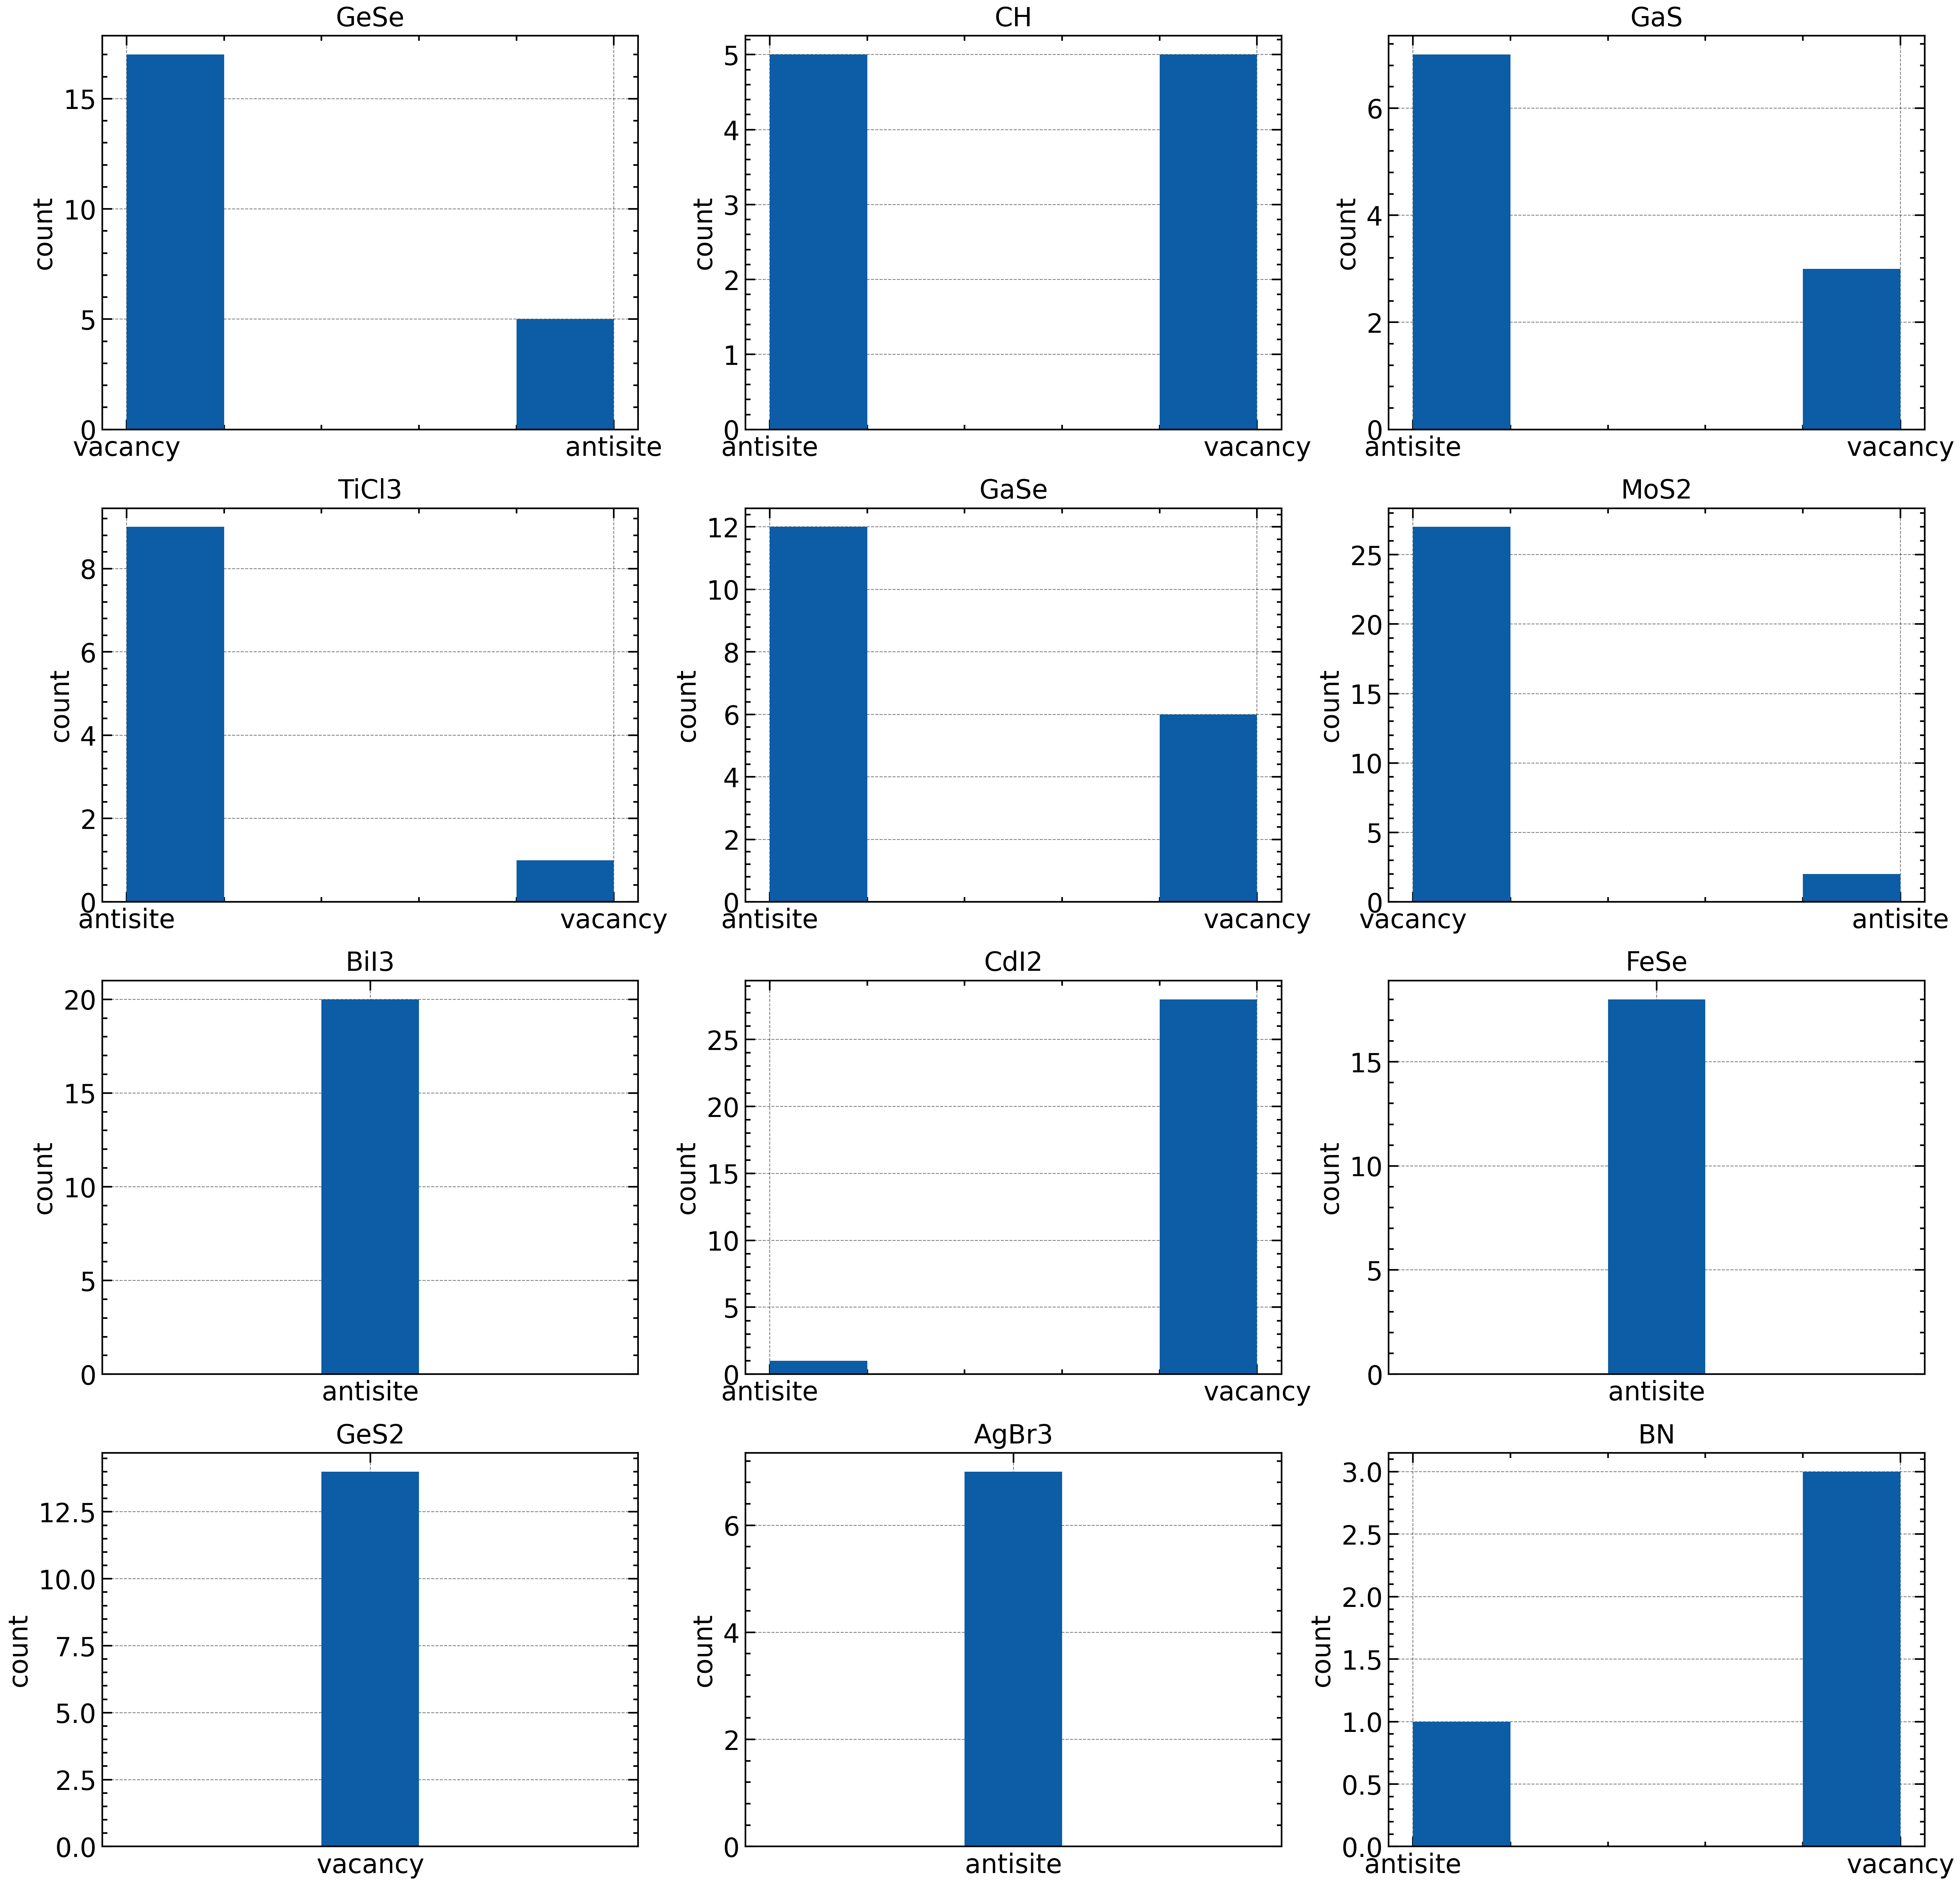

In [153]:
display(fig)

# Show qualified defect triplets

In [82]:
from atomate.vasp.database import VaspCalcDb
from pymatgen import Element
import pandas as pd
import os
from collections import Counter
import numpy as np
from qubitPack.qc_searching.analysis.main import get_defect_state
from qubitPack.tool_box import get_db

# db = VaspCalcDb.from_db_file('/Users/jeng-yuantsai/Research/project/symBaseBinaryQubit/calculations/'
#                              'search_triplet_from_defect_db/db.json')
defect_db = get_db("Scan2dDefect", "calc_data", port=1236)
ir_db = get_db("Scan2dDefect", "ir_data", port=1236)
# defect_db = get_db("antisiteQubit", "perturbed", port=1234)
host_db = get_db("Scan2dMat", "calc_data", port=1236)
#
# proj_path = '/Users/jeng-yuantsai/Research/project/symBaseBinaryQubit/calculations/search_triplet_from_defect_db'
# db_json = os.path.join(proj_path, "db.json")

# host_path = "/Users/jeng-yuantsai/Research/project/symBaseBinaryQubit/calculations/scan_relax_pc"
# db_host_json = os.path.join(host_path, "db.json")

# es = defect_db.collection.aggregate(
#     [
#         {"$match": {"task_label": "SCAN_nscf uniform"}},
#         {"$addFields":{"mag": {"$abs": {"$arrayElemAt": ["$calcs_reversed.output.outcar.total_magnetization",0]}}}},
#         {"$addFields":{"defect_name":"$defect_entry.name", "point_group":"$output.spacegroup.point_group"}},
#         {"$project": {"_id":0, "formula_pretty":1, "nsites":1, "elements":1,
#                       "mag":1, "charge_state":1, "chemsys":1, "defect_name":1,
#                       "point_group":1, "task_id":1, "pc_from_id": 1,
#         }},
#         {"$match":{"mag":{"$gte":1.9, "$lte":2.1}}},
#         {"$sort":{"mag":-1}},
#         # {"$group": {"_id":"$chemsys", "q": {"$push":"$charge_state"},"m": {"$push":"$formula_pretty"}, "nsites":{"$push":"$nsites"}}}
#     ]
# )
taskids = [int(i[0]) for i in output_df.iloc[:,1].tolist()]
print(taskids)
es = defect_db.collection.find({"task_id": {"$in": taskids}})

ess = []
for e in list(es)[:]:
    els = [Element(e["elements"][0]).group, Element(e["elements"][1]).group]
    els.sort()

    tk_id = e["task_id"]
    pc_from_id = e["pc_from_id"]
    defect_name = e["defect_name"]
    charge_state = e["charge_state"]
    e.update({"prototype": e["host_info"]["c2db_info"]["prototype"]})
    try:
        tot, proj, d_df, levels = get_defect_state(
            defect_db,
            {"task_id": tk_id},
            5, -5,
            None,
            False,
            "dist",
            (host_db, pc_from_id, 0, 0, 0),
            0.01,
            is_vacuum_aligment_on_plot=True,
            locpot_c2db=None,#(c2db, c2db_uid, 0)
            ir_db=ir_db,
            ir_entry_filter={"pc_from_id": pc_from_id, "defect_name": defect_name, "charge_state": charge_state},
        )

        print(d_df)
        if d_df.loc["triplet_from"][0] == "up" and d_df.loc["up_from_vbm"][0][-1] >= 0.2 and\
                d_df.loc["up_tran_en"][0] < 0.5 and d_df.loc["up_tran_en"][0] >= 0.2:
            e.update(d_df.to_dict()[0])
            e.update({"group": "{}_{}".format(els[0], els[1])})
        elif d_df.loc["triplet_from"][0] == "dn" and d_df.loc["dn_from_vbm"][0][-1] >= 0.2 and\
                d_df.loc["dn_tran_en"][0] < 0.5 and d_df.loc["dn_tran_en"][0] >= 0.2:
            e.update(d_df.to_dict()[0])
            e.update({"group": "{}_{}".format(els[0], els[1])})
        else:
            continue
        ess.append(e)

    except Exception as er:
        print(er)
        # print(er)
        # e.update(
        #     {
        #         "up_from_vbm": None,
        #         "up_occ": None,
        #         "dn_from_vbm": None,
        #         "dn_occ": None
        #     }
        # )
        continue
    # e.pop("elements")

df = pd.DataFrame(ess)#.sort_values(["group", "point_group", "charge_state"], inplace=False)

[2919, 3428, 3425, 3491, 3503, 3403, 2975, 523, 2930, 3353, 3350, 3310, 2933, 2971, 2949, 3359, 3429, 3389, 3433, 2936, 3308, 3407, 3001, 3369, 3328, 3314, 3354, 3331, 3385, 3374, 3446, 3295, 3388, 2113, 1320, 1337, 1308, 1347, 1329, 1366, 1354, 1348, 1280, 1306, 3789, 3702, 3758, 3745, 3703, 3741, 3532, 3768, 3799, 3693, 3749, 3658, 3716, 3730, 3537, 3760, 3677, 3775, 3674, 3713, 3560, 3569, 2961, 3723, 3781, 3774, 3795, 3700, 3552, 3738, 3722, 3567, 2962, 3199, 3561, 3694, 3709, 2996, 3120, 3026, 3036, 2967, 2983, 3171, 3156, 3143, 2988, 3122, 3031, 2989, 3032, 3107, 3111, 3106, 3101, 3091, 3153, 3121, 3062, 3219, 3071, 3266, 3074, 3063, 3265, 3251, 3077, 3076, 3078, 3223, 3087, 3226, 325, 285, 330, 246, 349, 512, 147, 280, 338, 334, 131, 505, 104, 127, 2153, 2159, 3473, 3620, 3387, 3470, 3469, 3618, 3646, 3594, 3472, 3645, 3486, 3655, 3691, 3619, 3590, 3468, 3255, 3449, 3280, 3377, 3575, 3572, 3647, 3494, 3478, 3527, 3651, 3675, 3648, 2974, 3222, 3278, 3237, 3239, 3298, 3282, 3292, 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                0
up_band_idx             [159, 158, 157, 155, 154]
up_from_vbm   [1.817, 1.801, 1.801, 1.773, 1.773]
up_occ                  [0.0, 0.0, 0.0, 0.0, 0.0]
dn_band_idx             [158, 157, 155, 153, 152]
dn_from_vbm      [1.829, 1.829, 1.79, 0.37, 0.37]
dn_occ                  [0.0, 0.0, 0.0, 0.0, 0.0]
up_deg                                  [1, 2, 2]
dn_deg                                  [2, 1, 2]
triplet_from                                   dn
up_tran_en                                      0
dn_tran_en                                      0
---task_id: 127---
total_mag:2.000
cbm:-2.153, vbm:-3.751, efermi:-3.164
{'1': {-3.396: True}, '-1': {-2.845: False, -2.846: False, -3.579: True, -3.741: True}}
                 3       4       0 spin orbital  adjacent antisite
band_index                                                        
153         0.0000  0.0000  0.0000    1       s    0.0000        1
153         0.0090  0.0091  0.0000    

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 131---
total_mag:2.000
cbm:-2.076, vbm:-4.338, efermi:-4.094
{'1': {}, '-1': {-3.902: False, -4.282: True}}
                27      15      30 spin orbital  adjacent antisite
band_index                                                        
153         0.0000  0.0000  0.0000   -1       s    0.0000       -1
153         0.0184  0.0925  0.0283   -1      pz    0.1392       -1
153         0.0000  0.0343  0.0402   -1      py    0.0745       -1
153         0.0305  0.0969  0.0042   -1      px    0.1316       -1
153         0.0000  0.0000  0.0000   -1     dz2    0.0000       -1
153         0.0000  0.0000  0.0000   -1     dyz    0.0000       -1
153         0.0000  0.0000  0.0000   -1     dxz    0.0000       -1
153         0.0000  0.0000  0.0000   -1     dxy    0.0000       -1
153         0.0000  0.0000  0.0000   -1  dx2-y2    0.0000       -1
152         0.0000  0.0000  0.0000   -1       s    0.0000       -1
152         0.0743  0.0000  0.0645   -1      pz    0.1388       -1
152      

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 147---
total_mag:2.000
cbm:-2.364, vbm:-4.530, efermi:-4.189
{'1': {-4.489: True, -4.513: True}, '-1': {-3.941: False, -3.942: False, -4.418: True, -4.462: True, -4.464: True, -4.482: True}}
                27      30      15 spin orbital  adjacent antisite
band_index                                                        
152         0.0000  0.0000  0.0000    1       s    0.0000        1
152         0.0000  0.0000  0.0000    1      pz    0.0000        1
152         0.0000  0.0000  0.0071    1      py    0.0071        1
152         0.0000  0.0075  0.0018    1      px    0.0093        1
152         0.0000  0.0000  0.0000    1     dz2    0.0000        1
152         0.0000  0.0000  0.0000    1     dyz    0.0000        1
152         0.0000  0.0000  0.0000    1     dxz    0.0000        1
152         0.0000  0.0000  0.0000    1     dxy    0.0000        1
152         0.0000  0.0000  0.0000    1  dx2-y2    0.0000        1
151         0.0000  0.0000  0.0000    1       s    0.0000   

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 246---
total_mag:2.000
cbm:-1.918, vbm:-3.723, efermi:-2.887
{'1': {-2.709: False, -3.069: True}, '-1': {-2.377: False, -2.405: False, -3.667: True}}
                27      15      30      31 spin orbital  adjacent  antisite
band_index                                                                 
157         0.0014  0.0014  0.0014  0.0246    1       s    0.0042    0.0246
157         0.0154  0.0154  0.0154  0.1840    1      pz    0.0462    0.1840
157         0.0089  0.0089  0.0358  0.0000    1      py    0.0536    0.0000
157         0.0268  0.0268  0.0000  0.0000    1      px    0.0536    0.0000
157         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
157         0.0000  0.0000  0.0010  0.0000    1     dyz    0.0010    0.0000
157         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0.0000
157         0.0010  0.0010  0.0000  0.0000    1     dxy    0.0020    0.0000
157         0.0000  0.0000  0.0014  0.0000    1  dx2-y2    0.0014    0.0000
15

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 280---
total_mag:2.000
cbm:-2.504, vbm:-4.519, efermi:-2.867
{'1': {-3.089: True, -3.832: True, -4.205: True, -4.338: True}, '-1': {-2.645: False, -3.522: True, -4.169: True, -4.31: True}}
                 4       5       0      16 spin orbital  adjacent  antisite
band_index                                                                 
164         0.0000  0.0000  0.0000  0.0000    1       s    0.0000    0.0000
164         0.0000  0.0238  0.0238  0.0000    1      pz    0.0476    0.0000
164         0.0000  0.0406  0.0094  0.1022    1      py    0.0500    0.1022
164         0.0000  0.0000  0.0312  0.0341    1      px    0.0312    0.0341
164         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
164         0.0000  0.0000  0.0000  0.0019    1     dyz    0.0000    0.0019
164         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0.0000
164         0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000    0.0000
164         0.0010  0.0000  0.0000  0.0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 285---
total_mag:2.000
cbm:-2.279, vbm:-4.558, efermi:-3.660
{'1': {-3.501: False, -3.825: True}, '-1': {-2.962: False, -3.114: False}}
                44      48      24      49 spin orbital  adjacent  antisite
band_index                                                                 
247         0.0018  0.0018  0.0018  0.0209    1       s    0.0054    0.0209
247         0.0208  0.0208  0.0208  0.2106    1      pz    0.0624    0.2106
247         0.0104  0.0417  0.0104  0.0000    1      py    0.0625    0.0000
247         0.0313  0.0000  0.0313  0.0000    1      px    0.0626    0.0000
247         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
247         0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000    0.0000
247         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0.0000
247         0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000    0.0000
247         0.0000  0.0011  0.0000  0.0000    1  dx2-y2    0.0011    0.0000
246         0.00

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 325---
total_mag:2.000
cbm:-2.402, vbm:-4.862, efermi:-4.357
{'1': {-4.684: True, -4.764: True, -4.85: True}, '-1': {-4.25: False, -4.456: True, -4.749: True, -4.793: True, -4.854: True}}
                44      48      24 spin orbital  adjacent antisite
band_index                                                        
243         0.0000  0.0000  0.0000    1       s    0.0000        1
243         0.0430  0.0904  0.0086    1      pz    0.1420        1
243         0.0012  0.0039  0.0000    1      py    0.0051        1
243         0.0000  0.0000  0.0000    1      px    0.0000        1
243         0.0000  0.0000  0.0000    1     dz2    0.0000        1
243         0.0000  0.0000  0.0000    1     dyz    0.0000        1
243         0.0000  0.0000  0.0000    1     dxz    0.0000        1
243         0.0000  0.0000  0.0000    1     dxy    0.0000        1
243         0.0000  0.0000  0.0000    1  dx2-y2    0.0000        1
242         0.0000  0.0000  0.0000    1       s    0.0000      

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 330---
total_mag:2.000
cbm:-2.306, vbm:-4.585, efermi:-4.313
{'1': {}, '-1': {-4.064: False, -4.538: True}}
                44      48      24 spin orbital  adjacent antisite
band_index                                                        
243         0.0000  0.0000  0.0000   -1       s    0.0000       -1
243         0.0000  0.0649  0.0530   -1      pz    0.1179       -1
243         0.0080  0.1186  0.0389   -1      py    0.1655       -1
243         0.0000  0.0013  0.0603   -1      px    0.0616       -1
243         0.0000  0.0000  0.0000   -1     dz2    0.0000       -1
243         0.0000  0.0000  0.0000   -1     dyz    0.0000       -1
243         0.0000  0.0000  0.0000   -1     dxz    0.0000       -1
243         0.0000  0.0000  0.0000   -1     dxy    0.0000       -1
243         0.0000  0.0000  0.0000   -1  dx2-y2    0.0000       -1
242         0.0000  0.0000  0.0000   -1       s    0.0000       -1
242         0.0783  0.0142  0.0261   -1      pz    0.1186       -1
242      

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 334---
total_mag:2.000
cbm:-2.263, vbm:-4.614, efermi:-4.083
{'1': {-4.386: True, -4.469: True, -4.494: True, -4.554: True, -4.588: True, -4.614: True}, '-1': {-4.003: False, -4.154: True, -4.38: True, -4.466: True, -4.559: True, -4.575: True, -4.608: True}}
                44      48      24 spin orbital  adjacent antisite
band_index                                                        
243         0.0000  0.0000  0.0000    1       s    0.0000        1
243         0.0102  0.0885  0.0385    1      pz    0.1372        1
243         0.0000  0.0000  0.0000    1      py    0.0000        1
243         0.0000  0.0000  0.0000    1      px    0.0000        1
243         0.0000  0.0000  0.0000    1     dz2    0.0000        1
243         0.0000  0.0000  0.0000    1     dyz    0.0000        1
243         0.0000  0.0000  0.0000    1     dxz    0.0000        1
243         0.0000  0.0000  0.0000    1     dxy    0.0000        1
243         0.0000  0.0000  0.0000    1  dx2-y2    0.0000  

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 338---
total_mag:2.000
cbm:-2.499, vbm:-4.513, efermi:-4.004
{'1': {-4.233: True, -4.363: True, -4.37: True}, '-1': {-3.616: False, -4.264: True, -4.322: True, -4.349: True, -4.376: True, -4.42: True}}
                27      30      15 spin orbital  adjacent antisite
band_index                                                        
153         0.0000  0.0000  0.0000    1       s    0.0000        1
153         0.0094  0.0023  0.0024    1      pz    0.0141        1
153         0.0153  0.0153  0.0034    1      py    0.0340        1
153         0.0459  0.0193  0.0312    1      px    0.0964        1
153         0.0000  0.0000  0.0000    1     dz2    0.0000        1
153         0.0000  0.0000  0.0000    1     dyz    0.0000        1
153         0.0000  0.0000  0.0000    1     dxz    0.0000        1
153         0.0000  0.0000  0.0000    1     dxy    0.0000        1
153         0.0000  0.0000  0.0000    1  dx2-y2    0.0000        1
152         0.0000  0.0000  0.0000    1       s  

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 349---
total_mag:2.000
cbm:-1.977, vbm:-3.782, efermi:-3.325
{'1': {-3.556: True}, '-1': {-3.05: False}}
                27      15      30 spin orbital  adjacent antisite
band_index                                                        
153         0.0000  0.0000  0.0000    1       s    0.0000        1
153         0.0000  0.0161  0.0161    1      pz    0.0322        1
153         0.0115  0.0390  0.0829    1      py    0.1334        1
153         0.0038  0.0477  0.0038    1      px    0.0553        1
153         0.0000  0.0000  0.0000    1     dz2    0.0000        1
153         0.0000  0.0000  0.0000    1     dyz    0.0000        1
153         0.0000  0.0000  0.0000    1     dxz    0.0000        1
153         0.0000  0.0000  0.0000    1     dxy    0.0000        1
153         0.0000  0.0000  0.0000    1  dx2-y2    0.0000        1
152         0.0000  0.0000  0.0000    1       s    0.0000        1
152         0.0214  0.0054  0.0054    1      pz    0.0322        1
152         

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



total_mag:2.000
cbm:-1.495, vbm:-3.334, efermi:-2.755
{'1': {-1.504: False, -1.539: False, -1.547: False, -2.627: False, -2.89: True}, '-1': {-1.529: False, -1.53: False, -2.143: False, -2.314: False}}
                27      15      30      31 spin orbital  adjacent  antisite
band_index                                                                 
162         0.0000  0.0000  0.0000  0.0000    1       s    0.0000    0.0000
162         0.0012  0.0094  0.0039  0.0000    1      pz    0.0145    0.0000
162         0.0016  0.0000  0.0000  0.0000    1      py    0.0016    0.0000
162         0.0011  0.0000  0.0018  0.0000    1      px    0.0029    0.0000
162         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
162         0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000    0.0000
162         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0.0000
162         0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000    0.0000
162         0.0000  0.0000  0.0000  0.

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 512---
total_mag:2.000
cbm:-2.432, vbm:-4.597, efermi:-2.942
{'1': {-3.176: True, -3.887: True, -4.386: True}, '-1': {-2.683: False, -3.567: True, -4.357: True, -4.595: True}}
                 4       5       0      16 spin orbital  adjacent  antisite
band_index                                                                 
164         0.0000  0.0000  0.0000  0.0000    1       s    0.0000    0.0000
164         0.0000  0.0318  0.0317  0.0000    1      pz    0.0635    0.0000
164         0.0000  0.0355  0.0073  0.1130    1      py    0.0428    0.1130
164         0.0000  0.0000  0.0283  0.0376    1      px    0.0283    0.0376
164         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
164         0.0000  0.0000  0.0000  0.0021    1     dyz    0.0000    0.0021
164         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0.0000
164         0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000    0.0000
164         0.0011  0.0000  0.0000  0.0000    1  dx2

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 523---
total_mag:2.000
cbm:-2.302, vbm:-4.514, efermi:-2.714
{'1': {-2.791: True, -3.116: True}, '-1': {-2.638: False}}
                28      48      24      49 spin orbital  adjacent  antisite
band_index                                                                 
221         0.0192  0.0192  0.0192  0.0216    1       s    0.0576    0.0216
221         0.0000  0.0000  0.0000  0.0000    1      pz    0.0000    0.0000
221         0.0000  0.0000  0.0000  0.0000    1      py    0.0000    0.0000
221         0.0000  0.0000  0.0000  0.0000    1      px    0.0000    0.0000
221         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
221         0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000    0.0000
221         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0.0000
221         0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000    0.0000
221         0.0000  0.0000  0.0000  0.0000    1  dx2-y2    0.0000    0.0000
220         0.0000  0.0000  0.00

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 1280---
total_mag:2.000
cbm:-3.084, vbm:-4.407, efermi:-3.342
{'1': {-4.319: True}, '-1': {}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 1306---
total_mag:2.000
cbm:-1.959, vbm:-4.159, efermi:-3.182
{'1': {-3.788: True}, '-1': {}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 1308---
total_mag:2.000
cbm:-2.298, vbm:-3.849, efermi:-3.494
{'1': {-2.635: False, -2.648: False, -2.8: False, -3.151: False, -3.397: False, -3.599: True}, '-1': {-2.549: False, -2.56: False, -2.596: False, -2.6: False, -2.601: False, -2.731: False, -3.253: False, -3.274: False}}
                29      27      30 spin orbital  adjacent antisite
band_index                                                        
194         0.0054  0.0055  0.0054    1       s    0.0163        1
194         0.0000  0.0000  0.0000    1      pz    0.0000        1
194         0.0118  0.0119  0.0474    1      py    0.0711        1
194         0.0355  0.0356  0.0000    1      px    0.

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 1320---
total_mag:2.000
cbm:-4.071, vbm:-5.683, efermi:-5.199
{'1': {-5.532: True}, '-1': {-5.007: False, -5.394: True, -5.568: True}}
                48      59      47 spin orbital  adjacent antisite
band_index                                                        
280         0.0000  0.0000  0.0000    1       s    0.0000        1
280         0.0022  0.0022  0.0000    1      pz    0.0044        1
280         0.0323  0.0202  0.0112    1      py    0.0637        1
280         0.0035  0.0152  0.0035    1      px    0.0222        1
280         0.0000  0.0000  0.0000    1     dz2    0.0000        1
280         0.0000  0.0000  0.0000    1     dyz    0.0000        1
280         0.0000  0.0000  0.0000    1     dxz    0.0000        1
280         0.0000  0.0000  0.0000    1     dxy    0.0000        1
280         0.0000  0.0000  0.0000    1  dx2-y2    0.0000        1
279         0.0000  0.0000  0.0000    1       s    0.0000        1
279         0.0000  0.0000  0.0029    1      pz  

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 1329---
total_mag:2.000
cbm:-1.340, vbm:-4.364, efermi:-2.037
{'1': {-1.707: False, -2.178: True, -2.433: True, -4.094: True, -4.332: True}, '-1': {-1.443: False, -1.657: False, -1.896: False, -4.084: True, -4.317: True}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 1337---
total_mag:2.000
cbm:-2.308, vbm:-3.858, efermi:-3.779
{'1': {-2.849: False, -2.915: False, -3.059: False, -3.067: False, -3.135: False}, '-1': {-2.595: False, -2.737: False, -3.004: False, -3.091: False, -3.562: False, -3.779: True}}
                27      29      30      35 spin orbital  adjacent  antisite
band_index                                                                 
200         0.0000  0.0000  0.0000  0.0061    1       s    0.0000    0.0061
200         0.0290  0.0289  0.0289  0.0785    1      pz    0.0868    0.0785
200         0.0021  0.0021  0.0086  0.0000    1      py    0.0128    0.0000
200         0.0064  0.0064  0.0000  0.0000    1      px    0.0128    0.0000
200

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 1347---
total_mag:2.000
cbm:-1.302, vbm:-4.326, efermi:-3.793
{'1': {-4.02: True, -4.072: True, -4.088: True, -4.169: True, -4.275: True}, '-1': {-3.298: False, -3.505: False, -4.069: True, -4.07: True, -4.243: True}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 1348---
total_mag:2.000
cbm:-2.457, vbm:-4.247, efermi:-2.758
{'1': {-2.987: True}, '-1': {}}
                28      17      16       0      32 spin orbital  adjacent  \
band_index                                                                  
291         0.0503  0.0503  0.0000  0.0000  0.0000    1       s    0.1006   
291         0.0019  0.0019  0.0000  0.0000  0.0000    1      pz    0.0038   
291         0.0083  0.0374  0.0000  0.0010  0.0795    1      py    0.0457   
291         0.0291  0.0000  0.0000  0.0000  0.0265    1      px    0.0291   
291         0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000   
291         0.0000  0.0013  0.0000  0.0015  0.0011    1     dyz    0.001

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 1354---
total_mag:2.000
cbm:-2.017, vbm:-4.630, efermi:-4.509
{'1': {-4.568: True}, '-1': {-4.464: False, -4.552: True}}
                48      59      47      31 spin orbital  adjacent  antisite
band_index                                                                 
282         0.0000  0.0000  0.0000  0.0000    1       s    0.0000    0.0000
282         0.0000  0.0000  0.0000  0.0000    1      pz    0.0000    0.0000
282         0.0116  0.0021  0.0116  0.0040    1      py    0.0253    0.0040
282         0.0131  0.0224  0.0344  0.0118    1      px    0.0699    0.0118
282         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
282         0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000    0.0000
282         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0.0000
282         0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000    0.0000
282         0.0000  0.0000  0.0000  0.0000    1  dx2-y2    0.0000    0.0000
281         0.0000  0.0000  0.0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



total_mag:2.000
cbm:-2.015, vbm:-4.628, efermi:-2.649
{'1': {-2.878: True}, '-1': {-2.228: False, -4.616: True}}
                17      28      16       0      32 spin orbital  adjacent  \
band_index                                                                  
291         0.0539  0.0538  0.0000  0.0000  0.0000    1       s    0.1077   
291         0.0036  0.0036  0.0000  0.0000  0.0000    1      pz    0.0072   
291         0.0394  0.0085  0.0000  0.0000  0.0876    1      py    0.0479   
291         0.0000  0.0310  0.0000  0.0000  0.0292    1      px    0.0310   
291         0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000   
291         0.0016  0.0000  0.0000  0.0000  0.0016    1     dyz    0.0016   
291         0.0000  0.0012  0.0000  0.0000  0.0000    1     dxz    0.0012   
291         0.0018  0.0016  0.0018  0.0000  0.0017    1     dxy    0.0052   
291         0.0051  0.0052  0.0054  0.0000  0.0050    1  dx2-y2    0.0157   
290         0.0179  0.0180  0.0718  0.00

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2113---
total_mag:2.000
cbm:-3.203, vbm:-6.323, efermi:-3.510
{'1': {-3.51: True, -4.374: True}, '-1': {}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 2153---
total_mag:2.000
cbm:-2.962, vbm:-4.559, efermi:-2.567
{'1': {-3.695: True}, '-1': {-3.368: True}}
                 5       0       6      25 spin orbital  adjacent  antisite
band_index                                                                 
252         0.0000  0.0000  0.0000  0.0265    1       s    0.0000    0.0265
252         0.0615  0.0615  0.0615  0.1195    1      pz    0.1845    0.1195
252         0.0020  0.0020  0.0080  0.0000    1      py    0.0120    0.0000
252         0.0060  0.0060  0.0000  0.0000    1      px    0.0120    0.0000
252         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
252         0.0010  0.0010  0.0040  0.0000    1     dyz    0.0060    0.0000
252         0.0030  0.0030  0.0000  0.0000    1     dxz    0.0060    0.0000
252         0.0000  0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2159---
total_mag:2.000
cbm:-2.635, vbm:-4.232, efermi:-3.993
{'1': {-4.013: True}, '-1': {-3.587: False, -4.006: True}}
                44      24      48 spin orbital  adjacent antisite
band_index                                                        
243         0.0000  0.0000  0.0000    1       s    0.0000        1
243         0.0000  0.0000  0.0000    1      pz    0.0000        1
243         0.0130  0.0130  0.0000    1      py    0.0260        1
243         0.0043  0.0043  0.0174    1      px    0.0260        1
243         0.0000  0.0000  0.0000    1     dz2    0.0000        1
243         0.0000  0.0000  0.0000    1     dyz    0.0000        1
243         0.0000  0.0000  0.0000    1     dxz    0.0000        1
243         0.0000  0.0000  0.0000    1     dxy    0.0000        1
243         0.0000  0.0000  0.0000    1  dx2-y2    0.0000        1
243         0.0000  0.0000  0.0000   -1       s    0.0000       -1
243         0.0000  0.0000  0.0000   -1      pz    0.0000      

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2919---
total_mag:2.000
cbm:-3.309, vbm:-6.010, efermi:-5.579
{'1': {-5.402: False, -5.76: True}, '-1': {-5.031: False, -5.133: False}}
                29      17      19       7      11      23      31 spin  \
band_index                                                                
106         0.0011  0.0011  0.0011  0.0011  0.0011  0.0011  0.0000    1   
106         0.0330  0.0330  0.0330  0.0330  0.0330  0.0330  0.2358    1   
106         0.0024  0.0024  0.0331  0.0331  0.0178  0.0178  0.0000    1   
106         0.0331  0.0331  0.0024  0.0024  0.0177  0.0177  0.0000    1   
106         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
106         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
106         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
106         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
106         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
105         0.0000  0.0000 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2930---
total_mag:2.000
cbm:-1.132, vbm:-5.437, efermi:-4.550
{'1': {-4.504: False, -4.609: True}, '-1': {-3.978: False, -4.131: False}}
                65      17      38      44      26      53      71 spin  \
band_index                                                                
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0109  0.0109  0.0109  0.0109  0.0109  0.0109  0.2250    1   
219         0.0000  0.0433  0.0380  0.0433  0.0000  0.0380  0.0000    1   
219         0.0541  0.0110  0.0163  0.0110  0.0541  0.0163  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
218         0.0000  0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2933---
total_mag:2.000
cbm:-2.033, vbm:-4.568, efermi:-3.861
{'1': {-3.808: False, -3.925: True}, '-1': {-3.321: False, -3.475: False}}
                 7      29      19      17      23      11      31 spin  \
band_index                                                                
106         0.0012  0.0012  0.0012  0.0012  0.0012  0.0012  0.0000    1   
106         0.0142  0.0142  0.0142  0.0142  0.0142  0.0142  0.2246    1   
106         0.0327  0.0000  0.0327  0.0340  0.0340  0.0000  0.0000    1   
106         0.0118  0.0445  0.0118  0.0105  0.0105  0.0445  0.0000    1   
106         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
106         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
106         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
106         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
106         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
105         0.0000  0.0015

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2934---
total_mag:2.000
cbm:-2.184, vbm:-5.097, efermi:-4.863
{'1': {-4.602: False, -5.093: True}, '-1': {-4.244: False, -4.485: False}}
                65      38      17      44      26      53      71 spin  \
band_index                                                                
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0183  0.0183  0.0183  0.0183  0.0183  0.0183  0.2123    1   
219         0.0014  0.0014  0.0420  0.0420  0.0278  0.0278  0.0000    1   
219         0.0461  0.0461  0.0055  0.0055  0.0197  0.0197  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
218         0.0000  0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2936---
total_mag:2.000
cbm:-1.768, vbm:-3.363, efermi:-2.651
{'1': {-2.606: False, -2.708: True, -3.028: True, -3.062: True, -3.086: True, -3.226: True, -3.23: True, -3.251: True, -3.259: True, -3.292: True, -3.299: True, -3.334: True}, '-1': {-2.166: False, -2.309: False, -3.021: True, -3.055: True, -3.073: True, -3.217: True, -3.218: True, -3.244: True, -3.251: True, -3.283: True, -3.296: True, -3.326: True}}
                17      65      53      38      44      26      71 spin  \
band_index                                                                
270         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
270         0.0098  0.0098  0.0098  0.0098  0.0098  0.0098  0.1899    1   
270         0.0311  0.0000  0.0270  0.0270  0.0311  0.0000  0.0000    1   
270         0.0077  0.0387  0.0118  0.0118  0.0077  0.0386  0.0000    1   
270         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
270         0.0000  0.0000  0.0000  0.0000  0.0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [270, 269, 268, 266, 265, 264, 263, 262, 261, ...
up_from_vbm   [0.757, 0.655, 0.655, 0.335, 0.335, 0.301, 0.3...
up_occ        [0.1033, 0.9483, 0.9485, 1.0, 1.0, 1.0, 1.0, 1...
dn_band_idx   [270, 269, 268, 266, 265, 264, 263, 262, 261, ...
dn_from_vbm   [1.197, 1.197, 1.054, 0.342, 0.342, 0.308, 0.3...
dn_occ        [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg                     [1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2]
dn_deg                     [2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2]
triplet_from                                                 up
up_tran_en                                                    0
dn_tran_en                                                0.712
---task_id: 2949---
total_mag:2.000
cbm:-2.205, vbm:-6.392, efermi:-5.532
{'1': {-5.463: False, -5.611: True, -6.385: True}, '-1': {-4.745: False, -4.969: False, -6.365: True, -6.371: True, -6.382: True}}
                65      17 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2961---
total_mag:2.000
cbm:-3.026, vbm:-4.717, efermi:-3.219
{'1': {-3.4: True, -3.919: True, -4.634: True}, '-1': {-3.038: False, -3.668: True, -4.367: True, -4.551: True}}
                 5       6       0      25 spin orbital  adjacent  antisite
band_index                                                                 
329         0.0031  0.0420  0.0224  0.0000    1       s    0.0675    0.0000
329         0.0000  0.0100  0.0053  0.0000    1      pz    0.0153    0.0000
329         0.0011  0.0149  0.0032  0.1004    1      py    0.0192    0.1004
329         0.0000  0.0000  0.0049  0.0071    1      px    0.0049    0.0071
329         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
329         0.0000  0.0074  0.0000  0.0035    1     dyz    0.0074    0.0035
329         0.0000  0.0000  0.0035  0.0000    1     dxz    0.0035    0.0000
329         0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000    0.0000
329         0.0000  0.0024  0.0000  0.0000    1  dx2-

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2962---
total_mag:2.000
cbm:-4.024, vbm:-5.658, efermi:-5.601
{'1': {-4.617: False}, '-1': {-4.422: False, -5.45: False}}
                53      44      24      73      48      49      74 spin  \
band_index                                                                
275         0.0000  0.0000  0.0027  0.0027  0.0027  0.0027  0.0000    1   
275         0.0000  0.0000  0.0402  0.0402  0.0399  0.0399  0.0000    1   
275         0.0000  0.0000  0.0186  0.0186  0.0602  0.0602  0.2182    1   
275         0.0000  0.0000  0.0424  0.0424  0.0000  0.0000  0.0742    1   
275         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
275         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
275         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
275         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
275         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
274         0.0036  0.0036  0.0000  0.000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2967---
total_mag:2.000
cbm:-2.074, vbm:-3.737, efermi:-3.107
{'1': {-2.156: False, -2.755: False, -3.337: True}, '-1': {-2.583: False, -2.74: False}}
                 0       9      11       6      18 spin orbital  adjacent  \
band_index                                                                  
186         0.0000  0.0000  0.0000  0.0000  0.0000    1       s    0.0000   
186         0.0372  0.0056  0.0056  0.0372  0.0000    1      pz    0.0484   
186         0.0012  0.0014  0.0014  0.0012  0.0000    1      py    0.0040   
186         0.0095  0.0078  0.0078  0.0095  0.0000    1      px    0.0251   
186         0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000   
186         0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000   
186         0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000   
186         0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000   
186         0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2    

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2971---
total_mag:2.000
cbm:-3.065, vbm:-5.950, efermi:-4.751
{'1': {-4.704: False, -4.811: True, -5.628: True, -5.64: True, -5.646: True, -5.664: True, -5.742: True, -5.763: True, -5.78: True, -5.794: True, -5.799: True, -5.801: True, -5.833: True, -5.846: True, -5.856: True, -5.859: True, -5.867: True, -5.915: True, -5.922: True}, '-1': {-4.182: False, -4.326: False, -5.607: True, -5.614: True, -5.63: True, -5.651: True, -5.652: True, -5.73: True, -5.733: True, -5.744: True, -5.77: True, -5.776: True, -5.792: True, -5.799: True, -5.834: True, -5.835: True, -5.847: True, -5.848: True, -5.884: True, -5.904: True}}
                65      17      38      44      26      53      71 spin  \
band_index                                                                
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0111  0.0111  0.0111  0.0111  0.0111  0.0111  0.2268    1   
304         0.0000  0.0434  0.0377  0.0434  0.0000  0.0377  0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [304, 303, 302, 301, 300, 299, 298, 297, 296, ...
up_from_vbm   [1.246, 1.139, 1.139, 0.322, 0.322, 0.31, 0.30...
up_occ        [0.092, 0.954, 0.954, 1.0, 1.0, 1.0, 1.0, 1.0,...
dn_band_idx   [304, 303, 302, 301, 300, 299, 298, 297, 296, ...
dn_from_vbm   [1.768, 1.768, 1.624, 0.343, 0.343, 0.336, 0.3...
dn_occ        [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg        [1, 2, 2, 1, 2, 3, 2, 1, 1, 1, 3, 2, 2, 3, 2, ...
dn_deg            [2, 1, 4, 1, 3, 3, 1, 1, 2, 1, 2, 4, 3, 1, 2]
triplet_from                                                 dn
up_tran_en                                                    0
dn_tran_en                                                1.281
---task_id: 2974---
total_mag:2.000
cbm:-1.614, vbm:-3.343, efermi:-2.354
{'1': {-2.156: False, -2.555: True, -3.064: True, -3.229: True, -3.338: True}, '-1': {-3.041: True, -3.066: True, -3.327: True, -3.338: True}}
               

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx            [330, 329, 328, 327, 326, 325, 324, 323]
up_from_vbm   [1.187, 0.788, 0.788, 0.279, 0.114, 0.114, 0.0...
up_occ                 [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
dn_band_idx                      [327, 326, 325, 324, 323, 322]
dn_from_vbm          [0.302, 0.302, 0.277, 0.016, 0.016, 0.005]
dn_occ                           [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
up_deg                                          [1, 2, 1, 2, 2]
dn_deg                                             [2, 1, 2, 1]
triplet_from                                                 up
up_tran_en                                                0.399
dn_tran_en                                                    0
---task_id: 2975---
total_mag:2.000
cbm:-2.826, vbm:-6.961, efermi:-6.461
{'1': {-6.126: False, -6.691: True, -6.921: True}, '-1': {-5.643: False, -5.853: False, -6.89: True}}
                17      44      65      38      53      

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                         0
up_band_idx           [287, 286, 285, 284]
up_from_vbm      [0.835, 0.27, 0.27, 0.04]
up_occ                [0.0, 1.0, 1.0, 1.0]
dn_band_idx           [287, 286, 285, 284]
dn_from_vbm   [1.318, 1.108, 1.108, 0.071]
dn_occ                [0.0, 0.0, 0.0, 1.0]
up_deg                           [1, 2, 1]
dn_deg                           [1, 2, 1]
triplet_from                            up
up_tran_en                           0.565
dn_tran_en                           1.037
---task_id: 2983---
total_mag:2.000
cbm:-2.079, vbm:-3.743, efermi:-3.681
{'1': {-2.127: False}, '-1': {-2.101: False, -3.557: False}}
                20      26      17      28      35 spin orbital  adjacent  \
band_index                                                                  
181         0.0000  0.0000  0.0000  0.0000  0.0000    1       s    0.0000   
181         0.0010  0.0000  0.0010  0.0000  0.0000    1      pz    0.0020   
181         0.0000  0.0000  0.0000  0.000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 2988---
total_mag:2.000
cbm:-2.590, vbm:-7.122, efermi:-5.075
{'1': {-5.306: True, -5.842: True, -6.583: True, -6.999: True}, '-1': {-4.44: False, -5.594: True, -6.144: True, -6.344: True, -6.48: True, -6.627: True}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 2989---
total_mag:2.000
cbm:-2.126, vbm:-6.721, efermi:-5.447
{'1': {-5.681: True, -5.99: True, -6.018: True, -6.566: True}, '-1': {-4.621: False, -5.739: True, -6.136: True, -6.673: True}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 2996---
total_mag:2.000
cbm:-3.274, vbm:-4.776, efermi:-4.932
{'1': {-3.405: False}, '-1': {-3.399: False}}
                18      15      22      19      31      50      35      47  \
band_index                                                                   
287         0.0018  0.0018  0.0018  0.0018  0.0000  0.0000  0.0000  0.0000   
287         0.0000  0.0000  0.0000  0.0000  0.0011  0.0011  0.0011  0.0011   
287         0.0000  0.0000  0.0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3001---
total_mag:2.000
cbm:-2.768, vbm:-6.768, efermi:-5.943
{'1': {-5.848: False, -6.047: True}, '-1': {-5.186: False, -5.353: False}}
                53      17      26      44      65      38      71 spin  \
band_index                                                                
287         0.0010  0.0010  0.0010  0.0010  0.0010  0.0010  0.0000    1   
287         0.0177  0.0177  0.0177  0.0177  0.0177  0.0177  0.2522    1   
287         0.0437  0.0425  0.0000  0.0426  0.0000  0.0437  0.0000    1   
287         0.0138  0.0149  0.0575  0.0150  0.0575  0.0138  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
286         0.0000  0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                     0
up_band_idx            [287, 286, 285]
up_from_vbm       [0.92, 0.721, 0.721]
up_occ        [0.0034, 0.9983, 0.9983]
dn_band_idx            [287, 286, 285]
dn_from_vbm      [1.582, 1.582, 1.415]
dn_occ                 [0.0, 0.0, 0.0]
up_deg                          [1, 2]
dn_deg                          [2, 1]
triplet_from                        up
up_tran_en                           0
dn_tran_en                           0
---task_id: 3026---
total_mag:2.000
cbm:-0.883, vbm:-5.645, efermi:-5.158
{'1': {-5.39: True}, '-1': {-4.375: False, -5.423: True}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 3031---
total_mag:2.000
cbm:-1.650, vbm:-5.718, efermi:-5.022
{'1': {-5.255: True, -5.715: True}, '-1': {-4.406: False, -5.453: True}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 3032---
total_mag:2.000
cbm:-1.952, vbm:-5.633, efermi:-4.424
{'1': {-4.655: True, -5.189: True}, '-1': {-3.855: False, -4.957: True, -

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                         0
up_band_idx           [147, 146, 145, 144]
up_from_vbm   [4.739, 4.739, 4.402, 3.397]
up_occ                [0.0, 0.0, 0.0, 1.0]
dn_band_idx           [147, 146, 145, 144]
dn_from_vbm   [4.736, 4.736, 4.484, 3.598]
dn_occ                [0.0, 0.0, 0.0, 1.0]
up_deg                           [2, 1, 1]
dn_deg                           [2, 1, 1]
triplet_from                            dn
up_tran_en                           1.005
dn_tran_en                           0.886
---task_id: 3062---
total_mag:2.000
cbm:-2.081, vbm:-6.631, efermi:-5.717
{'1': {-6.106: True, -6.261: True, -6.41: True, -6.472: True, -6.477: True, -6.629: True}, '-1': {-5.64: False, -5.725: True, -5.747: True, -6.376: True, -6.457: True, -6.538: True, -6.576: True, -6.613: True, -6.615: True, -6.618: True}}
                17      10      23       8 spin orbital  adjacent  antisite
band_index                                                                 
103         0.0000 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3063---
total_mag:2.000
cbm:-4.034, vbm:-7.590, efermi:-6.495
{'1': {-6.946: True, -7.0: True, -7.103: True, -7.239: True, -7.241: True, -7.274: True, -7.337: True, -7.364: True, -7.372: True, -7.425: True, -7.464: True, -7.478: True, -7.504: True, -7.508: True, -7.554: True, -7.571: True, -7.59: True}, '-1': {-6.358: False, -6.495: True, -6.663: True, -7.065: True, -7.07: True, -7.165: True, -7.226: True, -7.324: True, -7.337: True, -7.352: True, -7.386: True, -7.408: True, -7.411: True, -7.468: True, -7.474: True, -7.511: True, -7.522: True, -7.549: True, -7.571: True}}
                31      43      18      15 spin orbital  adjacent  antisite
band_index                                                                 
200         0.0000  0.0000  0.0000  0.0000    1       s    0.0000    0.0000
200         0.0000  0.0000  0.0000  0.0000    1      pz    0.0000    0.0000
200         0.0463  0.0463  0.0000  0.0000    1      py    0.0926    0.0000
200         0.0000  0.0000  0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [200, 198, 197, 196, 195, 193, 192, 191, 188, ...
up_from_vbm   [0.644, 0.59, 0.59, 0.59, 0.487, 0.351, 0.351,...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [202, 201, 200, 199, 194, 193, 192, 191, 190, ...
dn_from_vbm   [1.232, 1.095, 1.095, 0.927, 0.525, 0.525, 0.5...
dn_occ        [0.0001, 0.4998, 0.5002, 1.0, 1.0, 1.0, 1.0, 1...
up_deg         [1, 3, 1, 3, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1]
dn_deg         [1, 2, 1, 3, 1, 1, 2, 1, 1, 1, 3, 3, 1, 2, 1, 2]
triplet_from                                                 dn
up_tran_en                                                0.054
dn_tran_en                                                    0
---task_id: 3071---
total_mag:2.000
cbm:-1.772, vbm:-5.769, efermi:-4.949
{'1': {-5.35: True, -5.443: True, -5.536: True, -5.758: True}, '-1': {-4.824: False, -4.949: True, -5.032: True, -5.714: True, -5.737: True}}
                

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3074---
total_mag:2.000
cbm:-3.179, vbm:-6.183, efermi:-5.833
{'1': {-6.179: True}, '-1': {-5.76: False, -5.832: True, -5.951: True}}
                43      31      18      15 spin orbital  adjacent  antisite
band_index                                                                 
202         0.0000  0.0000  0.0000  0.0000    1       s    0.0000    0.0000
202         0.0000  0.0000  0.0000  0.0000    1      pz    0.0000    0.0000
202         0.0792  0.0792  0.0000  0.0000    1      py    0.1584    0.0000
202         0.0000  0.0000  0.0792  0.0792    1      px    0.0792    0.0792
202         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
202         0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000    0.0000
202         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0.0000
202         0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000    0.0000
202         0.0000  0.0000  0.0000  0.0000    1  dx2-y2    0.0000    0.0000
202         0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3076---
total_mag:2.000
cbm:-2.370, vbm:-4.125, efermi:-4.575
{'1': {-2.374: False, -2.441: False, -2.556: False, -2.849: False}, '-1': {-2.429: False, -2.52: False, -2.835: False}}
                31      43      18      15 spin orbital  adjacent  antisite
band_index                                                                 
209         0.0019  0.0019  0.0019  0.0019    1       s    0.0057    0.0019
209         0.0030  0.0030  0.0030  0.0030    1      pz    0.0090    0.0030
209         0.0000  0.0000  0.0073  0.0073    1      py    0.0073    0.0073
209         0.0073  0.0073  0.0000  0.0000    1      px    0.0146    0.0000
209         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
209         0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000    0.0000
209         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0.0000
209         0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000    0.0000
209         0.0000  0.0000  0.0000  0.0000    

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                0
up_band_idx             [209, 208, 207, 204, 203]
up_from_vbm   [1.751, 1.684, 1.684, 1.569, 1.276]
up_occ                  [0.0, 0.0, 0.0, 0.0, 0.0]
dn_band_idx                  [208, 207, 204, 203]
dn_from_vbm           [1.696, 1.696, 1.605, 1.29]
dn_occ                       [0.0, 0.0, 0.0, 0.0]
up_deg                               [1, 2, 1, 1]
dn_deg                                  [2, 1, 1]
triplet_from                                   dn
up_tran_en                                      0
dn_tran_en                                      0
---task_id: 3077---
total_mag:2.000
cbm:-4.950, vbm:-7.343, efermi:-6.613
{'1': {-6.68: True, -6.742: True, -6.749: True, -6.812: True, -6.964: True, -6.965: True, -6.994: True, -7.032: True, -7.044: True, -7.051: True, -7.105: True, -7.13: True, -7.133: True, -7.137: True, -7.149: True, -7.178: True, -7.206: True, -7.236: True, -7.274: True, -7.322: True, -7.325: True}, '-1': {-6.571: False, -6.6

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [202, 201, 200, 199, 198, 197, 196, 195, 194, ...
up_from_vbm   [0.663, 0.663, 0.601, 0.594, 0.531, 0.531, 0.3...
up_occ        [0.9711, 0.9711, 0.9999, 0.9999, 1.0, 1.0, 1.0...
dn_band_idx   [202, 201, 200, 199, 198, 197, 196, 195, 194, ...
dn_from_vbm   [0.772, 0.772, 0.691, 0.655, 0.655, 0.642, 0.6...
dn_occ        [0.1167, 0.1167, 0.8673, 0.9837, 0.9837, 0.993...
up_deg        [2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 5, 2, 1, 1, 1, ...
dn_deg        [2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, ...
triplet_from                                                 up
up_tran_en                                                0.062
dn_tran_en                                                0.081
---task_id: 3078---
total_mag:2.000
cbm:-2.741, vbm:-6.948, efermi:-5.867
{'1': {-6.321: True, -6.41: True, -6.512: True, -6.686: True, -6.726: True, -6.753: True, -6.786: True, -6.837: True, -6.915: True, -6.925: True}, '-1': {-5.7

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [187, 186, 185, 184, 174, 170, 169, 166, 165, ...
up_from_vbm   [0.627, 0.538, 0.538, 0.436, 0.262, 0.222, 0.2...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [187, 186, 185, 184, 179, 178, 170, 169, 168, ...
dn_from_vbm   [1.201, 1.08, 1.08, 0.979, 0.342, 0.342, 0.236...
dn_occ        [0.0003, 0.5008, 0.5008, 0.998, 1.0, 1.0, 1.0,...
up_deg                           [1, 2, 1, 1, 2, 2, 1, 2, 1, 2]
dn_deg               [1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2]
triplet_from                                                 dn
up_tran_en                                                0.089
dn_tran_en                                                    0
---task_id: 3087---
total_mag:2.000
cbm:-2.464, vbm:-5.951, efermi:-5.627
{'1': {-5.887: True, -5.892: True, -5.92: True}, '-1': {-5.595: False, -5.64: True, -5.698: True, -5.799: True}}
                43      31      15      18 sp

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3091---
total_mag:2.000
cbm:-1.565, vbm:-3.415, efermi:-3.467
{'1': {}, '-1': {-3.409: False}}
                18      15      22      19      50      47      31      35  \
band_index                                                                   
286         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
286         0.0000  0.0000  0.0000  0.0000  0.0128  0.0128  0.0128  0.0128   
286         0.0000  0.0000  0.0000  0.0000  0.0662  0.0662  0.0000  0.0000   
286         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0662  0.0662   
286         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
286         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
286         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
286         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
286         0.0042  0.0042  0.0042  0.0042  0.0000  0.0000  0.0000  0.0000   

                63 spin orbital  a

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3101---
total_mag:2.000
cbm:-3.880, vbm:-6.047, efermi:-2.639
{'1': {-4.469: True, -4.71: True, -4.748: True, -4.838: True, -4.888: True, -4.94: True, -4.962: True, -5.068: True, -5.188: True, -5.257: True, -5.275: True, -5.371: True, -5.418: True, -5.519: True, -5.642: True, -5.646: True, -5.667: True, -5.867: True}, '-1': {-4.455: True, -4.704: True, -4.742: True, -4.824: True, -4.875: True, -4.936: True, -4.947: True, -5.059: True, -5.178: True, -5.243: True, -5.263: True, -5.355: True, -5.407: True, -5.507: True, -5.633: True, -5.634: True, -5.648: True, -5.857: True}}
                 0       9       6      11      18 spin orbital  adjacent  \
band_index                                                                  
181         0.0075  0.0075  0.0075  0.0075  0.0049    1       s    0.0225   
181         0.0011  0.0011  0.0011  0.0011  0.0025    1      pz    0.0033   
181         0.0000  0.0010  0.0000  0.0010  0.0000    1      py    0.0010   
181         0.0010  0.0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [181, 177, 176, 175, 174, 173, 172, 171, 169, ...
up_from_vbm   [1.578, 1.337, 1.337, 1.299, 1.209, 1.159, 1.1...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [181, 177, 176, 175, 174, 173, 172, 171, 170, ...
dn_from_vbm   [1.592, 1.343, 1.343, 1.305, 1.223, 1.172, 1.1...
dn_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg        [1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 3, ...
dn_deg        [1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 3, ...
triplet_from                                                 dn
up_tran_en                                                0.241
dn_tran_en                                                0.249
---task_id: 3106---
total_mag:2.000
cbm:-3.919, vbm:-6.086, efermi:-4.102
{'1': {-4.44: True, -4.446: True, -4.538: True, -4.585: True, -4.753: True, -4.876: True, -4.954: True, -4.972: True, -5.064: True, -5.2: True, -5.215: True, 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [176, 175, 174, 173, 172, 171, 170, 169, 168, ...
up_from_vbm   [1.646, 1.646, 1.64, 1.548, 1.548, 1.501, 1.33...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [174, 173, 172, 171, 170, 169, 168, 167, 166, ...
dn_from_vbm   [1.661, 1.6, 1.6, 1.509, 1.36, 1.252, 1.252, 1...
dn_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg        [2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 3, 2, 1, 1, 2, ...
dn_deg        [1, 2, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, ...
triplet_from                                                 dn
up_tran_en                                                    0
dn_tran_en                                                0.061
---task_id: 3107---
total_mag:2.000
cbm:-4.033, vbm:-6.673, efermi:-4.511
{'1': {-4.741: True, -5.411: True, -5.683: True, -5.806: True, -5.897: True, -6.05: True, -6.585: True, -6.617: True, -6.621: True}, '-1': {-4.256: False, -5.

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [181, 180, 179, 174, 173, 171, 170, 169, 167, ...
up_from_vbm   [1.798, 1.646, 1.646, 1.434, 1.429, 1.299, 1.2...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [181, 180, 179, 174, 173, 171, 170, 169, 167, ...
dn_from_vbm   [1.816, 1.652, 1.652, 1.448, 1.448, 1.312, 1.3...
dn_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg               [1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1]
dn_deg               [1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1]
triplet_from                                                 dn
up_tran_en                                                0.152
dn_tran_en                                                0.164
---task_id: 3120---
total_mag:2.000
cbm:-2.605, vbm:-7.135, efermi:-4.742
{'1': {-4.976: True, -5.403: True, -5.912: True, -6.43: True}, '-1': {-4.149: False, -5.163: True, -5.651: True, -6.038: True, -6.792: True}}
unsupported oper

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3122---
total_mag:2.000
cbm:-1.083, vbm:-6.051, efermi:-5.543
{'1': {-5.776: True}, '-1': {-4.685: False, -5.894: True}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 3143---
total_mag:2.000
cbm:-2.437, vbm:-4.115, efermi:-2.737
{'1': {-2.484: False, -2.969: True}, '-1': {-2.446: False}}
                11       6       0       9      18 spin orbital  adjacent  \
band_index                                                                  
184         0.0120  0.0120  0.0120  0.0120  0.0000    1       s    0.0360   
184         0.0056  0.0056  0.0056  0.0056  0.1298    1      pz    0.0168   
184         0.0137  0.0000  0.0000  0.0137  0.0000    1      py    0.0137   
184         0.0000  0.0137  0.0137  0.0000  0.0000    1      px    0.0274   
184         0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000   
184         0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000   
184         0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3153---
total_mag:2.000
cbm:-2.012, vbm:-4.251, efermi:-4.256
{'1': {-2.164: False, -2.276: False}, '-1': {-2.135: False, -2.244: False}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 3156---
total_mag:2.000
cbm:-2.461, vbm:-4.139, efermi:-3.526
{'1': {-3.626: True}, '-1': {-3.425: False, -4.086: True}}
                20      28      17      26      35 spin orbital  adjacent  \
band_index                                                                  
177         0.0000  0.0000  0.0000  0.0000  0.0000    1       s    0.0000   
177         0.0112  0.0087  0.0112  0.0087  0.0000    1      pz    0.0311   
177         0.0000  0.0117  0.0000  0.0117  0.0011    1      py    0.0117   
177         0.0150  0.0000  0.0150  0.0000  0.0014    1      px    0.0300   
177         0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000   
177         0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000   
177         0.0000  0.0000  0.0000  0.0000  0.00

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



total_mag:2.000
cbm:-1.786, vbm:-3.858, efermi:-4.016
{'1': {-1.958: False, -2.059: False}, '-1': {-1.944: False, -2.027: False}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 3199---
total_mag:2.000
cbm:-3.843, vbm:-5.609, efermi:-4.936
{'1': {-4.638: False, -5.074: True, -5.282: True, -5.37: True, -5.452: True}, '-1': {-3.997: False, -4.799: False, -5.273: True, -5.34: True, -5.391: True, -5.392: True}}
                44      53      24      73      48      49      74 spin  \
band_index                                                                
275         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
275         0.0000  0.0000  0.0269  0.0269  0.0269  0.0269  0.0000    1   
275         0.0000  0.0000  0.0201  0.0202  0.0709  0.0709  0.1141    1   
275         0.0000  0.0000  0.0508  0.0509  0.0000  0.0000  0.0380    1   
275         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
275         0.0000  0.0000  0.0000  0.0000  0.0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx            [275, 274, 273, 271, 270, 269, 268, 267]
up_from_vbm   [0.971, 0.971, 0.535, 0.327, 0.327, 0.239, 0.1...
up_occ              [0.0, 0.0, 0.9999, 1.0, 1.0, 1.0, 1.0, 1.0]
dn_band_idx                 [273, 272, 270, 269, 268, 267, 266]
dn_from_vbm    [1.612, 0.81, 0.336, 0.336, 0.269, 0.218, 0.217]
dn_occ                   [0.0, 0.0001, 1.0, 1.0, 1.0, 1.0, 1.0]
up_deg                                          [2, 1, 2, 1, 2]
dn_deg                                          [1, 1, 2, 1, 2]
triplet_from                                                 up
up_tran_en                                                0.436
dn_tran_en                                                0.802
---task_id: 3219---
total_mag:2.000
cbm:-1.780, vbm:-6.969, efermi:-5.966
{'1': {-6.409: True, -6.636: True, -6.706: True, -6.74: True, -6.795: True, -6.879: True, -6.935: True}, '-1': {-5.632: False, -5.935: False, -6.013: True, -6

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx        [103, 102, 101, 100, 99, 98, 97, 96, 95, 94]
up_from_vbm   [0.56, 0.333, 0.263, 0.263, 0.229, 0.174, 0.17...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 9...
dn_from_vbm   [1.337, 1.034, 0.956, 0.956, 0.496, 0.193, 0.1...
dn_occ        [0.0, 0.1902, 0.9049, 0.9049, 1.0, 1.0, 1.0, 1...
up_deg                                    [1, 1, 2, 1, 2, 1, 2]
dn_deg                              [1, 1, 2, 1, 2, 2, 1, 2, 1]
triplet_from                                                 dn
up_tran_en                                                0.227
dn_tran_en                                                0.303
---task_id: 3222---
total_mag:2.000
cbm:-1.233, vbm:-2.795, efermi:-2.412
{'1': {-1.359: False, -1.367: False, -2.4: False, -2.723: True}, '-1': {-1.26: False, -2.102: False, -2.444: True, -2.445: True}}
                44      69  

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                       0
up_band_idx               [324, 323, 322, 321, 320, 319]
up_from_vbm   [1.436, 1.428, 1.428, 0.395, 0.072, 0.072]
up_occ                 [0.0, 0.0, 0.0, 0.3614, 1.0, 1.0]
dn_band_idx                    [323, 322, 321, 320, 319]
dn_from_vbm           [1.535, 1.535, 0.693, 0.351, 0.35]
dn_occ                   [0.0, 0.0, 0.0, 0.8189, 0.8198]
up_deg                                      [1, 2, 1, 2]
dn_deg                                         [2, 1, 2]
triplet_from                                          dn
up_tran_en                                         1.033
dn_tran_en                                         0.342
---task_id: 3223---
total_mag:2.000
cbm:-2.181, vbm:-5.768, efermi:-5.012
{'1': {-5.437: True, -5.5: True, -5.589: True}, '-1': {-4.886: False, -5.012: True, -5.123: True}}
                10       8      23      17 spin orbital  adjacent  antisite
band_index                                                         

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3226---
total_mag:2.000
cbm:-1.650, vbm:-4.397, efermi:-4.272
{'1': {}, '-1': {-4.26: False, -4.261: False, -4.317: True}}
                18      15      43      31 spin orbital  adjacent  antisite
band_index                                                                 
202         0.0000  0.0000  0.0000  0.0000   -1       s    0.0000    0.0000
202         0.0210  0.0210  0.0035  0.0035   -1      pz    0.0455    0.0035
202         0.0467  0.0467  0.0881  0.0881   -1      py    0.1815    0.0881
202         0.0148  0.0148  0.0078  0.0078   -1      px    0.0374    0.0078
202         0.0000  0.0000  0.0000  0.0000   -1     dz2    0.0000    0.0000
202         0.0000  0.0000  0.0000  0.0000   -1     dyz    0.0000    0.0000
202         0.0000  0.0000  0.0000  0.0000   -1     dxz    0.0000    0.0000
202         0.0000  0.0000  0.0000  0.0000   -1     dxy    0.0000    0.0000
202         0.0000  0.0000  0.0000  0.0000   -1  dx2-y2    0.0000    0.0000
201         0.0000  0.0000  0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3237---
total_mag:2.000
cbm:-0.976, vbm:-2.606, efermi:-2.238
{'1': {-1.129: False, -1.13: False, -2.231: True, -2.522: True}, '-1': {-1.042: False, -1.948: False, -2.267: True}}
                69      44      73      48      49      24      74 spin  \
band_index                                                                
323         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
323         0.0000  0.0000  0.0056  0.0056  0.0064  0.0064  0.0000    1   
323         0.0028  0.0028  0.0082  0.0082  0.0000  0.0000  0.1096    1   
323         0.0000  0.0000  0.0010  0.0010  0.0094  0.0094  0.0474    1   
323         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
323         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
323         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
323         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
323         0.0000  0.0000  0.0010  0.0010  0.0000  0.0000 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3239---
total_mag:2.000
cbm:-0.923, vbm:-2.552, efermi:-1.687
{'1': {-1.687: True, -1.78: True}, '-1': {-0.965: False, -1.077: False}}
                 5       6       0      25 spin orbital  adjacent  antisite
band_index                                                                 
330         0.0000  0.0000  0.0000  0.0000    1       s    0.0000    0.0000
330         0.0000  0.0000  0.0000  0.0000    1      pz    0.0000    0.0000
330         0.0000  0.0000  0.0000  0.0000    1      py    0.0000    0.0000
330         0.0000  0.0000  0.0000  0.0000    1      px    0.0000    0.0000
330         0.0000  0.0201  0.0146  0.0000    1     dz2    0.0347    0.0000
330         0.0000  0.0000  0.0000  0.0435    1     dyz    0.0000    0.0435
330         0.0000  0.0000  0.0000  0.0073    1     dxz    0.0000    0.0073
330         0.0000  0.0000  0.0000  0.0462    1     dxy    0.0000    0.0462
330         0.0018  0.0000  0.0000  0.2771    1  dx2-y2    0.0018    0.2771
329         0.000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3251---
total_mag:2.000
cbm:-3.539, vbm:-5.570, efermi:-5.902
{'1': {-3.86: False}, '-1': {-3.843: False}}
                18      15      31      43 spin orbital  adjacent  antisite
band_index                                                                 
203         0.0010  0.0010  0.0010  0.0010    1       s    0.0030    0.0010
203         0.0023  0.0023  0.0023  0.0023    1      pz    0.0069    0.0023
203         0.0034  0.0034  0.0000  0.0000    1      py    0.0068    0.0000
203         0.0000  0.0000  0.0034  0.0034    1      px    0.0034    0.0034
203         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
203         0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000    0.0000
203         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0.0000
203         0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000    0.0000
203         0.0000  0.0000  0.0000  0.0000    1  dx2-y2    0.0000    0.0000
203         0.0000  0.0000  0.0000  0.0000   

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3255---
total_mag:2.000
cbm:-2.124, vbm:-4.173, efermi:-3.833
{'1': {-3.094: False, -4.131: True}, '-1': {-2.779: False, -2.907: False}}
unsupported operand type(s) for +: 'float' and 'str'
---task_id: 3265---
total_mag:2.000
cbm:-1.837, vbm:-4.328, efermi:-4.545
{'1': {-2.245: False}, '-1': {-2.236: False}}
                43      18      31      15 spin orbital  adjacent  antisite
band_index                                                                 
203         0.0000  0.0000  0.0000  0.0000    1       s    0.0000    0.0000
203         0.0000  0.0000  0.0000  0.0000    1      pz    0.0000    0.0000
203         0.0000  0.0019  0.0000  0.0019    1      py    0.0019    0.0019
203         0.0019  0.0000  0.0019  0.0000    1      px    0.0038    0.0000
203         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
203         0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000    0.0000
203         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



****************************************
  up_from_vbm up_occ dn_from_vbm dn_occ up_band_idx dn_band_idx
0     [2.083]  [0.0]     [2.092]  [0.0]       [203]       [203]
                    0
up_band_idx     [203]
up_from_vbm   [2.083]
up_occ          [0.0]
dn_band_idx     [203]
dn_from_vbm   [2.092]
dn_occ          [0.0]
up_deg            [1]
dn_deg            [1]
triplet_from       dn
up_tran_en          0
dn_tran_en          0
                43      18      31      15 spin orbital  adjacent  antisite
band_index                                                                 
203         0.0000  0.0000  0.0000  0.0000    1       s    0.0000    0.0000
203         0.0000  0.0000  0.0000  0.0000    1      pz    0.0000    0.0000
203         0.0000  0.0019  0.0000  0.0019    1      py    0.0019    0.0019
203         0.0019  0.0000  0.0019  0.0000    1      px    0.0038    0.0000
203         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
203         0.0000  0.0000  0.0000 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3278---
total_mag:2.000
cbm:-1.008, vbm:-2.897, efermi:-1.875
{'1': {-1.733: False, -2.023: True}, '-1': {}}
                 5       6       0      25 spin orbital  adjacent  antisite
band_index                                                                 
330         0.0000  0.0000  0.0000  0.0218    1       s    0.0000    0.0218
330         0.0000  0.0000  0.0000  0.0017    1      pz    0.0000    0.0017
330         0.0000  0.0000  0.0000  0.0000    1      py    0.0000    0.0000
330         0.0000  0.0000  0.0000  0.0000    1      px    0.0000    0.0000
330         0.0150  0.0150  0.0150  0.4457    1     dz2    0.0450    0.4457
330         0.0011  0.0042  0.0011  0.0000    1     dyz    0.0064    0.0000
330         0.0032  0.0000  0.0032  0.0000    1     dxz    0.0064    0.0000
330         0.0000  0.0000  0.0000  0.0000    1     dxy    0.0000    0.0000
330         0.0000  0.0000  0.0000  0.0000    1  dx2-y2    0.0000    0.0000
329         0.0000  0.0000  0.0000  0.0000 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3280---
total_mag:2.000
cbm:-3.456, vbm:-5.144, efermi:-3.397
{'1': {-3.63: True, -3.967: True, -4.031: True, -4.039: True, -4.063: True, -4.108: True, -4.14: True, -4.364: True, -4.375: True, -4.403: True, -4.691: True, -4.743: True, -4.782: True, -4.965: True, -5.045: True, -5.072: True}, '-1': {-3.933: True, -4.006: True, -4.011: True, -4.046: True, -4.096: True, -4.113: True, -4.35: True, -4.359: True, -4.365: True, -4.684: True, -4.713: True, -4.727: True, -4.921: True, -5.027: True, -5.053: True, -5.054: True}}
                43      27      30      46      31      15      47 spin  \
band_index                                                                
204         0.0000  0.0000  0.0010  0.0010  0.0018  0.0018  0.0000    1   
204         0.0000  0.0000  0.0010  0.0010  0.0019  0.0019  0.0000    1   
204         0.0107  0.0107  0.0285  0.0285  0.0096  0.0096  0.1246    1   
204         0.0000  0.0000  0.0037  0.0037  0.0451  0.0451  0.1285    1   
204         0.0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [204, 203, 202, 201, 200, 199, 198, 196, 195, ...
up_from_vbm   [1.514, 1.514, 1.177, 1.177, 1.113, 1.105, 1.1...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [202, 201, 200, 199, 198, 196, 195, 194, 193, ...
dn_from_vbm   [1.211, 1.211, 1.138, 1.133, 1.133, 1.098, 1.0...
dn_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg         [2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2]
dn_deg               [2, 1, 2, 2, 1, 2, 2, 3, 2, 1, 2, 1, 2, 2]
triplet_from                                                 dn
up_tran_en                                                    0
dn_tran_en                                                    0
---task_id: 3282---
total_mag:2.000
cbm:-0.391, vbm:-1.602, efermi:-1.269
{'1': {-0.426: False, -0.606: False, -1.314: True, -1.511: True}, '-1': {-1.076: False, -1.273: True, -1.487: True}}
                45      20      49      2

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3292---
total_mag:2.000
cbm:-0.717, vbm:-1.878, efermi:-1.146
{'1': {-1.206: True, -1.361: True, -1.387: True, -1.697: True, -1.849: True, -1.874: True, -1.875: True}, '-1': {-0.97: False, -1.149: True, -1.317: True, -1.621: True, -1.823: True, -1.856: True, -1.86: True}}
                45      20      24      49      25       0      50 spin  \
band_index                                                                
321         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0218    1   
321         0.0072  0.0072  0.0072  0.0072  0.0072  0.0072  0.0000    1   
321         0.0071  0.0071  0.0286  0.0286  0.0071  0.0071  0.0000    1   
321         0.0214  0.0214  0.0000  0.0000  0.0214  0.0214  0.0000    1   
321         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0052    1   
321         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
321         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
321         0.0000  0.0000  0.0000  0.00

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [321, 320, 319, 318, 317, 316, 312, 311, 310, ...
up_from_vbm   [0.672, 0.517, 0.517, 0.491, 0.181, 0.181, 0.0...
up_occ        [0.9536, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1....
dn_band_idx   [321, 320, 319, 318, 317, 316, 312, 311, 310, ...
dn_from_vbm   [0.908, 0.729, 0.729, 0.561, 0.257, 0.257, 0.0...
dn_occ        [0.0, 0.5228, 0.5236, 1.0, 1.0, 1.0, 1.0, 1.0,...
up_deg                                       [1, 2, 1, 2, 1, 3]
dn_deg                                       [1, 2, 1, 2, 1, 3]
triplet_from                                                 up
up_tran_en                                                0.155
dn_tran_en                                                0.179
---task_id: 3295---
total_mag:2.000
cbm:-3.063, vbm:-4.947, efermi:-4.659
{'1': {-4.66: True, -4.88: True, -4.933: True}, '-1': {-4.071: False, -4.362: False, -4.901: True, -4.944: True}}
                17      65      44      38  

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3298---
total_mag:2.000
cbm:-0.408, vbm:-1.619, efermi:-0.934
{'1': {-0.408: False, -0.485: False, -0.934: True, -1.359: True}, '-1': {-0.43: False, -0.443: False, -0.532: False}}
                54      55      49      74 spin orbital  adjacent  antisite
band_index                                                                 
333         0.0000  0.0000  0.0000  0.0000    1       s    0.0000    0.0000
333         0.0000  0.0000  0.0000  0.0000    1      pz    0.0000    0.0000
333         0.0000  0.0000  0.0000  0.0000    1      py    0.0000    0.0000
333         0.0000  0.0000  0.0000  0.0000    1      px    0.0000    0.0000
333         0.0000  0.0000  0.0000  0.0000    1     dz2    0.0000    0.0000
333         0.0000  0.0000  0.0000  0.0000    1     dyz    0.0000    0.0000
333         0.0000  0.0000  0.0000  0.0000    1     dxz    0.0000    0.0000
333         0.0111  0.0446  0.0111  0.0000    1     dxy    0.0668    0.0000
333         0.0334  0.0000  0.0335  0.0000    1 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                      0
up_band_idx              [333, 332, 331, 330, 329, 328]
up_from_vbm   [1.211, 1.134, 1.134, 0.685, 0.685, 0.26]
up_occ             [0.0, 0.0, 0.0, 0.4991, 0.5009, 1.0]
dn_band_idx                   [332, 331, 330, 329, 328]
dn_from_vbm         [1.189, 1.176, 1.176, 1.087, 1.087]
dn_occ                        [0.0, 0.0, 0.0, 0.0, 0.0]
up_deg                                     [1, 2, 2, 1]
dn_deg                                        [1, 2, 2]
triplet_from                                         up
up_tran_en                                        0.449
dn_tran_en                                            0
---task_id: 3308---
total_mag:2.000
cbm:-1.869, vbm:-4.089, efermi:-3.685
{'1': {-3.638: False, -3.744: True}, '-1': {-3.16: False, -3.311: False}}
                 7      29      17      19      23      11      31 spin  \
band_index                                                                
106         0.0011  0.0011  0.

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3310---
total_mag:2.000
cbm:-2.819, vbm:-5.751, efermi:-5.259
{'1': {-5.203: False, -5.326: True, -5.742: True}, '-1': {-4.669: False, -4.808: False, -5.732: True, -5.74: True, -5.743: True}}
                65      44      17      38      26      53      71 spin  \
band_index                                                                
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
236         0.0187  0.0187  0.0187  0.0187  0.0187  0.0187  0.2468    1   
236         0.0000  0.0359  0.0358  0.0391  0.0000  0.0391  0.0000    1   
236         0.0499  0.0142  0.0141  0.0109  0.0499  0.0109  0.0000    1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
236         0.0000  0.0000  0.0000  0.0000  0.

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx                           [236, 235, 234, 232, 231]
up_from_vbm                 [0.548, 0.425, 0.425, 0.009, 0.009]
up_occ                       [0.0569, 0.9715, 0.9716, 1.0, 1.0]
dn_band_idx            [236, 235, 234, 233, 232, 231, 230, 229]
dn_from_vbm   [1.082, 1.082, 0.943, 0.019, 0.019, 0.011, 0.0...
dn_occ                 [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
up_deg                                                [1, 2, 2]
dn_deg                                             [2, 1, 2, 3]
triplet_from                                                 up
up_tran_en                                                    0
dn_tran_en                                                0.924
---task_id: 3314---
total_mag:2.000
cbm:-4.563, vbm:-7.145, efermi:-5.937
{'1': {-5.938: True, -6.007: True, -6.621: True, -6.679: True, -6.68: True, -6.719: True, -6.731: True, -6.735: True, -6.741: True, -6.756: True, -6.777: True

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [304, 303, 302, 301, 300, 298, 297, 296, 295, ...
up_from_vbm   [1.207, 1.207, 1.138, 0.524, 0.524, 0.466, 0.4...
up_occ        [0.5117, 0.5127, 0.9756, 1.0, 1.0, 1.0, 1.0, 1...
dn_band_idx   [304, 303, 302, 301, 300, 299, 298, 297, 296, ...
dn_from_vbm   [2.013, 1.933, 1.933, 0.536, 0.536, 0.494, 0.4...
dn_occ        [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg        [2, 1, 2, 1, 2, 1, 5, 2, 2, 1, 3, 2, 3, 2, 1, ...
dn_deg        [1, 2, 2, 1, 3, 2, 1, 3, 3, 4, 2, 3, 3, 2, 1, ...
triplet_from                                                 dn
up_tran_en                                                0.069
dn_tran_en                                                1.397
---task_id: 3328---
total_mag:2.000
cbm:-3.859, vbm:-5.753, efermi:-5.106
{'1': {-3.902: False, -5.044: False, -5.179: True}, '-1': {-3.893: False, -4.522: False, -4.645: False}}
                65      46      53      17      26   

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3331---
total_mag:2.000
cbm:-2.100, vbm:-4.845, efermi:-3.951
{'1': {-3.89: False, -4.023: True, -4.81: True}, '-1': {-3.432: False, -3.555: False, -4.786: True, -4.804: True}}
                 7      29      19      17      23      11      31 spin  \
band_index                                                                
127         0.0011  0.0011  0.0011  0.0011  0.0011  0.0011  0.0000    1   
127         0.0127  0.0127  0.0127  0.0127  0.0127  0.0127  0.2207    1   
127         0.0353  0.0000  0.0353  0.0355  0.0354  0.0000  0.0000    1   
127         0.0119  0.0472  0.0119  0.0117  0.0117  0.0472  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3350---
total_mag:2.000
cbm:-2.848, vbm:-4.780, efermi:-5.011
{'1': {}, '-1': {-4.169: False, -4.468: False}}
                62      44      53      19      38      26      71 spin  \
band_index                                                                
236         0.0015  0.0000  0.0028  0.0000  0.0000  0.0000  0.0000   -1   
236         0.0539  0.0071  0.1001  0.0134  0.0000  0.0077  0.0000   -1   
236         0.0058  0.0000  0.0924  0.0080  0.0000  0.0000  0.1270   -1   
236         0.0607  0.0173  0.0221  0.0010  0.0000  0.0056  0.1279   -1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0016   -1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0016   -1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0010   -1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0010   -1   
235         0.0015  0.0028  0.0000  0.0000  0.0000  0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3353---
total_mag:2.000
cbm:-1.408, vbm:-3.981, efermi:-3.158
{'1': {-3.091: False, -3.234: True}, '-1': {-2.674: False, -2.779: False}}
                17      65      44      38      53      26      71 spin  \
band_index                                                                
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0085  0.0085  0.0085  0.0085  0.0085  0.0085  0.2068    1   
219         0.0385  0.0000  0.0385  0.0322  0.0322  0.0000  0.0000    1   
219         0.0088  0.0471  0.0088  0.0151  0.0152  0.0471  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
218         0.0000  0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3354---
total_mag:2.000
cbm:-2.448, vbm:-6.365, efermi:-5.437
{'1': {-5.364: False, -5.519: True}, '-1': {-4.862: False, -4.968: False}}
                17      65      44      38      53      26      71 spin  \
band_index                                                                
287         0.0010  0.0010  0.0010  0.0010  0.0010  0.0010  0.0000    1   
287         0.0177  0.0177  0.0176  0.0176  0.0177  0.0177  0.2430    1   
287         0.0392  0.0000  0.0391  0.0400  0.0400  0.0000  0.0000    1   
287         0.0136  0.0528  0.0136  0.0128  0.0128  0.0528  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
286         0.0000  0.0013

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3359---
total_mag:2.000
cbm:-2.523, vbm:-4.015, efermi:-3.298
{'1': {-3.222: False, -3.384: True}, '-1': {-2.867: False, -2.913: False}}
                65      17      38      44      26      53      71 spin  \
band_index                                                                
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0086  0.0086  0.0087  0.0087  0.0087  0.0087  0.2085    1   
304         0.0000  0.0384  0.0321  0.0384  0.0000  0.0321  0.0000    1   
304         0.0469  0.0088  0.0151  0.0088  0.0470  0.0151  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
303         0.0000  0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3369---
total_mag:2.000
cbm:-2.210, vbm:-4.352, efermi:-3.662
{'1': {-3.591: False, -3.743: True}, '-1': {-3.186: False, -3.271: False}}
                17      65      44      38      53      26      71 spin  \
band_index                                                                
287         0.0011  0.0011  0.0011  0.0011  0.0011  0.0011  0.0000    1   
287         0.0118  0.0118  0.0118  0.0118  0.0118  0.0118  0.2128    1   
287         0.0355  0.0000  0.0355  0.0344  0.0344  0.0000  0.0000    1   
287         0.0111  0.0466  0.0111  0.0122  0.0122  0.0466  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
286         0.0000  0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3374---
total_mag:2.000
cbm:-2.718, vbm:-4.652, efermi:-3.936
{'1': {-3.936: True, -4.133: True, -4.196: True, -4.217: True, -4.268: True, -4.284: True, -4.287: True, -4.308: True, -4.333: True, -4.369: True, -4.386: True, -4.422: True, -4.483: True, -4.486: True, -4.53: True, -4.555: True, -4.618: True}, '-1': {-3.517: False, -3.78: False, -4.167: True, -4.209: True, -4.225: True, -4.253: True, -4.281: True, -4.29: True, -4.3: True, -4.327: True, -4.361: True, -4.374: True, -4.448: True, -4.479: True, -4.499: True, -4.544: True, -4.609: True, -4.639: True}}
                17      38      65      44      53      26      71 spin  \
band_index                                                                
270         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
270         0.0174  0.0000  0.0207  0.0000  0.0214  0.0242  0.0000    1   
270         0.0355  0.0050  0.0019  0.0010  0.0441  0.0012  0.0296    1   
270         0.0037  0.0011  0.0472  0.0010  0.02

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.




            energy  occupied  tot_proj  adj_proj  antisite_proj  n_occ_e spin  \
band_index                                                                      
270         -3.936      True    0.4826     68.88          31.12   0.4996    1   
269         -3.936      True    0.4821     68.84          31.16   0.5004    1   
268         -4.133      True    0.0672     68.60          31.40   1.0000    1   
265         -4.196      True    0.0354     74.29          25.71   1.0000    1   
264         -4.217      True    0.0202     75.25          24.75   1.0000    1   
263         -4.217      True    0.0202     75.25          24.75   1.0000    1   
262         -4.268      True    0.0129     96.12           3.88   1.0000    1   
261         -4.284      True    0.0393     84.73          15.27   1.0000    1   
260         -4.287      True    0.0118     96.61           3.39   1.0000    1   
259         -4.287      True    0.0117     96.58           3.42   1.0000    1   
257         -4.308      Tru

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [201, 200, 199, 198, 197, 196, 195, 194, 192, ...
up_from_vbm   [1.25, 1.25, 1.205, 1.159, 1.159, 1.093, 1.074...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [201, 200, 199, 198, 197, 196, 195, 194, 192, ...
dn_from_vbm   [1.687, 1.687, 1.323, 1.177, 1.177, 1.136, 1.1...
dn_occ        [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg            [2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2]
dn_deg         [2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2]
triplet_from                                                 dn
up_tran_en                                                    0
dn_tran_en                                                0.364
---task_id: 3385---
total_mag:2.000
cbm:-87.166, vbm:-89.818, efermi:-5.285
{'1': {}, '-1': {}}
single positional indexer is out-of-bounds
---task_id: 3386---
total_mag:2.000
cbm:-1.986, vbm:-4.434, efermi:-3.988
{'1': {-2.047: Fals

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3387---
total_mag:2.000
cbm:-3.838, vbm:-6.935, efermi:-4.524
{'1': {-5.072: True, -5.149: True, -5.248: True, -5.252: True, -5.275: True, -5.287: True, -5.322: True, -5.338: True, -5.423: True, -5.59: True, -5.601: True, -5.615: True, -5.656: True, -5.665: True, -5.716: True, -5.723: True, -5.726: True, -5.743: True, -5.787: True, -5.789: True, -5.794: True, -5.802: True, -5.841: True, -5.853: True, -5.908: True, -5.912: True, -5.923: True, -5.925: True, -5.947: True, -6.204: True, -6.229: True, -6.26: True, -6.263: True, -6.285: True, -6.294: True, -6.334: True, -6.337: True, -6.354: True, -6.476: True, -6.488: True, -6.531: True, -6.544: True, -6.561: True, -6.637: True, -6.752: True, -6.771: True, -6.778: True}, '-1': {-4.472: False, -4.473: False, -4.561: True, -5.225: True, -5.239: True, -5.24: True, -5.28: True, -5.288: True, -5.331: True, -5.36: True, -5.516: True, -5.571: True, -5.606: True, -5.618: True, -5.657: True, -5.684: True, -5.691: True, -5.699: True, -5.7

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.




{'1': {-7.233: True, -7.31: True, -7.409: True, -7.413: True, -7.436: True, -7.448: True, -7.483: True, -7.499: True, -7.584: True, -7.751: True, -7.762: True, -7.776: True, -7.817: True, -7.826: True, -7.877: True, -7.884: True, -7.887: True, -7.904: True, -7.948: True, -7.95: True, -7.955: True, -7.963: True, -8.002: True, -8.014: True, -8.069: True, -8.073: True, -8.084: True, -8.086: True, -8.108: True, -8.365: True, -8.39: True, -8.421: True, -8.424: True, -8.446: True, -8.455: True, -8.495: True, -8.498: True, -8.515: True, -8.637: True, -8.649: True, -8.692: True, -8.705: True, -8.722: True, -8.798: True, -8.913: True, -8.932: True, -8.939: True}, '-1': {-6.633: False, -6.634: False, -6.722: True, -7.386: True, -7.4: True, -7.401: True, -7.441: True, -7.449: True, -7.492: True, -7.521: True, -7.677: True, -7.732: True, -7.767: True, -7.779: True, -7.818: True, -7.845: True, -7.852: True, -7.86: True, -7.861: True, -7.871: True, -7.872: True, -7.875: True, -7.91: True, -7.938: T

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [321, 320, 319, 317, 316, 315, 314, 313, 312, ...
up_from_vbm   [0.985, 0.874, 0.874, 0.365, 0.365, 0.333, 0.3...
up_occ        [0.0807, 0.9596, 0.9597, 1.0, 1.0, 1.0, 1.0, 1...
dn_band_idx   [321, 320, 319, 317, 316, 315, 314, 313, 312, ...
dn_from_vbm   [1.402, 1.402, 1.273, 0.375, 0.375, 0.339, 0.3...
dn_occ        [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg                     [1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2]
dn_deg                  [2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2]
triplet_from                                                 up
up_tran_en                                                    0
dn_tran_en                                                0.898
---task_id: 3389---
total_mag:2.000
cbm:-2.619, vbm:-6.602, efermi:-5.761
{'1': {-5.684: False, -5.848: True, -6.589: True, -6.59: True}, '-1': {-4.953: False, -5.181: False, -6.574: True, -6.578: True, -6.58: True, -6.583: True}}
 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3392---
total_mag:2.000
cbm:-2.026, vbm:-6.130, efermi:-5.759
{'1': {-5.452: False, -5.992: True}, '-1': {-4.98: False, -5.174: False, -6.095: True}}
                65      38      44      17      53      26      71 spin  \
band_index                                                                
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0228  0.0228  0.0228  0.0228  0.0228  0.0228  0.2197    1   
219         0.0018  0.0018  0.0438  0.0438  0.0278  0.0278  0.0000    1   
219         0.0471  0.0471  0.0051  0.0051  0.0211  0.0211  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
219         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
218         0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3403---
total_mag:2.000
cbm:-2.982, vbm:-6.139, efermi:-5.629
{'1': {-5.389: False, -5.862: True, -6.133: True}, '-1': {-5.013: False, -5.237: False, -6.1: True}}
                 7      19      29      17      23      11      31 spin  \
band_index                                                                
127         0.0013  0.0013  0.0013  0.0013  0.0013  0.0013  0.0000    1   
127         0.0342  0.0342  0.0342  0.0342  0.0342  0.0342  0.2452    1   
127         0.0370  0.0370  0.0094  0.0094  0.0091  0.0091  0.0000    1   
127         0.0000  0.0000  0.0276  0.0276  0.0279  0.0279  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                0
up_band_idx             [287, 286, 285, 284, 283]
up_from_vbm   [0.902, 0.767, 0.766, 0.017, 0.017]
up_occ          [0.039, 0.9805, 0.9805, 1.0, 1.0]
dn_band_idx             [287, 286, 285, 284, 283]
dn_from_vbm   [1.396, 1.396, 1.286, 0.032, 0.032]
dn_occ                  [0.0, 0.0, 0.0, 1.0, 1.0]
up_deg                                  [1, 2, 2]
dn_deg                                  [2, 1, 2]
triplet_from                                   up
up_tran_en                                  0.001
dn_tran_en                                  1.254
---task_id: 3415---
total_mag:2.000
cbm:-4.710, vbm:-6.027, efermi:-5.296
{'1': {-5.071: False, -5.527: True, -5.907: True, -5.911: True}, '-1': {-4.898: False, -5.853: True, -5.875: True, -5.88: True}}
                65      38      17      44      53      26      71 spin  \
band_index                                                                
304         0.0000  0.0000  0.0000  0.0000  0.0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx                      [304, 303, 302, 296, 295, 294]
up_from_vbm               [0.956, 0.5, 0.5, 0.12, 0.116, 0.116]
up_occ                           [0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
dn_band_idx                 [303, 302, 301, 300, 296, 295, 294]
dn_from_vbm   [1.129, 1.129, 0.174, 0.174, 0.152, 0.152, 0.147]
dn_occ                      [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
up_deg                                                [1, 2, 3]
dn_deg                                                [2, 2, 3]
triplet_from                                                 dn
up_tran_en                                                0.456
dn_tran_en                                                0.955
---task_id: 3418---
total_mag:2.000
cbm:-2.467, vbm:-3.734, efermi:-3.479
{'1': {-3.178: False, -3.71: True}, '-1': {-2.879: False, -3.155: False}}
                65      38      44      17      53      26      71 spin  \
band_inde

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3420---
total_mag:2.000
cbm:-2.509, vbm:-4.785, efermi:-4.303
{'1': {-4.021: False, -4.536: True}, '-1': {-3.713: False, -3.969: False}}
                29      17       7      19      11      23      31 spin  \
band_index                                                                
127         0.0013  0.0013  0.0013  0.0013  0.0013  0.0013  0.0000    1   
127         0.0243  0.0243  0.0243  0.0243  0.0243  0.0243  0.2166    1   
127         0.0015  0.0015  0.0323  0.0323  0.0199  0.0199  0.0000    1   
127         0.0343  0.0343  0.0035  0.0035  0.0159  0.0159  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
127         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
126         0.0000  0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3423---
total_mag:2.000
cbm:-3.728, vbm:-5.403, efermi:-4.965
{'1': {-4.718: False, -5.198: True}, '-1': {-4.354: False, -4.593: False, -5.383: True}}
                38      65      17      44      53      26      71 spin  \
band_index                                                                
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0187  0.0187  0.0187  0.0187  0.0187  0.0187  0.2211    1   
304         0.0017  0.0017  0.0420  0.0420  0.0269  0.0269  0.0000    1   
304         0.0454  0.0454  0.0050  0.0050  0.0202  0.0202  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
303         

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3425---
total_mag:2.000
cbm:-5.698, vbm:-7.486, efermi:-6.212
{'1': {-5.928: False, -6.444: True, -6.656: True, -6.706: True, -6.716: True, -6.755: True, -6.848: True, -6.852: True, -6.884: True, -6.908: True, -6.927: True, -6.951: True, -6.956: True, -6.969: True, -6.981: True, -7.002: True, -7.003: True, -7.016: True, -7.025: True, -7.047: True, -7.048: True, -7.066: True, -7.094: True, -7.106: True, -7.124: True, -7.145: True, -7.16: True, -7.272: True, -7.279: True, -7.316: True, -7.331: True, -7.337: True, -7.339: True, -7.346: True, -7.374: True, -7.387: True, -7.398: True, -7.399: True, -7.413: True, -7.442: True}, '-1': {-6.634: True, -6.66: True, -6.674: True, -6.718: True, -6.843: True, -6.846: True, -6.847: True, -6.856: True, -6.858: True, -6.87: True, -6.896: True, -6.92: True, -6.955: True, -6.966: True, -6.979: True, -6.991: True, -7.004: True, -7.042: True, -7.043: True, -7.054: True, -7.056: True, -7.059: True, -7.101: True, -7.114: True, -7.134: True, -7.2

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [304, 303, 302, 301, 297, 296, 295, 294, 293, ...
up_from_vbm   [1.558, 1.042, 1.042, 0.83, 0.78, 0.78, 0.77, ...
up_occ        [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [301, 300, 299, 298, 294, 293, 292, 291, 290, ...
dn_from_vbm   [0.852, 0.826, 0.826, 0.812, 0.768, 0.768, 0.6...
dn_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg        [1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, ...
dn_deg        [1, 2, 1, 2, 4, 3, 2, 2, 1, 2, 2, 2, 1, 2, 3, ...
triplet_from                                                 dn
up_tran_en                                                0.516
dn_tran_en                                                0.026
---task_id: 3426---
total_mag:2.000
cbm:-3.535, vbm:-6.290, efermi:-5.916
{'1': {-5.63: False, -6.149: True}, '-1': {-5.149: False, -5.327: False, -6.254: True, -6.279: True, -6.284: True}}
                38      65      17      44

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3428---
total_mag:2.000
cbm:-3.523, vbm:-6.524, efermi:-6.044
{'1': {-5.747: False, -6.276: True, -6.5: True}, '-1': {-5.258: False, -5.418: False, -6.479: True, -6.51: True}}
                65      38      17      44      53      26      71 spin  \
band_index                                                                
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0297  0.0297  0.0297  0.0297  0.0297  0.0297  0.2535    1   
304         0.0061  0.0061  0.0435  0.0435  0.0170  0.0170  0.0000    1   
304         0.0383  0.0383  0.0000  0.0000  0.0273  0.0273  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3431---
total_mag:2.000
cbm:-3.557, vbm:-5.762, efermi:-5.220
{'1': {-4.992: False, -5.447: True}, '-1': {-4.615: False, -4.814: False, -4.815: False, -5.754: True}}
                65      38      17      44      26      53      71 spin  \
band_index                                                                
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0239  0.0239  0.0239  0.0239  0.0239  0.0239  0.2337    1   
304         0.0028  0.0028  0.0409  0.0409  0.0222  0.0222  0.0000    1   
304         0.0411  0.0411  0.0031  0.0031  0.0217  0.0217  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                0
up_band_idx                       [304, 303, 302]
up_from_vbm                  [0.77, 0.315, 0.315]
up_occ                            [0.0, 1.0, 1.0]
dn_band_idx             [304, 303, 302, 301, 300]
dn_from_vbm   [1.147, 0.948, 0.947, 0.008, 0.008]
dn_occ                  [0.0, 0.0, 0.0, 1.0, 1.0]
up_deg                                     [1, 2]
dn_deg                                  [1, 2, 2]
triplet_from                                   up
up_tran_en                                  0.455
dn_tran_en                                  0.939
---task_id: 3433---
total_mag:2.000
cbm:-2.387, vbm:-4.290, efermi:-3.560
{'1': {-3.499: False, -3.632: True}, '-1': {-3.049: False, -3.169: False}}
                65      17      38      44      26      53      71 spin  \
band_index                                                                
304         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
304         0.0104  0.0104

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3446---
total_mag:2.000
cbm:-2.964, vbm:-4.602, efermi:-4.137
{'1': {-4.137: True, -4.352: True, -4.529: True, -4.559: True}, '-1': {-3.667: False, -3.824: False, -4.55: True, -4.576: True}}
                65      17      38      44      26      53      71 spin  \
band_index                                                                
321         0.0012  0.0000  0.0000  0.0000  0.0011  0.0000  0.0000    1   
321         0.0320  0.0175  0.0020  0.0027  0.0314  0.0161  0.0000    1   
321         0.0031  0.0289  0.0127  0.0013  0.0024  0.0397  0.0126    1   
321         0.0735  0.0018  0.0043  0.0000  0.0894  0.0217  0.1825    1   
321         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
321         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
321         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
321         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
321         0.0000  0.0000  0.0000  0.0000  0.0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3449---
total_mag:2.000
cbm:-2.154, vbm:-4.202, efermi:-3.773
{'1': {-4.168: True, -4.181: True}, '-1': {-3.562: False, -3.979: True, -4.06: True, -4.143: True}}
                43      27      15      31      30      46 spin orbital  \
band_index                                                                
201         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
201         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
201         0.0114  0.0114  0.0146  0.0146  0.0146  0.0146    1      py   
201         0.0259  0.0259  0.0285  0.0285  0.0251  0.0251    1      px   
201         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
201         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
201         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
201         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
201         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
2

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3468---
total_mag:2.000
cbm:-1.804, vbm:-4.182, efermi:-4.168
{'1': {}, '-1': {-4.058: False, -4.059: False}}
                43      27      46      30      31      15 spin orbital  \
band_index                                                                
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1       s   
217         0.0000  0.0000  0.1027  0.1027  0.1000  0.1000   -1      pz   
217         0.0016  0.0016  0.0319  0.0319  0.0117  0.0117   -1      py   
217         0.0000  0.0000  0.0000  0.0000  0.0199  0.0199   -1      px   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dz2   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dyz   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxz   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxy   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1  dx2-y2   
216         0.0000  0.0000  0.0000  0.0000  0.0000  0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



total_mag:2.000
cbm:-1.747, vbm:-6.421, efermi:-6.100
{'1': {}, '-1': {-6.047: False, -6.048: False, -6.139: True}}
                27      43      15      31      46      30 spin orbital  \
band_index                                                                
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1       s   
187         0.2024  0.2024  0.0788  0.0788  0.0279  0.0279   -1      pz   
187         0.0041  0.0041  0.0012  0.0012  0.0024  0.0024   -1      py   
187         0.0130  0.0130  0.0055  0.0055  0.0000  0.0000   -1      px   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dz2   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dyz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxy   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1  dx2-y2   
186         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3470---
total_mag:2.000
cbm:-2.393, vbm:-6.453, efermi:-5.566
{'1': {-6.113: True, -6.218: True, -6.219: True, -6.225: True, -6.241: True, -6.248: True, -6.259: True, -6.271: True, -6.29: True, -6.336: True}, '-1': {-5.493: False, -5.628: True, -6.175: True, -6.229: True, -6.4: True}}
                27      43      30      46      15      31 spin orbital  \
band_index                                                                
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
187         0.1291  0.1291  0.0253  0.0253  0.0399  0.0399    1      pz   
187         0.0109  0.0109  0.0090  0.0090  0.0000  0.0000    1      py   
187         0.0351  0.0351  0.0018  0.0018  0.0151  0.0151    1      px   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
187         0.0000  0.0000 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [187, 186, 183, 182, 181, 180, 179, 178, 177, ...
up_from_vbm   [0.34, 0.34, 0.235, 0.234, 0.228, 0.228, 0.212...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx       [187, 186, 185, 184, 183, 178, 177, 169, 168]
dn_from_vbm   [0.96, 0.96, 0.825, 0.278, 0.278, 0.224, 0.224...
dn_occ        [0.0195, 0.0196, 0.9609, 1.0, 1.0, 1.0, 1.0, 1...
up_deg                              [2, 1, 3, 1, 3, 1, 2, 2, 1]
dn_deg                                          [2, 1, 2, 2, 2]
triplet_from                                                 up
up_tran_en                                                    0
dn_tran_en                                                0.135
---task_id: 3472---
total_mag:2.000
cbm:-2.394, vbm:-4.931, efermi:-5.005
{'1': {-2.481: False, -2.561: False}, '-1': {-2.448: False, -2.531: False}}
                27      43      31      15      46      30 spin orbital  \
band_in

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3473---
total_mag:2.000
cbm:-2.412, vbm:-6.380, efermi:-5.624
{'1': {-6.227: True, -6.234: True, -6.243: True, -6.262: True, -6.263: True, -6.287: True, -6.29: True, -6.345: True, -6.359: True}, '-1': {-5.593: False, -5.635: True, -6.251: True, -6.285: True, -6.337: True, -6.338: True, -6.348: True}}
                43      27      46      30      31      15 spin orbital  \
band_index                                                                
186         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
186         0.0117  0.0117  0.0109  0.0109  0.0000  0.0000    1      pz   
186         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      py   
186         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      px   
186         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
186         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
186         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
186        

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [186, 185, 184, 183, 182, 181, 180, 179, 178, ...
up_from_vbm   [0.153, 0.153, 0.146, 0.146, 0.137, 0.118, 0.1...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx       [187, 186, 185, 180, 179, 177, 174, 173, 172]
dn_from_vbm   [0.787, 0.787, 0.745, 0.129, 0.129, 0.095, 0.0...
dn_occ        [0.19, 0.1908, 0.6192, 1.0, 1.0, 1.0, 1.0, 1.0...
up_deg                                       [4, 1, 3, 2, 2, 1]
dn_deg                                       [2, 1, 2, 1, 2, 1]
triplet_from                                                 up
up_tran_en                                                    0
dn_tran_en                                                0.042
---task_id: 3478---
total_mag:2.000
cbm:-3.304, vbm:-7.604, efermi:-6.170
{'1': {-6.905: True, -6.993: True, -7.043: True, -7.253: True, -7.391: True, -7.453: True, -7.501: True, -7.521: True, -7.538: True, -7.578: True, -7.589: Tru

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [175, 174, 173, 172, 171, 170, 169, 168, 167, ...
up_from_vbm   [0.699, 0.611, 0.611, 0.561, 0.351, 0.351, 0.2...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [187, 186, 185, 174, 173, 172, 171, 170, 169, ...
dn_from_vbm   [1.467, 1.467, 1.421, 0.71, 0.709, 0.702, 0.48...
dn_occ        [0.1773, 0.178, 0.6447, 1.0, 1.0, 1.0, 1.0, 1....
up_deg                        [1, 2, 1, 2, 2, 2, 3, 2, 2, 1, 2]
dn_deg         [2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 4, 1]
triplet_from                                                 dn
up_tran_en                                                0.088
dn_tran_en                                                0.046
---task_id: 3486---
total_mag:2.000
cbm:-4.166, vbm:-6.185, efermi:-6.201
{'1': {-4.175: False}, '-1': {-6.182: False}}
                44      69      48      73      24      49 spin orbital  \
band_index                           

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



total_mag:2.000
cbm:-3.407, vbm:-6.524, efermi:-6.259
{'1': {-6.09: False, -6.453: True, -6.482: True}, '-1': {-5.61: False, -5.701: False, -6.434: True}}
                44      17      65      38      53      26      71 spin  \
band_index                                                                
236         0.0012  0.0012  0.0012  0.0012  0.0012  0.0012  0.0000    1   
236         0.0379  0.0379  0.0379  0.0379  0.0379  0.0379  0.2577    1   
236         0.0370  0.0370  0.0087  0.0087  0.0098  0.0098  0.0000    1   
236         0.0000  0.0000  0.0283  0.0283  0.0272  0.0272  0.0000    1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
236         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
235         0.0000  

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3494---
total_mag:2.000
cbm:-2.515, vbm:-6.335, efermi:-5.651
{'1': {-6.249: True, -6.307: True, -6.308: True}, '-1': {-5.604: False, -5.684: True, -6.318: True}}
                43      27      46      30      15      31 spin orbital  \
band_index                                                                
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
187         0.0000  0.0000  0.1348  0.1348  0.1355  0.1356    1      pz   
187         0.0000  0.0000  0.0140  0.0140  0.0041  0.0041    1      py   
187         0.0000  0.0000  0.0000  0.0000  0.0100  0.0100    1      px   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3503---
total_mag:2.000
cbm:-3.184, vbm:-6.435, efermi:-6.172
{'1': {-5.837: False, -6.406: True}, '-1': {-5.364: False, -5.59: False}}
                38      65      17      44      26      53      71 spin  \
band_index                                                                
287         0.0013  0.0013  0.0013  0.0013  0.0013  0.0013  0.0000    1   
287         0.0349  0.0349  0.0349  0.0349  0.0349  0.0349  0.2536    1   
287         0.0085  0.0085  0.0408  0.0408  0.0120  0.0120  0.0000    1   
287         0.0324  0.0324  0.0000  0.0000  0.0289  0.0289  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
287         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1   
286         0.0000  0.0000 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3527---
total_mag:2.000
cbm:-1.795, vbm:-5.167, efermi:-4.450
{'1': {-4.96: True, -4.961: True, -5.095: True, -5.146: True}, '-1': {-4.373: False, -4.375: False, -4.516: True, -5.065: True, -5.066: True}}
                27      43      46      30      31      15 spin orbital  \
band_index                                                                
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
187         0.1375  0.1375  0.0330  0.0330  0.0330  0.0330    1      pz   
187         0.0086  0.0086  0.0084  0.0084  0.0000  0.0000    1      py   
187         0.0258  0.0258  0.0011  0.0011  0.0093  0.0093    1      px   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
187         0.0000  0.0000  0.000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3537---
total_mag:2.000
cbm:-0.827, vbm:-6.822, efermi:-6.438
{'1': {-6.765: True}, '-1': {-6.403: False, -6.454: True, -6.581: True}}
                53      44      73      24      49      48 spin orbital  \
band_index                                                                
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
271         0.0046  0.0046  0.0021  0.0021  0.0045  0.0045    1      py   
271         0.0154  0.0154  0.0126  0.0125  0.0098  0.0098    1      px   
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
270         0.0000  0.0000  

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3552---
total_mag:2.000
cbm:-1.662, vbm:-3.588, efermi:-4.019
{'1': {-2.048: False}, '-1': {-2.029: False}}
                34      27      46      15      30      31 spin orbital  \
band_index                                                                
204         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
204         0.0000  0.0000  0.0025  0.0025  0.0026  0.0026    1      pz   
204         0.0052  0.0052  0.0000  0.0000  0.0000  0.0000    1      py   
204         0.0017  0.0017  0.0014  0.0014  0.0017  0.0017    1      px   
204         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
204         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
204         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
204         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
204         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
203         0.0010  0.0010  0.0000  0.0000  0.0000  0.0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3560---
total_mag:2.000
cbm:-2.823, vbm:-4.956, efermi:-4.474
{'1': {}, '-1': {}}
single positional indexer is out-of-bounds
---task_id: 3561---
total_mag:2.000
cbm:-1.748, vbm:-2.945, efermi:-2.866
{'1': {-1.751: False, -1.756: False, -1.819: False, -1.835: False}, '-1': {-1.786: False, -2.813: False, -2.905: True}}
                53      44      73      24      48      49 spin orbital  \
band_index                                                                
350         0.0017  0.0017  0.0017  0.0017  0.0017  0.0017    1       s   
350         0.0025  0.0025  0.0025  0.0025  0.0025  0.0025    1      pz   
350         0.0000  0.0000  0.0000  0.0000  0.0013  0.0013    1      py   
350         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      px   
350         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
350         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
350         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     d

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                               0
up_band_idx            [350, 349, 347, 345, 344]
up_from_vbm    [1.194, 1.189, 1.126, 1.11, 1.11]
up_occ                 [0.0, 0.0, 0.0, 0.0, 0.0]
dn_band_idx            [348, 347, 343, 342, 341]
dn_from_vbm   [1.159, 1.159, 0.132, 0.132, 0.04]
dn_occ        [0.0, 0.0, 0.0674, 0.0682, 0.8643]
up_deg                                 [2, 1, 2]
dn_deg                                 [2, 2, 1]
triplet_from                                  dn
up_tran_en                                     0
dn_tran_en                                 1.027
---task_id: 3567---
total_mag:2.000
cbm:-1.763, vbm:-3.137, efermi:-2.031
{'1': {-2.198: True, -2.216: True, -2.347: True, -2.385: True, -2.406: True, -2.501: True, -2.578: True, -2.629: True, -2.657: True, -2.763: True, -2.784: True, -2.851: True, -2.883: True, -2.92: True, -3.063: True, -3.121: True, -3.136: True}, '-1': {-1.885: False, -2.181: True, -2.182: True, -2.272: True, -2.278: True, -2.362: True, -

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [217, 216, 213, 212, 211, 210, 209, 208, 207, ...
up_from_vbm   [0.939, 0.939, 0.921, 0.79, 0.79, 0.752, 0.752...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [217, 216, 214, 213, 212, 211, 210, 209, 208, ...
dn_from_vbm   [1.252, 1.252, 0.956, 0.955, 0.865, 0.859, 0.8...
dn_occ        [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg        [2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, ...
dn_deg            [2, 2, 3, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2]
triplet_from                                                 dn
up_tran_en                                                    0
dn_tran_en                                                0.296
---task_id: 3569---
total_mag:2.000
cbm:-1.665, vbm:-3.457, efermi:-3.834
{'1': {-1.934: False}, '-1': {-1.913: False}}
                34      27      31      30      46      15 spin orbital  \
band_index                           

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3572---
total_mag:2.000
cbm:-2.495, vbm:-5.145, efermi:-4.868
{'1': {-2.54: False, -5.108: True, -5.139: True}, '-1': {-2.524: False, -4.832: False, -4.886: True}}
                27      43      30      46      15      31 spin orbital  \
band_index                                                                
220         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
220         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
220         0.0027  0.0027  0.0109  0.0109  0.0027  0.0027    1      py   
220         0.0081  0.0081  0.0000  0.0000  0.0082  0.0082    1      px   
220         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
220         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
220         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
220         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
220         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                         0
up_band_idx           [220, 217, 216, 215]
up_from_vbm   [2.605, 0.037, 0.037, 0.006]
up_occ                [0.0, 1.0, 1.0, 1.0]
dn_band_idx                [220, 216, 215]
dn_from_vbm          [2.621, 0.313, 0.259]
dn_occ                 [0.0, 0.1558, 0.69]
up_deg                           [1, 2, 1]
dn_deg                           [1, 1, 1]
triplet_from                            dn
up_tran_en                           2.568
dn_tran_en                           2.308
---task_id: 3575---
total_mag:2.000
cbm:-2.153, vbm:-4.561, efermi:-4.801
{'1': {-2.178: False, -2.268: False, -2.298: False, -2.517: False}, '-1': {-2.241: False, -2.242: False, -2.483: False, -2.497: False}}
                27      43      31      15      46      30 spin orbital  \
band_index                                                                
224         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
224         0.0041  0.0041  0.0041  0.0041  0.004

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3590---
total_mag:2.000
cbm:-2.733, vbm:-6.002, efermi:-5.824
{'1': {-5.97: True, -5.979: True}, '-1': {-5.773: False, -5.821: True, -5.938: True, -5.979: True}}
                43      27      46      30      31      15 spin orbital  \
band_index                                                                
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
217         0.0275  0.0275  0.0000  0.0000  0.0280  0.0280    1      py   
217         0.0092  0.0092  0.0377  0.0377  0.0094  0.0094    1      px   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
2

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                         0
up_band_idx                                [217, 216, 215]
up_from_vbm                          [0.032, 0.023, 0.023]
up_occ                                     [1.0, 1.0, 1.0]
dn_band_idx                 [217, 216, 215, 214, 213, 212]
dn_from_vbm     [0.229, 0.181, 0.181, 0.064, 0.064, 0.023]
dn_occ        [0.074, 0.4629, 0.4643, 0.9994, 0.9994, 1.0]
up_deg                                              [1, 2]
dn_deg                                        [1, 2, 2, 1]
triplet_from                                            dn
up_tran_en                                           0.009
dn_tran_en                                               0
---task_id: 3594---
total_mag:2.000
cbm:-2.330, vbm:-4.026, efermi:-4.053
{'1': {-2.352: False}, '-1': {-2.331: False, -3.987: False}}
                43      27      31      15      46      30 spin orbital  \
band_index                                                                
204    

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3618---
total_mag:2.000
cbm:-1.381, vbm:-4.455, efermi:-4.292
{'1': {}, '-1': {-4.179: False, -4.18: False, -4.397: True}}
                43      27      46      30      15      31 spin orbital  \
band_index                                                                
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1       s   
187         0.0584  0.0584  0.1324  0.1324  0.0149  0.0149   -1      pz   
187         0.0075  0.0075  0.0380  0.0380  0.0036  0.0036   -1      py   
187         0.0099  0.0099  0.0000  0.0000  0.0017  0.0017   -1      px   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dz2   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dyz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxy   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1  dx2-y2   
186         0.0000  0.0000  0.0000  0.00

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                     0
up_band_idx                         []
up_from_vbm                         []
up_occ                              []
dn_band_idx            [187, 186, 185]
dn_from_vbm      [0.276, 0.275, 0.058]
dn_occ        [0.0007, 0.0007, 0.9985]
up_deg                              []
dn_deg                          [2, 1]
triplet_from                        dn
dn_tran_en                       0.217
---task_id: 3619---
total_mag:2.000
cbm:-1.025, vbm:-3.938, efermi:-3.894
{'1': {-1.033: False}, '-1': {-3.809: False}}
                43      27      31      15      46      30 spin orbital  \
band_index                                                                
174         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
174         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
174         0.0024  0.0024  0.0000  0.0000  0.0000  0.0000    1      py   
174         0.0010  0.0010  0.0000  0.0000  0.0000  0.0000    1      px   
1

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



total_mag:2.000
cbm:-2.122, vbm:-6.646, efermi:-6.089
{'1': {}, '-1': {-6.066: False, -6.089: True}}
                27      43      31      15      46      30 spin orbital  \
band_index                                                                
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1       s   
187         0.1946  0.1946  0.0078  0.0078  0.1230  0.1230   -1      pz   
187         0.0014  0.0014  0.0000  0.0000  0.0033  0.0033   -1      py   
187         0.0039  0.0039  0.0000  0.0000  0.0000  0.0000   -1      px   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dz2   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dyz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxy   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1  dx2-y2   
186         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1       s   

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3645---
total_mag:2.000
cbm:-4.328, vbm:-5.983, efermi:-5.536
{'1': {-5.641: True, -5.651: True, -5.684: True, -5.709: True, -5.718: True, -5.724: True, -5.74: True, -5.777: True, -5.783: True, -5.793: True, -5.806: True, -5.834: True}, '-1': {-5.507: False, -5.543: True, -5.634: True, -5.665: True, -5.667: True, -5.681: True, -5.701: True, -5.702: True, -5.723: True, -5.751: True, -5.752: True}}
                43      27      31      15      46      30 spin orbital  \
band_index                                                                
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
202         0.0018  0.0018  0.0000  0.0000  0.0013  0.0013    1      pz   
202         0.0144  0.0144  0.0236  0.0236  0.0100  0.0100    1      py   
202         0.0045  0.0045  0.0120  0.0120  0.0135  0.0135    1      px   
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [202, 201, 200, 199, 198, 197, 196, 195, 194, ...
up_from_vbm   [0.342, 0.342, 0.332, 0.299, 0.299, 0.274, 0.2...
up_occ        [0.9985, 0.9986, 0.9995, 1.0, 1.0, 1.0, 1.0, 1...
dn_band_idx   [202, 201, 200, 199, 198, 197, 196, 195, 194, ...
dn_from_vbm   [0.476, 0.476, 0.44, 0.349, 0.349, 0.318, 0.31...
dn_occ        [0.2102, 0.2106, 0.5886, 0.9973, 0.9973, 0.999...
up_deg                        [2, 1, 2, 1, 3, 2, 1, 2, 1, 2, 2]
dn_deg                                 [2, 1, 2, 4, 2, 2, 2, 3]
triplet_from                                                 up
up_tran_en                                                 0.01
dn_tran_en                                                0.036
---task_id: 3646---
total_mag:2.000
cbm:-3.157, vbm:-5.621, efermi:-5.618
{'1': {}, '-1': {-5.539: False}}
                43      27      31      15      30      46 spin orbital  \
band_index                                        

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



total_mag:2.000
cbm:-1.557, vbm:-3.527, efermi:-3.814
{'1': {-1.57: False, -1.571: False, -1.731: False}, '-1': {-1.706: False}}
                43      27      46      30      31      15 spin orbital  \
band_index                                                                
223         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
223         0.0033  0.0033  0.0000  0.0000  0.0000  0.0000    1      pz   
223         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      py   
223         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      px   
223         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
223         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
223         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
223         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
223         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
222         0.0000  0.0000  0.0000  0.0000  0.

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3648---
total_mag:2.000
cbm:-2.207, vbm:-3.360, efermi:-3.573
{'1': {-2.251: False, -2.42: False}, '-1': {-2.222: False, -2.394: False}}
                43      27      30      46      31      15 spin orbital  \
band_index                                                                
205         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
205         0.0016  0.0016  0.0016  0.0016  0.0016  0.0016    1      pz   
205         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      py   
205         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      px   
205         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
205         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
205         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
205         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
205         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
204         0.0000  0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                  0
up_band_idx         [205, 204, 203]
up_from_vbm     [1.109, 0.94, 0.94]
up_occ              [0.0, 0.0, 0.0]
dn_band_idx         [205, 204, 203]
dn_from_vbm   [1.138, 0.966, 0.966]
dn_occ              [0.0, 0.0, 0.0]
up_deg                       [1, 2]
dn_deg                       [1, 2]
triplet_from                     dn
up_tran_en                        0
dn_tran_en                        0
---task_id: 3651---
total_mag:2.000
cbm:-2.592, vbm:-5.187, efermi:-5.148
{'1': {}, '-1': {-5.095: False}}
                69      44      73      48      49      24 spin orbital  \
band_index                                                                
319         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1       s   
319         0.0000  0.0000  0.0065  0.0065  0.0046  0.0046   -1      pz   
319         0.0203  0.0203  0.0577  0.0577  0.0322  0.0322   -1      py   
319         0.0016  0.0016  0.0029  0.0029  0.0172  0.0172   -1      px   
319        

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



total_mag:2.000
cbm:-1.705, vbm:-5.446, efermi:-5.409
{'1': {-1.716: False}, '-1': {-1.707: False, -5.296: False}}
                44      69      48      73      24      49 spin orbital  \
band_index                                                                
272         0.0014  0.0014  0.0014  0.0014  0.0014  0.0014    1       s   
272         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
272         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      py   
272         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      px   
272         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
272         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
272         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
272         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
272         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
272         0.0013  0.0013  0.0013  0.0013  0.0013  0.0013  

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3674---
total_mag:2.000
cbm:-1.807, vbm:-4.050, efermi:-4.388
{'1': {-2.025: False}, '-1': {-2.011: False}}
               27     34      31      30     15     46 spin orbital  adjacent  \
band_index                                                                      
218         0.001  0.001  0.0010  0.0010  0.001  0.001    1       s    0.0030   
218         0.000  0.000  0.0000  0.0000  0.000  0.000    1      pz    0.0000   
218         0.000  0.000  0.0014  0.0014  0.000  0.000    1      py    0.0014   
218         0.001  0.001  0.0000  0.0000  0.001  0.001    1      px    0.0020   
218         0.000  0.000  0.0000  0.0000  0.000  0.000    1     dz2    0.0000   
218         0.000  0.000  0.0000  0.0000  0.000  0.000    1     dyz    0.0000   
218         0.000  0.000  0.0000  0.0000  0.000  0.000    1     dxz    0.0000   
218         0.000  0.000  0.0000  0.0000  0.000  0.000    1     dxy    0.0000   
218         0.000  0.000  0.0000  0.0000  0.000  0.000    1  dx2-y2   

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3675---
total_mag:2.000
cbm:-2.418, vbm:-5.895, efermi:-5.852
{'1': {}, '-1': {-5.778: False}}
                44      69      48      73      49      24 spin orbital  \
band_index                                                                
319         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1       s   
319         0.0014  0.0014  0.1125  0.1125  0.0885  0.0885   -1      pz   
319         0.0059  0.0059  0.0358  0.0358  0.0151  0.0151   -1      py   
319         0.0000  0.0000  0.0010  0.0010  0.0151  0.0151   -1      px   
319         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dz2   
319         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dyz   
319         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxz   
319         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxy   
319         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1  dx2-y2   
318         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



total_mag:2.000
cbm:-3.059, vbm:-5.525, efermi:-5.409
{'1': {-5.476: True, -5.523: True}, '-1': {-5.343: False, -5.42: True, -5.45: True, -5.5: True}}
                27      34      15      46      31      30 spin orbital  \
band_index                                                                
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
217         0.0311  0.0310  0.0310  0.0311  0.0000  0.0000    1      py   
217         0.0104  0.0104  0.0104  0.0104  0.0414  0.0414    1      px   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
216         0.0000  0.00

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3691---
total_mag:2.000
cbm:-1.817, vbm:-6.578, efermi:-5.883
{'1': {-6.331: True, -6.484: True, -6.514: True, -6.546: True, -6.575: True}, '-1': {-5.797: False, -5.959: True, -6.309: True, -6.473: True, -6.474: True, -6.51: True, -6.552: True, -6.558: True}}
                44      69      24      49      48      73 spin orbital  \
band_index                                                                
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
271         0.0111  0.0111  0.0135  0.0135  0.0251  0.0251    1      py   
271         0.0000  0.0000  0.0032  0.0032  0.0000  0.0000    1      px   
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
271         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
271         0.0000  0.0000  0.0000  0.0000  0.0000  0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx       [271, 270, 265, 264, 263, 262, 261, 256, 255]
up_from_vbm   [0.247, 0.247, 0.094, 0.094, 0.064, 0.064, 0.0...
up_occ            [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
dn_band_idx   [271, 270, 269, 268, 267, 262, 261, 260, 259, ...
dn_from_vbm   [0.781, 0.781, 0.619, 0.269, 0.269, 0.105, 0.1...
dn_occ        [0.0078, 0.0078, 0.9844, 1.0, 1.0, 1.0, 1.0, 1...
up_deg                                          [2, 2, 2, 1, 2]
dn_deg                                    [2, 1, 2, 2, 2, 1, 2]
triplet_from                                                 dn
up_tran_en                                                    0
dn_tran_en                                                0.162
---task_id: 3693---
total_mag:2.000
cbm:-3.024, vbm:-5.530, efermi:-4.638
{'1': {-5.438: True, -5.497: True}, '-1': {-5.428: True, -5.487: True, -5.527: True}}
                34      27      46      15      31      30 spin orbital 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3694---
total_mag:2.000
cbm:-2.716, vbm:-4.046, efermi:-2.942
{'1': {-3.21: True, -3.246: True, -3.307: True, -3.332: True, -3.36: True, -3.39: True, -3.413: True, -3.5: True, -3.542: True, -3.636: True, -3.656: True, -3.702: True, -3.753: True, -3.778: True, -3.779: True, -3.925: True, -3.988: True, -3.995: True}, '-1': {-2.925: False, -2.928: False, -3.245: True, -3.246: True, -3.288: True, -3.416: True, -3.417: True, -3.423: True, -3.476: True, -3.519: True, -3.589: True, -3.595: True, -3.637: True, -3.758: True, -3.891: True, -3.925: True, -3.997: True, -3.998: True}}
                44      53      73      24      48      49 spin orbital  \
band_index                                                                
340         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
340         0.0000  0.0000  0.0015  0.0015  0.0015  0.0015    1      pz   
340         0.0010  0.0010  0.0030  0.0030  0.0063  0.0062    1      py   
340         0.0000  0.0000  0.0035

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [340, 339, 338, 335, 333, 330, 329, 325, 324, ...
up_from_vbm   [0.836, 0.836, 0.8, 0.739, 0.714, 0.686, 0.686...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [343, 342, 341, 337, 336, 334, 333, 321, 320, ...
dn_from_vbm   [1.121, 1.118, 1.118, 0.801, 0.8, 0.758, 0.758...
dn_occ        [0.3123, 0.3429, 0.3448, 1.0, 1.0, 1.0, 1.0, 1...
up_deg        [2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, ...
dn_deg               [3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2]
triplet_from                                                 up
up_tran_en                                                    0
dn_tran_en                                                    0
---task_id: 3700---
total_mag:2.000
cbm:-1.691, vbm:-6.185, efermi:-6.178
{'1': {-1.76: False}, '-1': {-1.745: False, -6.134: False}}
                44      53      49      48      73      24 spin orbital  \
band_index             

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3702---
total_mag:2.000
cbm:-1.891, vbm:-7.350, efermi:-6.393
{'1': {-6.764: True, -6.765: True, -6.766: True, -6.806: True, -6.823: True, -6.833: True, -6.84: True, -6.858: True, -6.861: True, -6.864: True, -6.893: True, -6.979: True, -6.99: True, -6.992: True, -7.004: True, -7.023: True, -7.031: True, -7.038: True, -7.043: True, -7.047: True, -7.056: True, -7.064: True, -7.066: True, -7.093: True, -7.11: True, -7.112: True, -7.119: True, -7.14: True, -7.141: True, -7.149: True, -7.162: True, -7.167: True, -7.255: True, -7.32: True, -7.333: True}, '-1': {-6.289: False, -6.393: True, -6.673: True, -6.726: True, -6.748: True, -6.759: True, -6.786: True, -6.787: True, -6.795: True, -6.831: True, -6.832: True, -6.841: True, -6.9: True, -6.93: True, -6.938: True, -6.976: True, -6.988: True, -6.989: True, -7.03: True, -7.038: True, -7.039: True, -7.05: True, -7.061: True, -7.074: True, -7.075: True, -7.083: True, -7.085: True, -7.088: True, -7.107: True, -7.135: True, -7.229: Tr

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [187, 186, 185, 184, 183, 182, 181, 180, 179, ...
up_from_vbm   [0.586, 0.586, 0.585, 0.584, 0.584, 0.544, 0.5...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [187, 186, 185, 184, 183, 182, 181, 180, 179, ...
dn_from_vbm   [1.061, 0.957, 0.957, 0.677, 0.677, 0.624, 0.6...
dn_occ        [0.0017, 0.4988, 0.4994, 1.0, 1.0, 1.0, 1.0, 1...
up_deg        [2, 3, 1, 1, 2, 1, 5, 2, 2, 3, 1, 1, 1, 3, 1, ...
dn_deg        [1, 2, 2, 2, 2, 1, 4, 3, 2, 1, 2, 1, 2, 3, 1, ...
triplet_from                                                 up
up_tran_en                                                    0
dn_tran_en                                                    0
---task_id: 3703---
total_mag:2.000
cbm:-1.342, vbm:-7.061, efermi:-6.523
{'1': {-6.951: True, -6.953: True, -7.01: True, -7.044: True}, '-1': {-6.406: False, -6.523: True, -6.861: True, -6.908: True, -6.936: True, -7.04: True}}
   

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx                 [187, 186, 185, 184, 182, 181, 180]
up_from_vbm     [0.11, 0.11, 0.108, 0.108, 0.051, 0.017, 0.017]
up_occ                      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
dn_band_idx   [187, 186, 185, 184, 183, 182, 181, 180, 179, ...
dn_from_vbm   [0.655, 0.538, 0.538, 0.2, 0.2, 0.153, 0.153, ...
dn_occ        [0.0004, 0.4996, 0.4999, 1.0, 1.0, 1.0, 1.0, 1...
up_deg                                                [4, 1, 2]
dn_deg                                       [1, 2, 2, 2, 2, 1]
triplet_from                                                 dn
up_tran_en                                                    0
dn_tran_en                                                    0
---task_id: 3709---
total_mag:2.000
cbm:-1.315, vbm:-2.543, efermi:-2.136
{'1': {-2.326: True, -2.327: True, -2.416: True, -2.426: True, -2.463: True, -2.527: True}, '-1': {-1.996: False, -2.28: True, -2.281: True, -2.328: True, -2.

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx            [214, 213, 212, 211, 210, 208, 207, 206]
up_from_vbm   [0.217, 0.216, 0.127, 0.117, 0.117, 0.08, 0.01...
up_occ                 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
dn_band_idx   [217, 216, 214, 213, 212, 211, 210, 209, 208, ...
dn_from_vbm   [0.547, 0.547, 0.263, 0.262, 0.215, 0.19, 0.19...
dn_occ        [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
up_deg                                          [2, 1, 2, 1, 2]
dn_deg                                    [2, 2, 1, 2, 1, 2, 2]
triplet_from                                                 dn
up_tran_en                                                0.001
dn_tran_en                                                0.284
---task_id: 3713---
total_mag:2.000
cbm:-2.917, vbm:-4.941, efermi:-4.764
{'1': {-4.812: True, -4.859: True, -4.883: True, -4.929: True}, '-1': {-4.673: False, -4.77: True, -4.846: True, -4.852: True}}
                34      27    

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3716---
total_mag:2.000
cbm:-4.057, vbm:-6.422, efermi:-6.122
{'1': {-6.249: True, -6.282: True, -6.303: True, -6.364: True, -6.388: True, -6.409: True}, '-1': {-6.042: False, -6.121: True, -6.122: True, -6.226: True, -6.305: True, -6.317: True, -6.318: True, -6.331: True, -6.392: True}}
                34      27      31      30      46      15 spin orbital  \
band_index                                                                
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
202         0.0251  0.0252  0.0000  0.0000  0.0248  0.0248    1      py   
202         0.0084  0.0084  0.0331  0.0332  0.0084  0.0084    1      px   
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
202         0.0000  0.00

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3722---
total_mag:2.000
cbm:-1.390, vbm:-2.844, efermi:-2.748
{'1': {-1.395: False, -1.484: False}, '-1': {-2.714: False, -2.741: True}}
                53      44      48      49      73      24 spin orbital  \
band_index                                                                
349         0.0015  0.0015  0.0015  0.0015  0.0015  0.0015    1       s   
349         0.0010  0.0010  0.0010  0.0010  0.0010  0.0010    1      pz   
349         0.0000  0.0000  0.0010  0.0010  0.0000  0.0000    1      py   
349         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      px   
349         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
349         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
349         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
349         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
349         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
348         0.0000  0.0000

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3723---
total_mag:2.000
cbm:-1.954, vbm:-6.432, efermi:-6.006
{'1': {-6.426: True}, '-1': {-5.897: False, -6.006: True, -6.324: True, -6.389: True, -6.428: True}}
                34      27      31      30      15      46 spin orbital  \
band_index                                                                
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
187         0.0240  0.0240  0.0236  0.0236  0.0000  0.0000    1      pz   
187         0.0085  0.0085  0.0096  0.0096  0.0075  0.0075    1      py   
187         0.0037  0.0037  0.0026  0.0026  0.0026  0.0026    1      px   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3730---
total_mag:2.000
cbm:-1.826, vbm:-6.663, efermi:-5.774
{'1': {-5.975: True, -6.119: True, -6.193: True, -6.206: True, -6.261: True, -6.29: True, -6.34: True, -6.35: True, -6.373: True, -6.383: True, -6.4: True, -6.418: True, -6.421: True, -6.444: True, -6.475: True, -6.526: True, -6.582: True}, '-1': {-5.735: False, -5.812: True, -5.889: True, -6.136: True, -6.156: True, -6.215: True, -6.291: True, -6.313: True, -6.336: True, -6.34: True, -6.366: True, -6.389: True, -6.391: True, -6.417: True, -6.458: True, -6.477: True, -6.506: True, -6.55: True}}
                27      34      46      15      31      30 spin orbital  \
band_index                                                                
172         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
172         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
172         0.0231  0.0231  0.0256  0.0256  0.0326  0.0327    1      py   
172         0.0011  0.0011  0.0037  0.0037  0.0016 

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [172, 171, 170, 169, 167, 166, 165, 164, 163, ...
up_from_vbm   [0.688, 0.688, 0.544, 0.544, 0.47, 0.47, 0.457...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [172, 171, 170, 169, 168, 167, 166, 165, 163, ...
dn_from_vbm   [0.928, 0.928, 0.851, 0.851, 0.774, 0.527, 0.5...
dn_occ        [0.1398, 0.1401, 0.8601, 0.8605, 0.9994, 1.0, ...
up_deg         [2, 2, 2, 1, 1, 2, 4, 1, 2, 2, 1, 3, 1, 1, 1, 2]
dn_deg        [2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 3, 1, 1, 2, ...
triplet_from                                                 dn
up_tran_en                                                    0
dn_tran_en                                                0.077
---task_id: 3738---
total_mag:2.000
cbm:-1.401, vbm:-2.708, efermi:-2.805
{'1': {-1.502: False, -1.593: False, -1.637: False, -1.639: False}, '-1': {-1.444: False, -1.54: False, -1.601: False, -1.611: False, -2.676: False}}
        

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx                      [223, 222, 221, 220, 219, 218]
up_from_vbm          [1.206, 1.115, 1.115, 1.071, 1.069, 1.069]
up_occ                           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
dn_band_idx            [223, 222, 221, 220, 219, 218, 217, 216]
dn_from_vbm   [1.264, 1.168, 1.168, 1.107, 1.107, 1.097, 0.0...
dn_occ           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001]
up_deg                                                [1, 2, 3]
dn_deg                                          [1, 2, 2, 1, 2]
triplet_from                                                 dn
up_tran_en                                                    0
dn_tran_en                                                1.065
---task_id: 3741---
total_mag:2.000
cbm:-2.628, vbm:-5.786, efermi:-5.878
{'1': {-2.714: False}, '-1': {-2.696: False}}
                34      27      30      31      15      46 spin orbital  \
band_index                           

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3745---
total_mag:2.000
cbm:-1.573, vbm:-6.493, efermi:-5.948
{'1': {-6.331: True, -6.382: True, -6.384: True, -6.41: True, -6.478: True}, '-1': {-5.855: False, -5.948: True, -6.199: True, -6.347: True, -6.389: True, -6.485: True}}
                27      34      15      46      30      31 spin orbital  \
band_index                                                                
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      py   
187         0.0330  0.0330  0.0329  0.0329  0.0232  0.0232    1      px   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
187   

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3749---
total_mag:2.000
cbm:-1.418, vbm:-3.415, efermi:-3.921
{'1': {-1.745: False}, '-1': {-1.721: False}}
                27      34      15      46      30      31 spin orbital  \
band_index                                                                
218         0.0015  0.0015  0.0015  0.0015  0.0015  0.0015    1       s   
218         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
218         0.0000  0.0000  0.0000  0.0000  0.0015  0.0015    1      py   
218         0.0011  0.0011  0.0011  0.0011  0.0000  0.0000    1      px   
218         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
218         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
218         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
218         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
218         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
218         0.0014  0.0014  0.0014  0.0014  0.0014  0.0

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3758---
total_mag:2.000
cbm:-1.515, vbm:-5.424, efermi:-4.899
{'1': {-5.356: True, -5.385: True, -5.421: True}, '-1': {-4.8: False, -4.899: True, -5.21: True}}
                19      14       8      25      17      16 spin orbital  \
band_index                                                                
103         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
103         0.0669  0.0667  0.0670  0.0666  0.0669  0.0668    1      pz   
103         0.0049  0.0048  0.0049  0.0048  0.0194  0.0194    1      py   
103         0.0145  0.0145  0.0146  0.0145  0.0000  0.0000    1      px   
103         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
103         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
103         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
103         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
103         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
102

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3760---
total_mag:2.000
cbm:-0.689, vbm:-4.306, efermi:-4.320
{'1': {-0.788: False}, '-1': {-0.777: False, -4.304: False}}
                27      34      46      15      30      31 spin orbital  \
band_index                                                                
174         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
174         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
174         0.0024  0.0024  0.0000  0.0000  0.0000  0.0000    1      py   
174         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      px   
174         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
174         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
174         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
174         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
174         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
173         0.0011  0.0011  0.0000  0.00

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3768---
total_mag:2.000
cbm:-2.179, vbm:-4.513, efermi:-4.416
{'1': {}, '-1': {-4.359: False, -4.476: True, -4.512: True}}
                27      34      30      31      15      46 spin orbital  \
band_index                                                                
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1       s   
202         0.0000  0.0000  0.0030  0.0030  0.0030  0.0030   -1      pz   
202         0.0031  0.0031  0.0782  0.0782  0.0281  0.0282   -1      py   
202         0.0011  0.0011  0.0010  0.0010  0.0513  0.0514   -1      px   
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dz2   
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dyz   
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxz   
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1     dxy   
202         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   -1  dx2-y2   
201         0.0000  0.0000  0.0000  0.00

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3774---
total_mag:2.000
cbm:-1.352, vbm:-5.260, efermi:-4.815
{'1': {-5.242: True, -5.248: True}, '-1': {-4.724: False, -4.814: True, -5.095: True}}
                34      27      46      15      31      30 spin orbital  \
band_index                                                                
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
187         0.0024  0.0024  0.0045  0.0045  0.0040  0.0040    1      py   
187         0.0290  0.0290  0.0311  0.0311  0.0250  0.0250    1      px   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   
186         0.

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                0
up_band_idx                       [187, 186, 185]
up_from_vbm                 [0.018, 0.018, 0.012]
up_occ                            [1.0, 1.0, 1.0]
dn_band_idx             [187, 186, 185, 184, 183]
dn_from_vbm   [0.536, 0.446, 0.446, 0.165, 0.165]
dn_occ         [0.0052, 0.4973, 0.4974, 1.0, 1.0]
up_deg                                     [2, 1]
dn_deg                                  [1, 2, 2]
triplet_from                                   dn
up_tran_en                                      0
dn_tran_en                                      0
---task_id: 3775---
total_mag:2.000
cbm:-3.380, vbm:-6.090, efermi:-5.740
{'1': {-5.801: True, -5.889: True, -5.932: True, -6.015: True, -6.051: True}, '-1': {-5.603: False, -5.742: True, -5.834: True, -5.948: True, -6.005: True, -6.006: True, -6.052: True}}
                27      34      30      31      15      46 spin orbital  \
band_index                                                        

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx            [217, 216, 215, 214, 213, 212, 211, 210]
up_from_vbm   [0.289, 0.201, 0.201, 0.158, 0.158, 0.075, 0.0...
up_occ              [0.9587, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
dn_band_idx   [217, 216, 215, 214, 213, 212, 211, 210, 209, ...
dn_from_vbm   [0.487, 0.348, 0.348, 0.256, 0.256, 0.142, 0.0...
dn_occ        [0.0001, 0.5241, 0.5247, 0.9962, 0.9962, 1.0, ...
up_deg                                          [1, 2, 2, 1, 2]
dn_deg                                       [1, 2, 2, 1, 2, 2]
triplet_from                                                 up
up_tran_en                                                0.088
dn_tran_en                                                    0
---task_id: 3781---
total_mag:2.000
cbm:-1.663, vbm:-6.844, efermi:-6.505
{'1': {}, '-1': {-6.386: False, -6.505: True}}
                27      34      15      46      30      31 spin orbital  \
band_index                          

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3789---
total_mag:2.000
cbm:-1.787, vbm:-6.594, efermi:-5.927
{'1': {-6.351: True, -6.356: True, -6.383: True, -6.441: True, -6.445: True, -6.455: True, -6.456: True, -6.462: True, -6.474: True, -6.475: True, -6.509: True, -6.514: True, -6.517: True, -6.587: True, -6.591: True}, '-1': {-5.824: False, -5.926: True, -5.927: True, -6.227: True, -6.228: True, -6.311: True, -6.347: True, -6.372: True, -6.418: True, -6.419: True, -6.437: True, -6.473: True, -6.493: True, -6.494: True, -6.548: True, -6.551: True, -6.592: True}}
                27      34      15      46      30      31 spin orbital  \
band_index                                                                
187         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
187         0.0000  0.0000  0.0191  0.0193  0.0193  0.0191    1      pz   
187         0.0080  0.0079  0.0092  0.0094  0.0107  0.0107    1      py   
187         0.0026  0.0027  0.0041  0.0040  0.0027  0.0026    1      px   
187        

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



                                                              0
up_band_idx   [187, 186, 185, 184, 182, 181, 180, 179, 178, ...
up_from_vbm   [0.243, 0.243, 0.238, 0.238, 0.211, 0.153, 0.1...
up_occ        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dn_band_idx   [187, 186, 185, 184, 183, 182, 181, 180, 179, ...
dn_from_vbm   [0.77, 0.668, 0.667, 0.367, 0.366, 0.283, 0.28...
dn_occ        [0.0018, 0.4987, 0.4995, 1.0, 1.0, 1.0, 1.0, 1...
up_deg                              [4, 1, 3, 3, 1, 2, 5, 1, 2]
dn_deg                  [1, 2, 2, 2, 2, 1, 3, 1, 2, 2, 2, 1, 1]
triplet_from                                                 dn
up_tran_en                                                    0
dn_tran_en                                                0.001
---task_id: 3795---
total_mag:2.000
cbm:-2.086, vbm:-5.565, efermi:-5.496
{'1': {}, '-1': {-5.451: False, -5.543: True}}
                53      44      49      48      73      24 spin orbital  \
band_index                          

/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



---task_id: 3799---
total_mag:2.000
cbm:-2.810, vbm:-5.032, efermi:-4.944
{'1': {-5.025: True, -5.026: True}, '-1': {-4.891: False, -4.959: True, -4.982: True, -5.009: True}}
                34      27      31      30      46      15 spin orbital  \
band_index                                                                
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1       s   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      pz   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1      py   
217         0.0018  0.0018  0.0000  0.0000  0.0000  0.0000    1      px   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dz2   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dyz   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxz   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1     dxy   
217         0.0000  0.0000  0.0000  0.0000  0.0000  0.0000    1  dx2-y2   


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/qubitPack/qc_searching/py_energy_diagram/application/defect_levels.py:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



In [83]:
display(df)
display(df.loc[:, ["task_id", "chemsys", "formula_pretty", "defect_name", "prototype"]])

_id  \
0   60e7adf4a9ddf2d792df1709   
1   60e7e54ca9ddf2d792e04cdc   
2   60e8d331a9ddf2d792e5e053   
3   61037e69a9ddf2d7921b9105   
4   6122fe89a9ddf2d7926f3cd4   
5   61332a3ea9ddf2d792928bbf   
6   613776aea9ddf2d792a17452   
7   6138f071a9ddf2d792a71721   
8   613923aea9ddf2d792a803d0   
9   6139a7dca9ddf2d792aa2dc7   
10  6139cfd2a9ddf2d792aad1f3   
11  613a40c0a9ddf2d792acb53d   
12  613a4f0ba9ddf2d792ad02fc   
13  613a5206a9ddf2d792ad148c   

                                             dir_name  \
0   b054.hpc:/gpfs/scratch/tug03990/Scan2dDefect/c...   
1   b176.hpc:/gpfs/scratch/tug03990/Scan2dDefect/c...   
2   e052.efrc:/home/tug03990/work/Scan2dDefect/cal...   
3   b084.hpc:/gpfs/scratch/tug03990/Scan2dDefect/c...   
4   e030.efrc:/home/tug03990/work/Scan2dDefect/cal...   
5   e021.efrc:/home/tug03990/work/Scan2dDefect/cal...   
6   e011.efrc:/home/tug03990/work/Scan2dDefect/cal...   
7   e016.efrc:/home/tug03990/work/Scan2dDefect/cal...   
8   e016.efrc:/home/tug03990/work/Scan2dDefect/cal...   
9   e052.efrc:/home/tug03990/work/Scan2dDefect/cal...   
10  e052.efrc:/home/tug03990/work/Scan2dDefect/cal...   
11  e072.efrc:/home/tug03990/work/Scan2dDefect/cal...   
12  e061.efrc:/home/tug03990/work/Scan2dDefect/cal...   
13  e016.efrc:/home/tug03990/work/Scan2dDefect/cal...   

                              NN  \
0               [27, 15, 30, 31]   
1               [44, 48, 24, 49]   
2               [28, 48, 24, 49]   
3                   [29, 27, 30]   
4                   [44, 24, 48]   
5    [29, 17, 19, 7, 11, 23, 31]   
6              [11, 6, 0, 9, 18]   
7   [44, 69, 24, 49, 48, 73, 74]   
8   [69, 44, 73, 48, 49, 24, 74]   
9                  [5, 6, 0, 25]   
10              [54, 55, 49, 74]   
11   [29, 17, 7, 19, 23, 11, 31]   
12  [38, 65, 17, 44, 53, 26, 71]   
13  [65, 38, 17, 44, 26, 53, 71]   

                                              NN_dist  \
0   {'before': {'27': 2.734, '15': 2.734, '30': 2....   
1   {'before': {'44': 2.534, '48': 2.534, '24': 2....   
2   {'before': {'28': 1.838, '48': 1.838, '24': 1....   
3   {'before': {'29': 3.173, '27': 3.173, '30': 3....   
4   {'before': {'44': 2.154, '24': 2.154, '48': 2....   
5   {'before': {'29': 2.893, '17': 2.893, '19': 2....   
6   {'before': {'11': 3.383, '6': 3.383, '0': 3.38...   
7   {'before': {'44': 2.525, '69': 2.525, '24': 2....   
8   {'before': {'69': 2.523, '44': 2.523, '73': 2....   
9   {'before': {'5': 2.402, '6': 2.402, '0': 2.402...   
10  {'before': {'54': 2.709, '55': 2.709, '49': 2....   
11  {'before': {'29': 3.12, '17': 3.12, '7': 3.12,...   
12  {'before': {'38': 2.586, '65': 2.586, '17': 2....   
13  {'before': {'65': 2.723, '38': 2.723, '17': 2....   

                                             analysis  \
0   {'delta_volume': 0.0, 'delta_volume_as_percent...   
1   {'delta_volume': 0.0, 'delta_volume_as_percent...   
2   {'delta_volume': 0.0, 'delta_volume_as_percent...   
3   {'delta_volume': 0.0, 'delta_volume_as_percent...   
4   {'delta_volume': 0.0, 'delta_volume_as_percent...   
5   {'delta_volume': 0.0, 'delta_volume_as_percent...   
6   {'delta_volume': 0.0, 'delta_volume_as_percent...   
7   {'delta_volume': 0.0, 'delta_volume_as_percent...   
8   {'delta_volume': 0.0, 'delta_volume_as_percent...   
9   {'delta_volume': 0.0, 'delta_volume_as_percent...   
10  {'delta_volume': 0.0, 'delta_volume_as_percent...   
11  {'delta_volume': 0.0, 'delta_volume_as_percent...   
12  {'delta_volume': 0.0, 'delta_volume_as_percent...   
13  {'delta_volume': 0.0, 'delta_volume_as_percent...   

                                       calcs_reversed        category  \
0   [{'vasp_version': '5.4.4.18Apr17-6-g9f103f2a35...   binary_sub_AB   
1   [{'vasp_version': '5.4.4.18Apr17-6-g9f103f2a35...   binary_sub_AB   
2   [{'vasp_version': '5.4.4.18Apr17-6-g9f103f2a35...   binary_sub_AB   
3   [{'vasp_version': '5.4.4.18Apr17-6-g9f103f2a35...   binary_vac_AB   
4   [{'vasp_version': '5.4.4.18Apr17-6-g9f103f2a35...   binary_vac_AB 

task_id chemsys formula_pretty    defect_name prototype
0       246   Ge-Te       Ge15Te17  as_1_Te_on_Ge      GeSe
1       285   Ge-Se       Ge12Se13  as_1_Se_on_Ge      GeSe
2       523    Ga-N        Ga12N13   as_1_N_on_Ga        BN
3      1308   Pb-Te       Te17Pb18       vac_1_Te        CH
4      2159    O-Sn        Sn24O25       vac_1_Sn      GeSe
5      2919   Bi-Br        Bi7Br25  as_1_Br_on_Bi     AgBr3
6      3143    I-In        In19I17   as_1_In_on_I      FeSe
7      3222   Mo-Se        Mo8Se17  as_1_Se_on_Mo      MoS2
8      3237    Se-W         W8Se17   as_1_Se_on_W      MoS2
9      3278     S-W         W26S49    as_1_W_on_S      MoS2
10     3298   Mo-Te       Te49Mo26  as_1_Mo_on_Te      MoS2
11     3386    Bi-I         Bi7I25   as_1_I_on_Bi     TiCl3
12     3423   Br-Ga       Ga17Br55  as_1_Br_on_Ga     TiCl3
13     3431   Br-In       In17Br55  as_1_Br_on_In     TiCl3